# Análise da comparação contexto e as palavras das sentenças do Cohebert Auto en

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do Cohebert Auto en utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 



# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-18 09:12:22,690 : INFO : NumExpr defaulting to 2 threads.
2022-07-18 09:12:23,163 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-18 09:12:25,408 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-18 09:12:25,445 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-18 09:12:25,449 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-18 09:12:25,451 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 29.2 MB/s 
     |████████████████████████████████| 147 kB 70.7 MB/s 
     |████████████████████████████████| 181 kB 76.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a9c1588b217f0e0bf80c64fea863ae6195212d980697c6398da3b7d47e43043a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 100

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 100

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    
    pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    #modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",

    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_CO_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-18 09:41:17,171 : INFO : Diretório criado: /content/COHEBERT


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-07-18 09:41:18,585 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-07-18 09:41:19,092 : INFO : Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-18 09:41:19,118 : INFO : TERMINADO ORIGINAIS: 20.
2022-07-18 09:41:19,119 : INFO : TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
16  17  ['Como são implementadas as operações de empil...   
5    6  ['Como empilhar e desempilhar elementos em uma...   
18  19  ['Em uma pilha a operação de empilhar ocorre e...   
19  20  ['Em uma fila a operação de enfileirar ocorre ...   
11  12  ['O que é uma pilha e como desempilhar um elem...   

                                            documento  
16  Como são implementadas as operações de empilha...  
5   Como empilhar e desempilhar elementos em uma e...  
18  Em uma pilha a operação de empilhar ocorre em ...  
19  Em uma fila a operação de enfileirar ocorre em...  
11  O que é uma pilha e como desempilhar um elemen...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
0    1  [[['Como', 'enfileirar', 'elementos', 'em', 'u...
15  16  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
9   10  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
17  18  [[['Como', 'são', 'implementadas', 'as', 'oper...
18  19  [[['Em', 'uma', 'pilha', 'a', 'operação', 'de'...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-18 09:41:19,226 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 20.
2022-07-18 09:41:19,229 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                      
1            [Como enfileirar elementos em uma fila?]   
2         [Como desenfileirar elementos em uma fila?]   
3             [Como empilhar elementos em uma pilha?]   
4   [Como empilhar e desempilhar elementos em uma ...   
5   [Como empilhar elementos em uma estrutura de d...   

                                            documento  
id                                                     
1              Como enfileirar elementos em uma fila?  
2           Como desenfileirar elementos em uma fila?  
3               Como empilhar elementos em uma pilha?  
4   Como empilhar e desempilhar elementos em uma p...  
5   Como empilhar elementos em uma estrutura de da...

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                   
1   [[[Como, enfileirar, elementos, em, uma, fila,...
2   [[[Como, desenfileirar, elementos, em, uma, fi...
3   [[[Como, empilhar, elementos, em, uma, pilha, ...
4   [[[Como, empilhar, e, desempilhar, elementos, ...
5   [[[Como, empilhar, elementos, em, uma, estrutu...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-18 09:41:19,330 : INFO : TERMINADO PERTURBADOS: 2000.
2022-07-18 09:41:19,333 : INFO : TERMINADO PERTURBADOS POS: 2000.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
1920  20_pert_20  ['Em uma fila a operação de enfileirar cabe em...   
514    6_pert_14  ['Como empilhar e colocar elementos em uma est...   
1125  12_pert_25  ['O que é uma pilha e como desempilhar um comb...   
732    8_pert_32  ['Como desempilhar elementos em uma estrutura ...   
73     1_pert_73         ['Como controlar elementos em uma fila ?']   

                                   documento_perturbado  \
1920  Em uma fila a operação de enfileirar cabe em q...   
514   Como empilhar e colocar elementos em uma estru...   
1125  O que é uma pilha e como desempilhar um combus...   
732   Como desempilhar elementos em uma estrutura de...   
73               Como controlar elementos em uma fila ?   

                                              sentencas  
1920  [['Em uma fila a operação de enfileirar [MASK]...  
514   [['Como empilhar e [MASK] elementos em uma est...  
1125  [['O que é uma pilha e como desempilhar um [MA...  
732   [['Como desempilhar elementos em uma estrutura...  
73    [['Como [MASK] elementos em uma fila ?', 'enfi...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
1046  11_pert_46  [[['O', 'que', 'é', 'uma', 'série', 'e', 'como...
1756  18_pert_56  [[['Como', 'são', 'implementadas', 'as', 'oper...
1299  13_pert_99  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...
656    7_pert_56  [[['Como', 'prender', 'elementos', 'em', 'uma'...
958   10_pert_58  [[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-18 09:41:19,739 : INFO : TERMINADO CORREÇÃO PERTURBADO: 2000.
2022-07-18 09:41:19,745 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 2000.


#### Criando dados indexados perturbados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                     
1_pert_0      [Como colocar elementos em uma fila ?]   
1_pert_1  [Como identificar elementos em uma fila ?]   
1_pert_2    [Como encontrar elementos em uma fila ?]   
1_pert_3    [Como adicionar elementos em uma fila ?]   
1_pert_4    [Como organizar elementos em uma fila ?]   

                              documento_perturbado  \
id                                                   
1_pert_0      Como colocar elementos em uma fila ?   
1_pert_1  Como identificar elementos em uma fila ?   
1_pert_2    Como encontrar elementos em uma fila ?   
1_pert_3    Como adicionar elementos em uma fila ?   
1_pert_4    Como organizar elementos em uma fila ?   

                                                  sentencas  
id                                                           
1_pert_0  [[Como [MASK] elementos em uma fila ?, enfilei...  
1_pert_1  [[Como [MASK] elementos em uma fila ?, enfilei...  
1_pert_2  [[Como [MASK] elementos em uma fila ?, enfilei...  
1_pert_3  [[Como [MASK] elementos em uma fila ?, enfilei...  
1_pert_4  [[Como [MASK] elementos em uma fila ?, enfilei...

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                         
1_pert_0  [[[Como, colocar, elementos, em, uma, fila, ?]...
1_pert_1  [[[Como, identificar, elementos, em, uma, fila...
1_pert_2  [[[Como, encontrar, elementos, em, uma, fila, ...
1_pert_3  [[[Como, adicionar, elementos, em, uma, fila, ...
1_pert_4  [[[Como, organizar, elementos, em, uma, fila, ...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

2022-07-18 09:41:20,117 : INFO : TERMINADO AGRUPAMENTO: 2020.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

2022-07-18 09:41:20,139 : INFO : TERMINADO AGRUPAMENTO: 2020.


In [ ]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
1088  11_pert_77  [O que é uma orquestra e como desenfileirar um...   
542    6_pert_36  [Como empilhar e substituir elementos em uma e...   
191    2_pert_89             [Como remover elementos em uma fila ?]   
1570  16_pert_54  [O que é uma fila e como evitar e desenfileira...   
375    4_pert_71  [Como empilhar e converter elementos em uma pi...   

                                              documento  classe  
1088  O que é uma orquestra e como desenfileirar um ...       0  
542   Como empilhar e substituir elementos em uma es...       0  
191                Como remover elementos em uma fila ?       0  
1570  O que é uma fila e como evitar e desenfileirar...       0  
375   Como empilhar e converter elementos em uma pil...       0

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

2022-07-18 09:41:20,182 : INFO : TERMINADO AGRUPAMENTO POS: 2020.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

id                                      pos_documento
354    4_pert_54  [[[Como, empilhar, e, eliminar, elementos, em,...
1487  15_pert_87  [[[O, que, é, uma, pilha, e, como, acabar, e, ...
813    9_pert_13  [[[O, que, é, uma, pilha, e, como, escolher, s...
1959  20_pert_59  [[[Em, uma, fila, a, operação, de, enfileirar,...
1546  16_pert_46  [[[O, que, é, uma, fila, e, como, fazer, e, de...

#### Criar dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                     
1           [Como enfileirar elementos em uma fila?]   
1_pert_0      [Como colocar elementos em uma fila ?]   
1_pert_1  [Como identificar elementos em uma fila ?]   
1_pert_2    [Como encontrar elementos em uma fila ?]   
1_pert_3    [Como adicionar elementos em uma fila ?]   

                                         documento  classe  
id                                                          
1           Como enfileirar elementos em uma fila?       1  
1_pert_0      Como colocar elementos em uma fila ?       0  
1_pert_1  Como identificar elementos em uma fila ?       0  
1_pert_2    Como encontrar elementos em uma fila ?       0  
1_pert_3    Como adicionar elementos em uma fila ?       0

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                   
1   [[[Como, enfileirar, elementos, em, uma, fila,...
2   [[[Como, desenfileirar, elementos, em, uma, fi...
3   [[[Como, empilhar, elementos, em, uma, pilha, ...
4   [[[Como, empilhar, e, desempilhar, elementos, ...
5   [[[Como, empilhar, elementos, em, uma, estrutu...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-18 09:41:20,309 : INFO : Diretório já existe: /content/COHEBERT


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

2022-07-18 09:41:20,846 : INFO : Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

2022-07-18 09:41:20,989 : INFO : Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

2022-07-18 09:41:21,191 : INFO : TERMINADO ORIGINAIS: 21917.


In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi         wi pos_i  \
16134  16_pert_59             1575               0         2          é   AUX   
17285  17_pert_43             1660               0         4  operações  NOUN   
19399  18_pert_93             1811               0         4  operações  NOUN   
16084  16_pert_55             1571               0         4       fila  NOUN   
6461    8_pert_49              757               0         2  elementos  NOUN   

       cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
16134         0.762519        25.631596        1232.2361           0.642167   
17285         0.778226        24.678492        1155.0674           0.809887   
19399         0.793238        24.146029        1118.0092           0.832271   
16084         0.829721        20.567076        1001.4104           0.846177   
6461          0.812294        22.431601        1058.7805           0.821674   

       ...  man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  \
16134  ...         1476.2244         0.848217        21.101309   
17285  ...         1090.3040         0.728561        27.128481   
19399  ...         1027.0492         0.761579        26.215080   
16084  ...         1201.2639         0.625029        32.963696   
6461   ...         1022.7958              NaN              NaN   

       man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
16134       987.181274         0.576489        34.910908       1638.16750   
17285      1275.421265         0.839229        21.568319       1016.19250   
19399      1228.605225         0.862986        20.062000        947.67706   
16084      1601.251465         0.830818        22.011433       1060.14800   
6461               NaN         0.854563        20.113047        923.48035   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
16134             0.761557            25.895533           1205.79990  
17285             0.817462            22.626469           1069.82810  
19399             0.850385            20.861790            971.95874  
16084             0.773077            25.130428           1216.93870  
6461              0.854563            20.113047            923.48035  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi     wi  pos_i  \
9803   11_pert_50             1061               0         0      O   PRON   
12623  13_pert_83             1296               0         0      O   PRON   
16428  16_pert_81             1597               0        10   seus    DET   
5240    6_pert_99              605               0         0   Como  SCONJ   
2173     4_pert_4              308               0         7  pilha   NOUN   

       cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
9803          0.817557        21.631735        1037.8177           0.695348   
12623         0.824841        21.653984        1056.0752           0.692521   
16428         0.835515        20.999134        1050.3865           0.796776   
5240          0.789962        23.943579        1203.3594           0.751608   
2173          0.805076        23.441143        1050.6086           0.840756   

       ...  man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  \
9803   ...        1328.86540         0.697137        29.741167   
12623  ...        1387.61790         0.722737        28.629570   
16428  ...        1151.73950         0.715239        28.541912   
5240   ...        1297.52560         0.690723        29.824612   
2173   ...         977.31635         0.695039        29.600258   

       man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
9803       1460.493286         0.554343        37.028236       1739.52690   
12623      1394.965454         0.589832        34.721893       1655.54790   
16428      1412.723633         0.754093        26.166946       1268.82360   
5240       1485.212646         0.667545        31.637636       1539.20580   
2173       1387.405518         0.910740        16.320211        765.72473   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
9803              0.664965            30.181211           1450.39090  
12623             0.708581            28.320196           1375.87220  
16428             0.783495            24.178318           1192.00560  
5240              0.709011            28.780657           1414.46680  
2173              0.852343            20.660595            959.54224  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id", "index_sentenca", "index_wi", "pos_i"])
lista_comparacao_contexto_indexado.head()

index_documento          wi  \
id index_sentenca index_wi pos_i                                
1  0              0        SCONJ                0        Como   
                  1        VERB                 0  enfileirar   
                  2        NOUN                 0   elementos   
                  3        ADP                  0          em   
                  4        DET                  0         uma   

                                  cos_ctxall_mean  euc_ctxall_mean  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ         0.828282        21.519108   
                  1        VERB          0.957184        10.615781   
                  2        NOUN          0.803867        26.599089   
                  3        ADP           0.871055        20.539906   
                  4        DET           0.840564        20.068256   

                                  man_ctxall_mean  cos_ctxclean_mean  \
id index_sentenca index_wi pos_i                                       
1  0              0        SCONJ       1075.54500           0.795338   
                  1        VERB         524.86475           0.923698   
                  2        NOUN        1214.86870           0.868563   
                  3        ADP          985.52810           0.828741   
                  4        DET          958.67487           0.787430   

                                  euc_ctxclean_mean  man_ctxclean_mean  \
id index_sentenca index_wi pos_i                                         
1  0              0        SCONJ          23.453634         1157.05810   
                  1        VERB           13.929336          681.58167   
                  2        NOUN           22.597616         1028.90060   
                  3        ADP            23.203224         1111.17330   
                  4        DET            23.178740         1096.64480   

                                  cos_ctxverb_mean  euc_ctxverb_mean  ...  \
id index_sentenca index_wi pos_i                                      ...   
1  0              0        SCONJ          0.759586         25.941952  ...   
                  1        VERB           1.000000          0.000000  ...   
                  2        NOUN           0.740469         30.121443  ...   
                  3        ADP            0.796027         25.312115  ...   
                  4        DET            0.744569         26.130171  ...   

                                  man_ctxclean_max  cos_ctxverb_max  \
id index_sentenca index_wi pos_i                                      
1  0              0        SCONJ         1157.0581         0.759586   
                  1        VERB          1131.7803         0.888775   
                  2        NOUN          1028.9006         0.740469   
                  3        ADP           1111.1733         0.796027   
                  4        DET           1096.6448         0.744569   

                                  euc_ctxverb_max  man_ctxverb_max  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ        25.941952      1294.481323   
                  1        VERB         18.006966       972.863525   
                  2        NOUN         30.121443      1415.033447   
                  3        ADP          25.312115      1248.880005   
                  4        DET          26.130171      1257.120117   

                                  cos_ctxnoun_max  euc_ctxnoun_max  \
id index_sentenca index_wi pos_i                                     
1  0              0        SCONJ         0.680192        29.916761   
                  1        VERB          0.740781        27.314680   
                  2        NOUN          0.927326        17.372259   
                  3        ADP           0.801385        24.997398   
                  4        DET           0.727426        27.010202   

                                  man_ctxno

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count    21917.000000    21917.000000    21917.000000   21917.000000   
mean         0.817198       22.910169     1093.198488       0.807085   
std          0.063524        3.930319      148.447413       0.063152   
min          0.182750       10.615781      524.864750       0.182750   
25%          0.796086       20.661455     1011.452300       0.784540   
50%          0.823620       22.179934     1084.444200       0.816688   
75%          0.845695       24.812683     1172.753900       0.839817   
max          0.957184       42.533066     1732.394800       0.905457   

      euc_ctxall_max man_ctxall_max  
count   21917.000000   21917.000000  
mean       23.681146    1131.596593  
std         3.624260     136.886221  
min        17.077425     844.126460  
25%        21.093895    1033.263200  
50%        22.687794    1104.247800  
75%        25.881443    1216.948500  
max        42.533066    1732.394800

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count     2020.000000     2020.000000     2020.000000    2020.000000   
mean         0.724641       30.210667     1323.366393       0.715261   
std          0.147728        4.312688      112.615598       0.146095   
min          0.182750       20.983576     1011.523700       0.182750   
25%          0.730311       27.347286     1266.227300       0.712704   
50%          0.760066       29.293968     1343.367600       0.747269   
75%          0.797602       33.481095     1399.586825       0.794626   
max          0.846861       42.533066     1732.394800       0.846861   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count    2020.000000    2020.000000  
mean       30.381793    1346.853714  
std         4.263538     133.482923  
min        20.983576    1011.523700  
25%        27.496380    1272.344525  
50%        29.901344    1351.657100  
75%        33.481095    1438.946475  
max        42.533066    1732.394800

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 2021
2 ? 2020
3 e 1415
4 pilha 1215
5 em 1213
6 elementos 1212
7 Como 1010
8 é 813
9 O 808
10 que 808
11 como 808
12 de 709
13 fila 708
14 elemento 507
15 um 405
16 nela 404
17 empilhar 309
18 desempilhar 307
19 desenfileirar 304
20 estrutura 304


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count      21917.000000      21917.000000      21917.000000     21917.000000   
mean           0.784179         24.729612       1169.621521         0.774044   
std            0.087865          3.971112        172.507718         0.086943   
min            0.152244         13.929336        681.581670         0.152244   
25%            0.744649         22.087664       1055.706400         0.734708   
50%            0.799092         24.305943       1167.359900         0.783076   
75%            0.844070         26.731655       1264.778300         0.834921   
max            0.923698         40.750175       1759.430200         0.912413   

      euc_ctxclean_max man_ctxclean_max  
count     21917.000000     21917.000000  
mean         25.460848      1205.956698  
std           3.701754       162.253318  
min          16.645187       803.258200  
25%          22.875301      1104.573200  
50%          24.922039      1193.133900  
75%          27.440796      1296.940900  
max          40.750175      1759.430200

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count       2020.000000       2020.000000       2020.000000      2020.000000   
mean           0.637390         31.663428       1428.654280         0.629574   
std            0.154822          4.276892        188.005677         0.150514   
min            0.152244         23.453634       1149.189200         0.152244   
25%            0.580634         27.261562       1248.072550         0.580634   
50%            0.698494         33.558159       1385.014750         0.680652   
75%            0.752881         34.924747       1629.672275         0.747124   
max            0.790429         40.750175       1759.430200         0.790429   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count      2020.000000      2020.000000  
mean         31.979706      1456.341457  
std           4.029505       178.750563  
min          23.453634      1149.189200  
25%          29.288182      1281.262175  
50%          33.558159      1440.724200  
75%          34.924747      1630.786400  
max          40.750175      1759.430200

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 2021
2 ? 2020
3 e 1415
4 pilha 1215
5 em 1213
6 elementos 1212
7 Como 1010
8 é 813
9 O 808
10 que 808
11 como 808
12 de 709
13 fila 708
14 elemento 507
15 um 405
16 nela 404
17 empilhar 309
18 desempilhar 307
19 desenfileirar 304
20 estrutura 304


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count     20768.000000     20768.000000     20768.000000    20768.000000   
mean          0.717176        28.642305      1366.743500        0.708548   
std           0.113358         8.014522       375.428506        0.112863   
min           0.102380         0.000000         0.000000        0.102380   
25%           0.662125        26.915849      1306.391541        0.653960   
50%           0.706429        29.589872      1433.452087        0.702358   
75%           0.749493        32.894737      1570.384644        0.743930   
max           1.000000        52.019890      2116.197754        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count    20768.000000    20768.000000  
mean        29.250854     1397.036426  
std          7.887431      369.723836  
min          0.000000        0.000000  
25%         27.314588     1329.244080  
50%         29.959181     1447.710693  
75%         33.385244     1595.163208  
max         52.019890     2116.197754

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count      1900.000000      1900.000000      1900.000000     1900.000000   
mean          0.575527        36.905461      1665.472569        0.561334   
std           0.139522         4.734533       159.728173        0.133196   
min           0.102380        28.964493      1350.764038        0.102380   
25%           0.542536        32.973267      1545.677795        0.541086   
50%           0.623806        35.876389      1630.411438        0.601560   
75%           0.660827        40.263031      1774.630829        0.631821   
max           0.731978        52.019890      2116.197754        0.724857   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count     1900.000000     1900.000000  
mean        37.433756     1710.475557  
std          4.418745      158.035720  
min         28.964493     1353.056152  
25%         34.147640     1587.139374  
50%         36.543087     1703.955688  
75%         40.458300     1807.678406  
max         52.019890     2116.197754

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 uma 2021
2 ? 2020
3 e 1415
4 pilha 1215
5 em 1213
6 elementos 1212
7 Como 1010
8 é 813
9 O 808
10 que 808
11 como 808
12 de 709
13 fila 708
14 elemento 507
15 um 405
16 nela 404
17 empilhar 309
18 desempilhar 307
19 desenfileirar 304
20 estrutura 304


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count     21917.000000     21917.000000     21917.000000    21917.000000   
mean          0.731659        27.699842      1301.181873        0.722110   
std           0.121930         6.140749       293.280209        0.120442   
min           0.144498        12.678500       579.876160        0.144498   
25%           0.655242        23.651262      1113.246800        0.644733   
50%           0.724338        29.104258      1365.209200        0.711906   
75%           0.828671        31.762957      1514.002900        0.806360   
max           0.954686        44.229778      1993.807600        0.954686   

      euc_ctxnoun_max man_ctxnoun_max  
count    21917.000000    21917.000000  
mean        28.360572     1334.462234  
std          5.941560      283.805378  
min         12.678500      579.876160  
25%         24.527964     1147.627100  
50%         29.614866     1398.672000  
75%         32.278828     1538.509300  
max         44.229778     1993.807600

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count      2020.000000      2020.000000      2020.000000     2020.000000   
mean          0.565139        35.248196      1641.647813        0.558274   
std           0.136540         3.854775       163.546084        0.132467   
min           0.144498        28.253685      1295.665600        0.144498   
25%           0.503948        31.648269      1497.572300        0.503948   
50%           0.622063        34.435341      1585.355100        0.606815   
75%           0.667982        38.828804      1815.266075        0.656467   
max           0.747603        44.229778      1993.807600        0.739346   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count     2020.000000     2020.000000  
mean        35.542465     1656.321369  
std          3.659727      157.695381  
min         28.253685     1307.074500  
25%         32.110814     1512.433500  
50%         35.022346     1611.562650  
75%         38.828804     1815.479175  
max         44.229778     1993.807600

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 2021
2 ? 2020
3 e 1415
4 pilha 1215
5 em 1213
6 elementos 1212
7 Como 1010
8 é 813
9 O 808
10 que 808
11 como 808
12 de 709
13 fila 708
14 elemento 507
15 um 405
16 nela 404
17 empilhar 309
18 desempilhar 307
19 desenfileirar 304
20 estrutura 304


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count         21917.000000         21917.000000         21917.000000   
mean              0.775809            25.264111          1195.087000   
std               0.089145             4.033163           188.885173   
min               0.135959            13.755853           667.484000   
25%               0.720056            22.248472          1052.323500   
50%               0.782109            25.317371          1191.444300   
75%               0.841891            28.154671          1358.913300   
max               0.941285            42.141659          1723.085400   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        21917.000000        21917.000000        21917.000000  
mean             0.765987           25.962206         1230.065726  
std              0.088836            3.850339          181.559510  
min              0.135959           15.222116          718.627440  
25%              0.713941           23.318903         1114.351000  
50%              0.762880           26.117750         1237.628900  
75%              0.830977           28.459871         1371.239000  
max              0.941285           42.141659         1759.901900

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count          2020.000000          2020.000000          2020.000000   
mean              0.631487            31.774451          1459.793464   
std               0.138483             2.770703            86.831855   
min               0.135959            26.137543          1281.224400   
25%               0.635014            29.690425          1386.879400   
50%               0.664945            31.761943          1459.720000   
75%               0.701228            33.020539          1534.052350   
max               0.747603            42.141659          1723.085400   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count         2020.000000         2020.000000         2020.000000  
mean             0.626290           32.093062         1482.209715  
std              0.136203            2.588472           96.216202  
min              0.135959           26.237045         1283.736600  
25%              0.633856           30.376701         1396.823600  
50%              0.657460           32.046837         1488.078750  
75%              0.693293           33.229484         1552.477350  
max              0.744492           42.141659         1759.901900

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 uma 2021
2 ? 2020
3 e 1415
4 pilha 1215
5 em 1213
6 elementos 1212
7 Como 1010
8 é 813
9 O 808
10 que 808
11 como 808
12 de 709
13 fila 708
14 elemento 507
15 um 405
16 nela 404
17 empilhar 309
18 desempilhar 307
19 desenfileirar 304
20 estrutura 304


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.796613 0.015679 0.769599 0.782622 0.798902 0.810032   
ADP   1941.000000 0.852536 0.029106 0.748052 0.832544 0.853833 0.878421   
ADV   1252.000000 0.841028 0.033028 0.777958 0.814507 0.834392 0.851490   
AUX   1043.000000 0.810086 0.023837 0.730470 0.791991 0.812661 0.827571   
CCONJ 1415.000000 0.759857 0.189283 0.182750 0.809846 0.827781 0.843850   
DET   3485.000000 0.838831 0.025514 0.738081 0.821965 0.840102 0.859004   
NOUN  5375.000000 0.812701 0.039115 0.721621 0.782047 0.809626 0.837875   
NUM     12.000000 0.804500 0.044161 0.753272 0.775297 0.785529 0.829422   
PRON  2061.000000 0.776900 0.042754 0.672852 0.745520 0.775174 0.809543   
PROPN   28.000000 0.792035 0.020572 0.739156 0.780289 0.793870 0.807659   
PUNCT 2023.000000 0.819292 0.022444 0.760303 0.799493 0.823531 0.838140   
SCONJ  972.000000 0.830449 0.017998 0.778505 0.816411 0.830763 0.841821   
VERB  2279.000000 0.819974 0.048651 0.685184 0.789898 0.807066 0.844968   
X        1.000000 0.805443      NaN 0.805443 0.805443 0.805443 0.805443   

           max  
pos_i           
ADJ   0.817718  
ADP   0.905457  
ADV   0.922302  
AUX   0.891467  
CCONJ 0.892956  
DET   0.903687  
NOUN  0.942692  
NUM   0.879971  
PRON  0.873064  
PROPN 0.838037  
PUNCT 0.868951  
SCONJ 0.876487  
VERB  0.957184  
X     0.805443

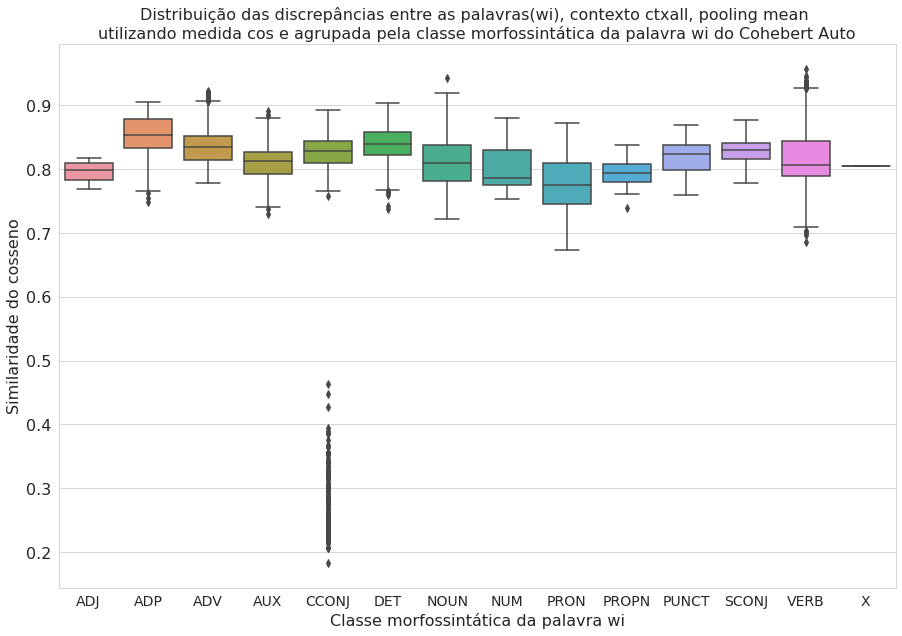

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.796613 0.015679 0.769599 0.782622 0.798902 0.810032   
ADP   1941.000000 0.852536 0.029106 0.748052 0.832544 0.853833 0.878421   
ADV   1252.000000 0.812896 0.039625 0.679531 0.806687 0.821057 0.839283   
AUX   1043.000000 0.810086 0.023837 0.730470 0.791991 0.812661 0.827571   
CCONJ 1415.000000 0.759857 0.189283 0.182750 0.809846 0.827781 0.843850   
DET   3485.000000 0.835034 0.032408 0.660060 0.820664 0.838711 0.857432   
NOUN  5375.000000 0.794559 0.033865 0.679519 0.769793 0.792347 0.820864   
NUM     12.000000 0.804500 0.044161 0.753272 0.775297 0.785529 0.829422   
PRON  2061.000000 0.776900 0.042754 0.672852 0.745520 0.775174 0.809543   
PROPN   28.000000 0.792035 0.020572 0.739156 0.780289 0.793870 0.807659   
PUNCT 2023.000000 0.819292 0.022444 0.760303 0.799493 0.823531 0.838140   
SCONJ  972.000000 0.830449 0.017998 0.778505 0.816411 0.830763 0.841821   
VERB  2279.000000 0.786768 0.037135 0.668772 0.753431 0.791165 0.811907   
X        1.000000 0.805443      NaN 0.805443 0.805443 0.805443 0.805443   

           max  
pos_i           
ADJ   0.817718  
ADP   0.905457  
ADV   0.881016  
AUX   0.891467  
CCONJ 0.892956  
DET   0.903687  
NOUN  0.869701  
NUM   0.879971  
PRON  0.873064  
PROPN 0.838037  
PUNCT 0.868951  
SCONJ 0.876487  
VERB  0.881739  
X     0.805443

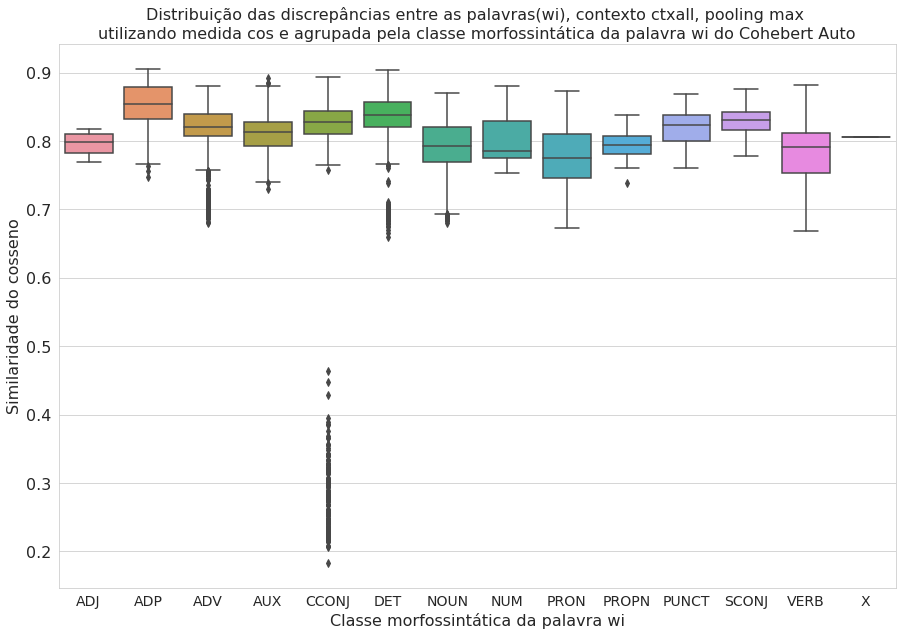

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 29.008284 3.655934 23.631256 26.969103 28.392756 29.945688   
ADP   1941.000000 21.303694 1.934213 17.718098 19.549412 21.421768 22.672523   
ADV   1252.000000 20.906601 2.791535 14.000929 20.748172 21.940574 22.606441   
AUX   1043.000000 23.032322 1.604335 18.430241 21.765179 22.802958 24.299647   
CCONJ 1415.000000 22.744767 4.439286 17.909039 20.369629 21.289209 22.378661   
DET   3485.000000 20.768106 1.764188 15.686503 19.564255 20.700386 21.599438   
NOUN  5375.000000 24.520707 4.927789 11.953954 21.451769 24.368387 26.791040   
NUM     12.000000 26.100978 4.170989 18.474556 23.483199 28.081937 29.316023   
PRON  2061.000000 24.991163 2.878255 18.631195 22.302086 26.031355 27.264746   
PROPN   28.000000 30.232493 2.045352 25.845282 29.244113 30.137141 30.770532   
PUNCT 2023.000000 21.993222 1.305510 18.498266 20.892530 21.782288 23.211883   
SCONJ  972.000000 21.607212 1.129645 19.024080 20.794685 21.708012 22.451430   
VERB  2279.000000 24.201168 5.477122 10.615781 21.897848 24.714891 27.744214   
X        1.000000 28.729015      NaN 28.729015 28.729015 28.729015 28.729015   

            max  
pos_i            
ADJ   39.239494  
ADP   32.075611  
ADV   29.008612  
AUX   32.312084  
CCONJ 35.282307  
DET   32.156246  
NOUN  40.800144  
NUM   29.889786  
PRON  30.349995  
PROPN 35.572773  
PUNCT 27.059006  
SCONJ 24.555210  
VERB  42.533066  
X     28.729015

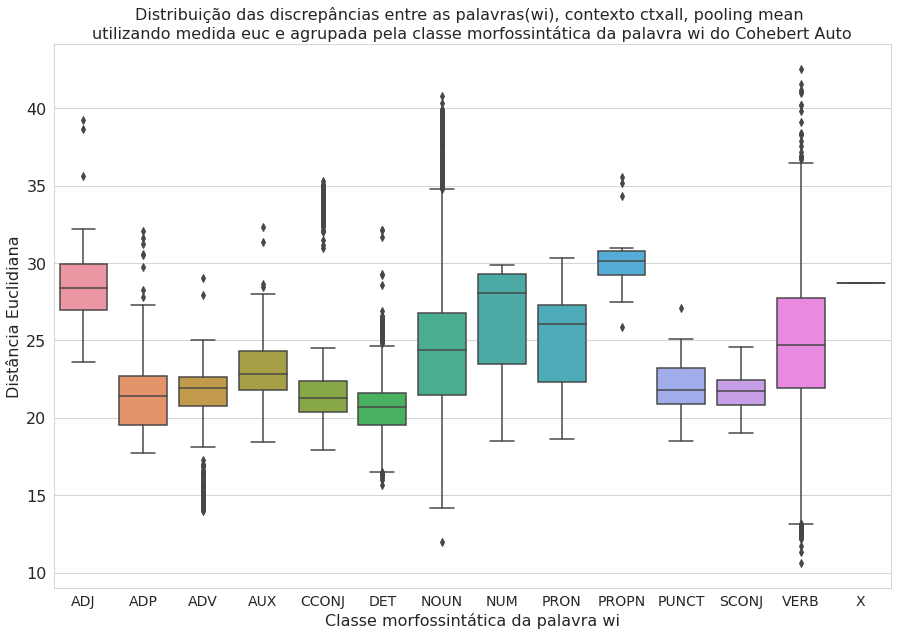

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 29.008284 3.655934 23.631256 26.969103 28.392756 29.945688   
ADP   1941.000000 21.303694 1.934213 17.718098 19.549412 21.421768 22.672523   
ADV   1252.000000 23.104560 2.520857 18.968613 21.581561 22.446731 23.245120   
AUX   1043.000000 23.032322 1.604335 18.430241 21.765179 22.802958 24.299647   
CCONJ 1415.000000 22.744767 4.439286 17.909039 20.369629 21.289209 22.378661   
DET   3485.000000 21.056131 2.200495 17.077425 19.635630 20.775633 21.697163   
NOUN  5375.000000 25.905965 3.871573 19.250891 23.275522 25.496927 27.279756   
NUM     12.000000 26.100978 4.170989 18.474556 23.483199 28.081937 29.316023   
PRON  2061.000000 24.991163 2.878255 18.631195 22.302086 26.031355 27.264746   
PROPN   28.000000 30.232493 2.045352 25.845282 29.244113 30.137141 30.770532   
PUNCT 2023.000000 21.993222 1.305510 18.498266 20.892530 21.782288 23.211883   
SCONJ  972.000000 21.607212 1.129645 19.024080 20.794685 21.708012 22.451430   
VERB  2279.000000 26.700565 3.118810 18.909819 24.608233 26.719694 27.972569   
X        1.000000 28.729015      NaN 28.729015 28.729015 28.729015 28.729015   

            max  
pos_i            
ADJ   39.239494  
ADP   32.075611  
ADV   31.313007  
AUX   32.312084  
CCONJ 35.282307  
DET   32.156246  
NOUN  40.800144  
NUM   29.889786  
PRON  30.349995  
PROPN 35.572773  
PUNCT 27.059006  
SCONJ 24.555210  
VERB  42.533066  
X     28.729015

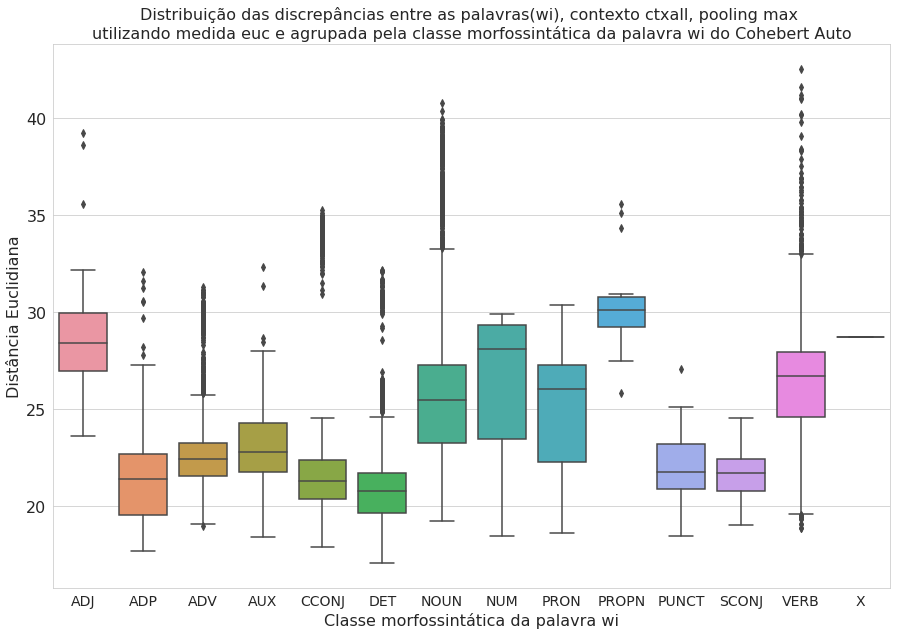

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1305.879863 100.168318 1151.079700 1248.529525 1299.468300   
ADP   1941.000000 1048.561231  92.231950  850.644900  966.133360 1057.501000   
ADV   1252.000000 1036.891165 145.000647  683.242800 1027.139075 1091.970350   
AUX   1043.000000 1102.548477  79.683843  873.821700 1033.574250 1086.711200   
CCONJ 1415.000000 1046.517497  58.831873  874.588200 1007.620425 1048.544600   
DET   3485.000000 1018.977779  89.996840  775.547550  955.253400 1018.882140   
NOUN  5375.000000 1118.128847 168.868847  583.641850 1021.496735 1139.305500   
NUM     12.000000 1274.738730 193.643259  937.791700 1145.815725 1361.082450   
PRON  2061.000000 1216.218330 149.354259  896.515000 1076.830800 1270.413000   
PROPN   28.000000 1372.275546  76.723980 1132.254900 1340.208700 1377.994900   
PUNCT 2023.000000 1094.302125  63.375384  912.877000 1041.591800 1093.056500   
SCONJ  972.000000 1071.538425  57.691136  948.271850 1028.906925 1076.958050   
VERB  2279.000000 1131.283844 226.168059  524.864750 1050.129800 1164.963100   
X        1.000000 1298.350000        NaN 1298.350000 1298.350000 1298.350000   

              75%         max  
pos_i                          
ADJ   1373.749775 1579.861000  
ADP   1112.062600 1564.550800  
ADV   1122.657075 1342.941900  
AUX   1172.486350 1390.983900  
CCONJ 1093.210150 1210.494900  
DET   1069.733900 1559.427000  
NOUN  1239.150650 1732.394800  
NUM   1414.116500 1468.390500  
PRON  1337.565700 1487.845600  
PROPN 1440.379800 1472.591800  
PUNCT 1151.127350 1230.369000  
SCONJ 1115.311600 1225.790600  
VERB  1289.001450 1595.788100  
X     1298.350000 1298.350000

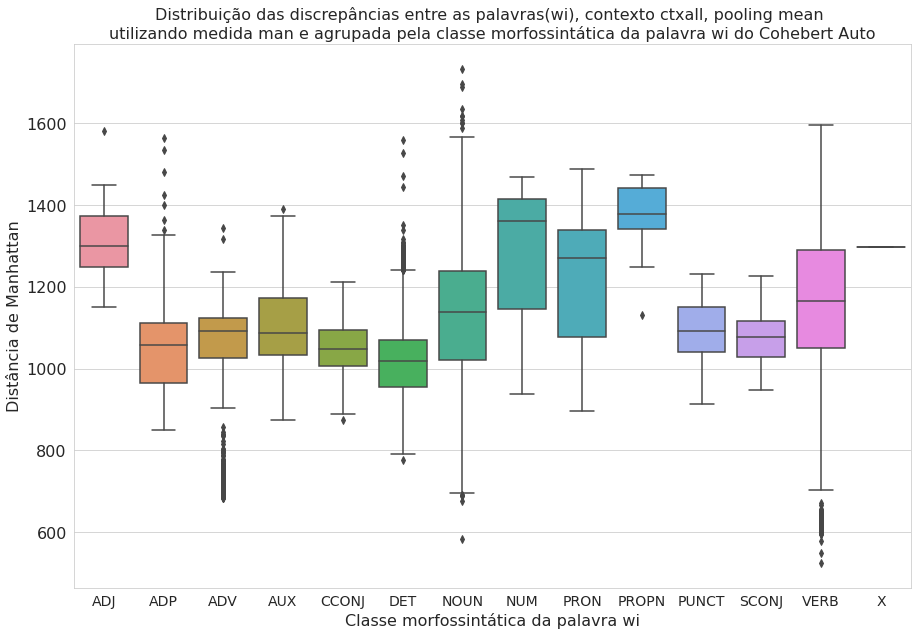

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1305.879863 100.168318 1151.079700 1248.529525 1299.468300   
ADP   1941.000000 1048.561231  92.231950  850.644900  966.133360 1057.501000   
ADV   1252.000000 1152.841844 133.849381  942.990100 1076.074275 1111.838850   
AUX   1043.000000 1102.548477  79.683843  873.821700 1033.574250 1086.711200   
CCONJ 1415.000000 1046.517497  58.831873  874.588200 1007.620425 1048.544600   
DET   3485.000000 1033.949038 115.759738  844.126460  962.399540 1023.081050   
NOUN  5375.000000 1186.798264 130.918150  908.613650 1084.764550 1183.171100   
NUM     12.000000 1274.738730 193.643259  937.791700 1145.815725 1361.082450   
PRON  2061.000000 1216.218330 149.354259  896.515000 1076.830800 1270.413000   
PROPN   28.000000 1372.275546  76.723980 1132.254900 1340.208700 1377.994900   
PUNCT 2023.000000 1094.302125  63.375384  912.877000 1041.591800 1093.056500   
SCONJ  972.000000 1071.538425  57.691136  948.271850 1028.906925 1076.958050   
VERB  2279.000000 1252.006997 117.898200  902.745000 1172.787400 1269.337000   
X        1.000000 1298.350000        NaN 1298.350000 1298.350000 1298.350000   

              75%         max  
pos_i                          
ADJ   1373.749775 1579.861000  
ADP   1112.062600 1564.550800  
ADV   1159.068225 1591.187300  
AUX   1172.486350 1390.983900  
CCONJ 1093.210150 1210.494900  
DET   1074.026400 1643.722900  
NOUN  1270.942850 1732.394800  
NUM   1414.116500 1468.390500  
PRON  1337.565700 1487.845600  
PROPN 1440.379800 1472.591800  
PUNCT 1151.127350 1230.369000  
SCONJ 1115.311600 1225.790600  
VERB  1320.557350 1618.837900  
X     1298.350000 1298.350000

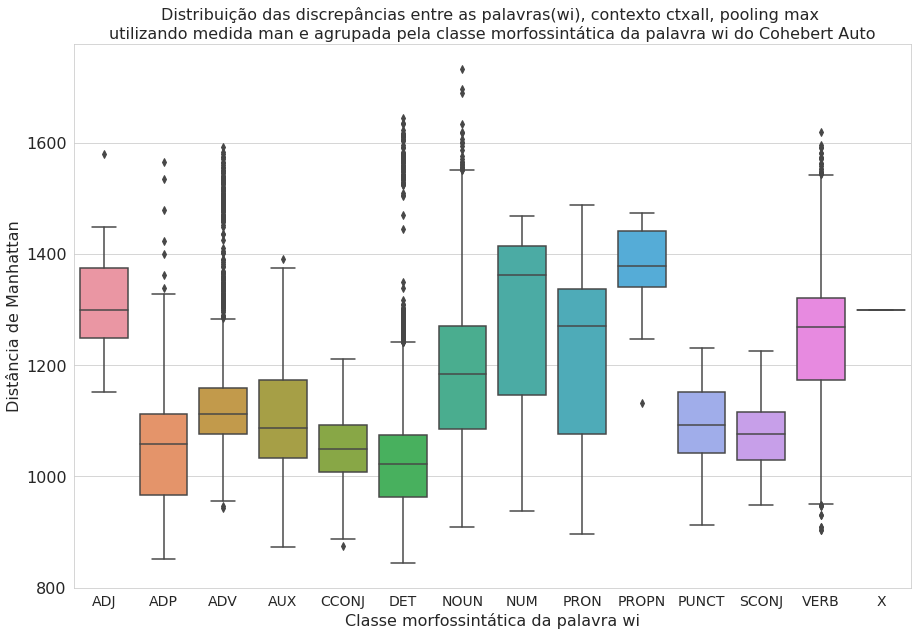

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.836375 0.045951 0.728435 0.836278 0.846467 0.866201   
ADP   1941.000000 0.791644 0.035313 0.689662 0.764761 0.796156 0.817089   
ADV   1252.000000 0.761632 0.058060 0.673134 0.721937 0.745768 0.768417   
AUX   1043.000000 0.695234 0.040135 0.598574 0.668378 0.684013 0.709827   
CCONJ 1415.000000 0.673137 0.178896 0.152244 0.714477 0.733466 0.751178   
DET   3485.000000 0.769934 0.038729 0.671993 0.742668 0.767260 0.800114   
NOUN  5375.000000 0.852090 0.021060 0.741470 0.837835 0.851413 0.867344   
NUM     12.000000 0.810395 0.039772 0.727930 0.785712 0.830837 0.834350   
PRON  2061.000000 0.680123 0.097129 0.503541 0.591441 0.683493 0.712365   
PROPN   28.000000 0.850154 0.020697 0.802336 0.834421 0.849999 0.867382   
PUNCT 2023.000000 0.799208 0.025144 0.721226 0.783549 0.799529 0.815112   
SCONJ  972.000000 0.769288 0.019692 0.699049 0.755843 0.769763 0.782058   
VERB  2279.000000 0.846916 0.034573 0.689588 0.823173 0.855841 0.872542   
X        1.000000 0.864755      NaN 0.864755 0.864755 0.864755 0.864755   

           max  
pos_i           
ADJ   0.898566  
ADP   0.871463  
ADV   0.902430  
AUX   0.880854  
CCONJ 0.835327  
DET   0.876287  
NOUN  0.909093  
NUM   0.853395  
PRON  0.903345  
PROPN 0.878882  
PUNCT 0.880776  
SCONJ 0.844912  
VERB  0.923698  
X     0.864755

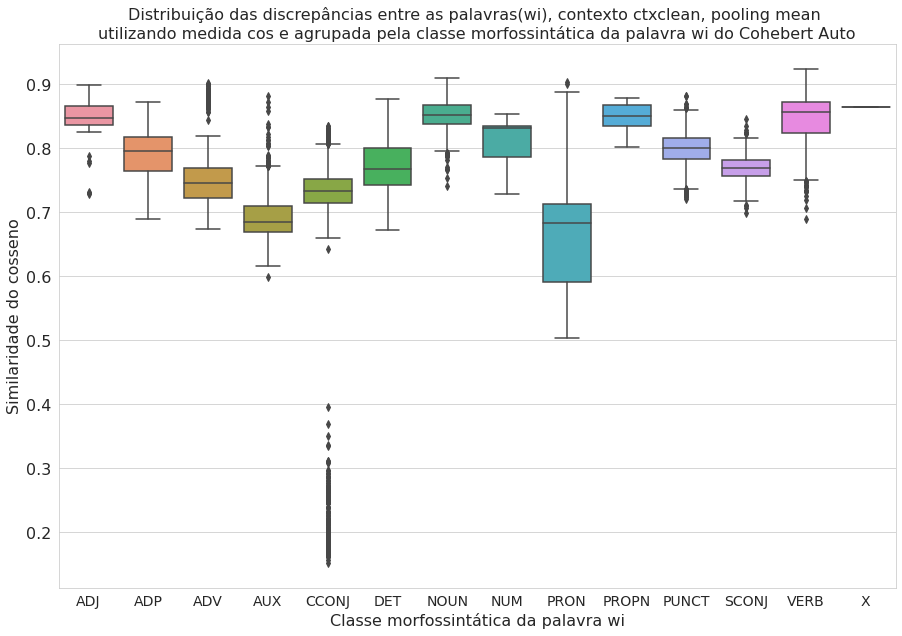

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.836375 0.045951 0.728435 0.836278 0.846467 0.866201   
ADP   1941.000000 0.791644 0.035313 0.689662 0.764761 0.796156 0.817089   
ADV   1252.000000 0.733304 0.025477 0.664103 0.713883 0.733209 0.752438   
AUX   1043.000000 0.695234 0.040135 0.598574 0.668378 0.684013 0.709827   
CCONJ 1415.000000 0.673137 0.178896 0.152244 0.714477 0.733466 0.751178   
DET   3485.000000 0.766264 0.038519 0.643763 0.740174 0.765479 0.797211   
NOUN  5375.000000 0.833814 0.049028 0.654328 0.824102 0.846937 0.865917   
NUM     12.000000 0.810395 0.039772 0.727930 0.785712 0.830837 0.834350   
PRON  2061.000000 0.680123 0.097129 0.503541 0.591441 0.683493 0.712365   
PROPN   28.000000 0.850154 0.020697 0.802336 0.834421 0.849999 0.867382   
PUNCT 2023.000000 0.799208 0.025144 0.721226 0.783549 0.799529 0.815112   
SCONJ  972.000000 0.769288 0.019692 0.699049 0.755843 0.769763 0.782058   
VERB  2279.000000 0.813722 0.065870 0.644451 0.753394 0.832398 0.868258   
X        1.000000 0.864755      NaN 0.864755 0.864755 0.864755 0.864755   

           max  
pos_i           
ADJ   0.898566  
ADP   0.871463  
ADV   0.819716  
AUX   0.880854  
CCONJ 0.835327  
DET   0.864677  
NOUN  0.909093  
NUM   0.853395  
PRON  0.903345  
PROPN 0.878882  
PUNCT 0.880776  
SCONJ 0.844912  
VERB  0.912413  
X     0.864755

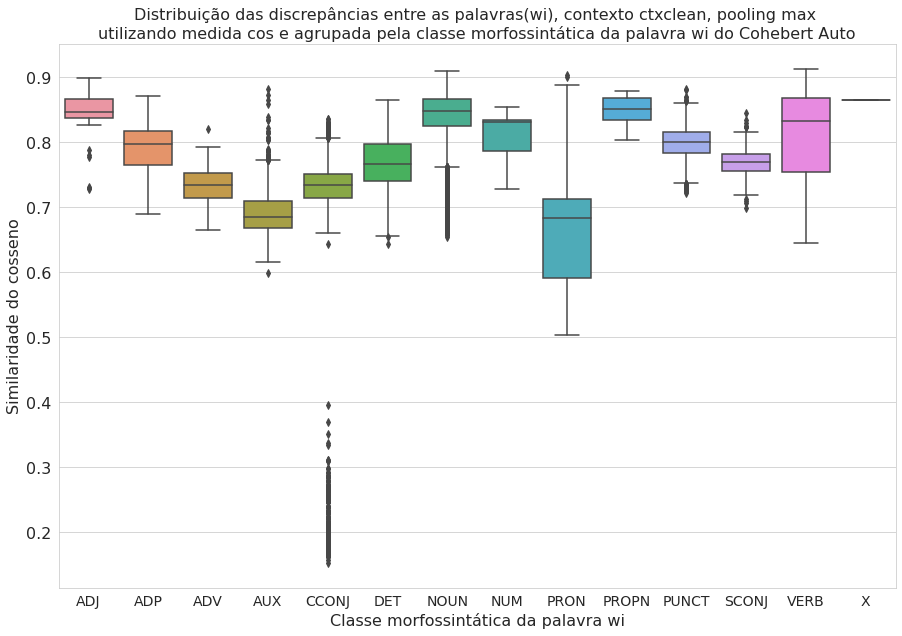

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 26.259669 4.006048 19.962036 23.398276 24.902007 28.451113   
ADP   1941.000000 24.988767 1.907700 19.829464 23.663715 24.892130 26.548971   
ADV   1252.000000 25.421276 4.049739 14.892302 25.027318 26.768313 28.155514   
AUX   1043.000000 29.076506 2.232689 19.966867 28.527474 29.772787 30.547458   
CCONJ 1415.000000 27.686834 3.968585 22.023130 25.701824 26.548721 27.604450   
DET   3485.000000 24.839094 2.141524 16.878771 23.536255 24.693991 26.014204   
NOUN  5375.000000 22.192333 3.395575 16.489443 20.243881 21.517450 22.975286   
NUM     12.000000 25.677662 2.409283 21.358953 24.743067 26.005936 26.525398   
PRON  2061.000000 29.756888 4.607394 20.188396 27.613241 29.136557 34.219570   
PROPN   28.000000 26.335295 2.047077 22.759544 25.296304 26.597232 27.057678   
PUNCT 2023.000000 23.351348 1.423211 18.484659 22.467412 23.432934 24.281404   
SCONJ  972.000000 25.184195 1.219472 21.525686 24.452103 25.215126 26.018528   
VERB  2279.000000 22.558524 3.520395 13.929336 20.030607 22.614470 24.764598   
X        1.000000 24.624529      NaN 24.624529 24.624529 24.624529 24.624529   

            max  
pos_i            
ADJ   35.070232  
ADP   34.777252  
ADV   32.343609  
AUX   34.049515  
CCONJ 40.750175  
DET   34.546204  
NOUN  37.109863  
NUM   30.073204  
PRON  39.601833  
PROPN 31.302988  
PUNCT 27.619390  
SCONJ 29.020411  
VERB  38.542923  
X     24.624529

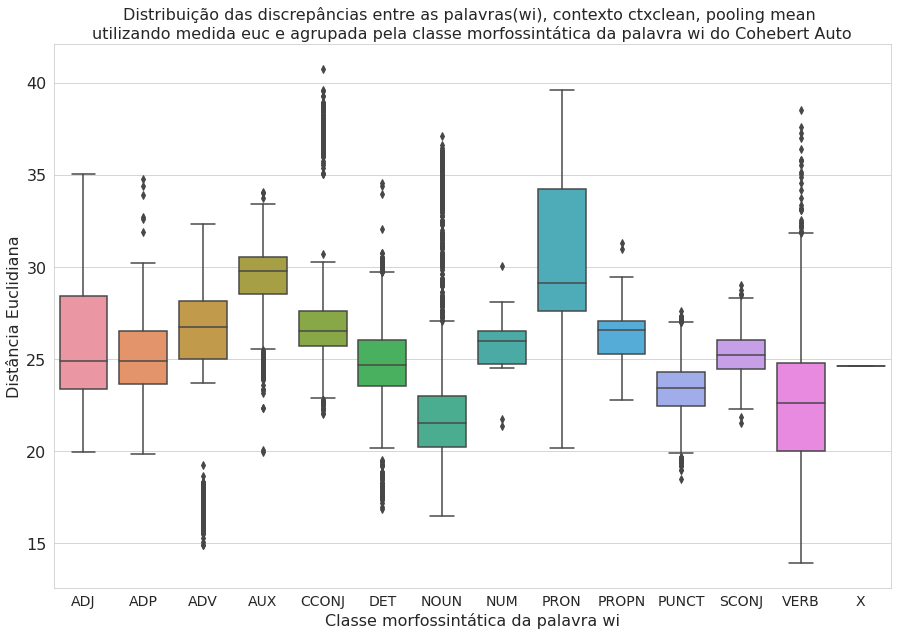

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 26.259669 4.006048 19.962036 23.398276 24.902007 28.451113   
ADP   1941.000000 24.988767 1.907700 19.829464 23.663715 24.892130 26.548971   
ADV   1252.000000 27.534100 1.717069 23.706490 26.129045 27.669155 28.765382   
AUX   1043.000000 29.076506 2.232689 19.966867 28.527474 29.772787 30.547458   
CCONJ 1415.000000 27.686834 3.968585 22.023130 25.701824 26.548721 27.604450   
DET   3485.000000 25.114170 2.119633 20.352678 23.653708 24.796259 26.182354   
NOUN  5375.000000 23.514808 3.686522 17.304411 21.100550 22.351429 24.935897   
NUM     12.000000 25.677662 2.409283 21.358953 24.743067 26.005936 26.525398   
PRON  2061.000000 29.756888 4.607394 20.188396 27.613241 29.136557 34.219570   
PROPN   28.000000 26.335295 2.047077 22.759544 25.296304 26.597232 27.057678   
PUNCT 2023.000000 23.351348 1.423211 18.484659 22.467412 23.432934 24.281404   
SCONJ  972.000000 25.184195 1.219472 21.525686 24.452103 25.215126 26.018528   
VERB  2279.000000 24.890378 3.528929 16.645187 21.919596 25.010851 27.666562   
X        1.000000 24.624529      NaN 24.624529 24.624529 24.624529 24.624529   

            max  
pos_i            
ADJ   35.070232  
ADP   34.777252  
ADV   32.343609  
AUX   34.049515  
CCONJ 40.750175  
DET   34.546204  
NOUN  37.109863  
NUM   30.073204  
PRON  39.601833  
PROPN 31.302988  
PUNCT 27.619390  
SCONJ 29.020411  
VERB  38.542923  
X     24.624529

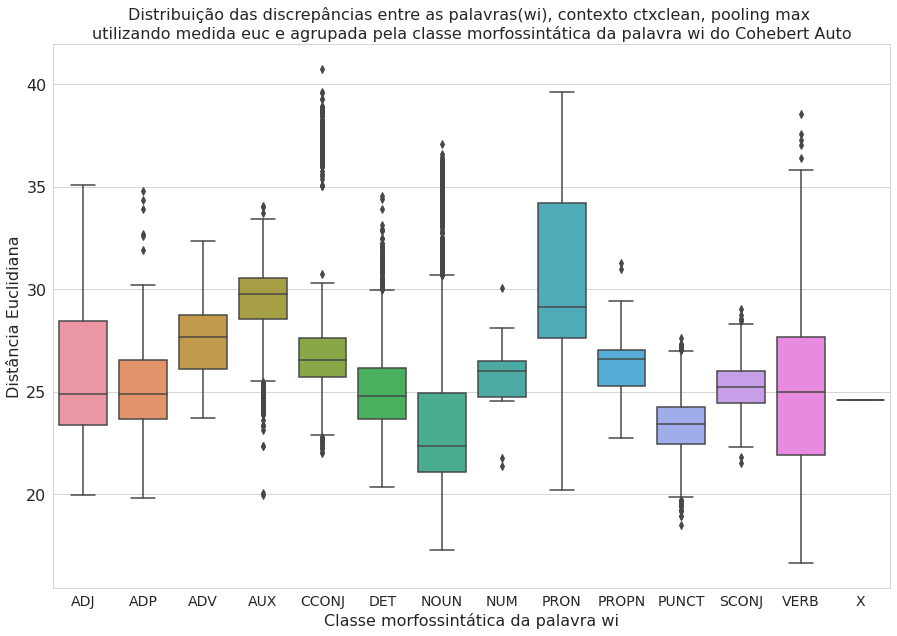

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1204.662163 157.820445  955.844300 1119.243325 1155.446050   
ADP   1941.000000 1217.346483  86.469916  997.905400 1156.627600 1210.479500   
ADV   1252.000000 1241.177580 204.791508  710.153700 1215.214625 1318.498900   
AUX   1043.000000 1357.219095  97.002470  970.064940 1330.859050 1385.647200   
CCONJ 1415.000000 1248.345141  63.887766 1069.871600 1202.666750 1253.404900   
DET   3485.000000 1189.960402  90.976556  818.439150 1139.274800 1181.496100   
NOUN  5375.000000 1019.545600  97.789814  803.217040  950.825250 1002.931150   
NUM     12.000000 1265.620442 121.479174 1065.390000 1208.694850 1270.699650   
PRON  2061.000000 1415.159373 205.416913  992.995240 1306.594500 1368.718000   
PROPN   28.000000 1216.104618  79.778996 1018.478800 1178.873825 1230.150550   
PUNCT 2023.000000 1133.059545  71.035252  895.925300 1090.069650 1142.332200   
SCONJ  972.000000 1222.574009  58.239562 1065.180200 1184.531075 1220.050050   
VERB  2279.000000 1064.077674 153.757357  681.581670  951.481730 1077.826300   
X        1.000000 1137.411300        NaN 1137.411300 1137.411300 1137.411300   

              75%         max  
pos_i                          
ADJ   1307.612225 1554.588600  
ADP   1281.513500 1697.233600  
ADV   1380.334300 1552.200700  
AUX   1424.499650 1575.899800  
CCONJ 1292.509100 1429.232900  
DET   1238.439000 1682.924800  
NOUN  1079.585050 1523.703000  
NUM   1308.325850 1501.939500  
PRON  1627.841300 1759.430200  
PROPN 1278.275175 1309.275800  
PUNCT 1188.051750 1275.115000  
SCONJ 1256.755175 1432.604000  
VERB  1171.523900 1620.444600  
X     1137.411300 1137.411300

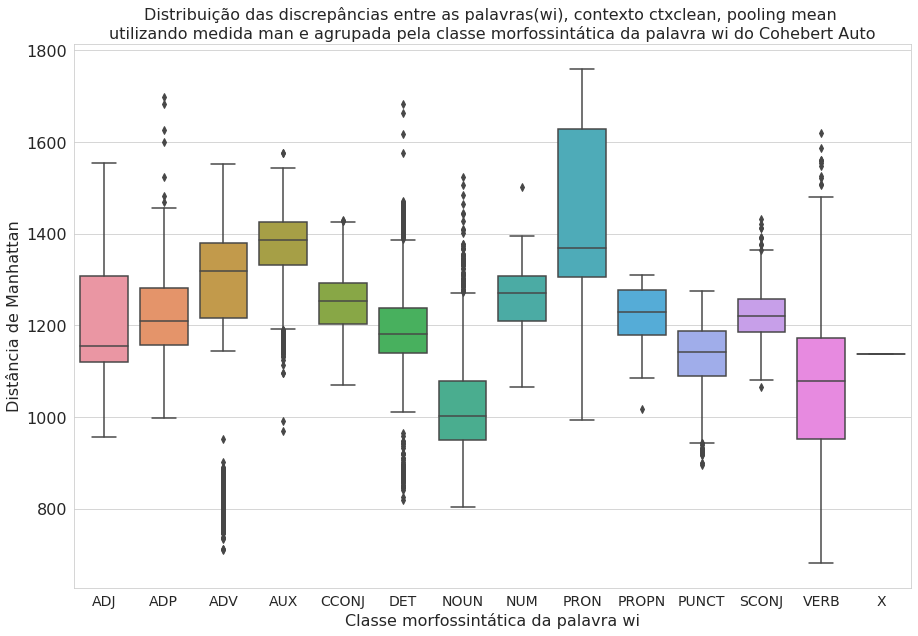

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1204.662163 157.820445  955.844300 1119.243325 1155.446050   
ADP   1941.000000 1217.346483  86.469916  997.905400 1156.627600 1210.479500   
ADV   1252.000000 1352.345269  96.486582 1145.123800 1266.444700 1360.108150   
AUX   1043.000000 1357.219095  97.002470  970.064940 1330.859050 1385.647200   
CCONJ 1415.000000 1248.345141  63.887766 1069.871600 1202.666750 1253.404900   
DET   3485.000000 1204.389453  96.501171 1010.838500 1143.321300 1184.901100   
NOUN  5375.000000 1085.301914 143.745437  810.949100  983.195425 1054.631100   
NUM     12.000000 1265.620442 121.479174 1065.390000 1208.694850 1270.699650   
PRON  2061.000000 1415.159373 205.416913  992.995240 1306.594500 1368.718000   
PROPN   28.000000 1216.104618  79.778996 1018.478800 1178.873825 1230.150550   
PUNCT 2023.000000 1133.059545  71.035252  895.925300 1090.069650 1142.332200   
SCONJ  972.000000 1222.574009  58.239562 1065.180200 1184.531075 1220.050050   
VERB  2279.000000 1175.289033 155.545696  803.258200 1046.832950 1183.867400   
X        1.000000 1137.411300        NaN 1137.411300 1137.411300 1137.411300   

              75%         max  
pos_i                          
ADJ   1307.612225 1554.588600  
ADP   1281.513500 1697.233600  
ADV   1412.321000 1630.204700  
AUX   1424.499650 1575.899800  
CCONJ 1292.509100 1429.232900  
DET   1244.860500 1682.924800  
NOUN  1157.257650 1617.785800  
NUM   1308.325850 1501.939500  
PRON  1627.841300 1759.430200  
PROPN 1278.275175 1309.275800  
PUNCT 1188.051750 1275.115000  
SCONJ 1256.755175 1432.604000  
VERB  1304.400250 1654.705700  
X     1137.411300 1137.411300

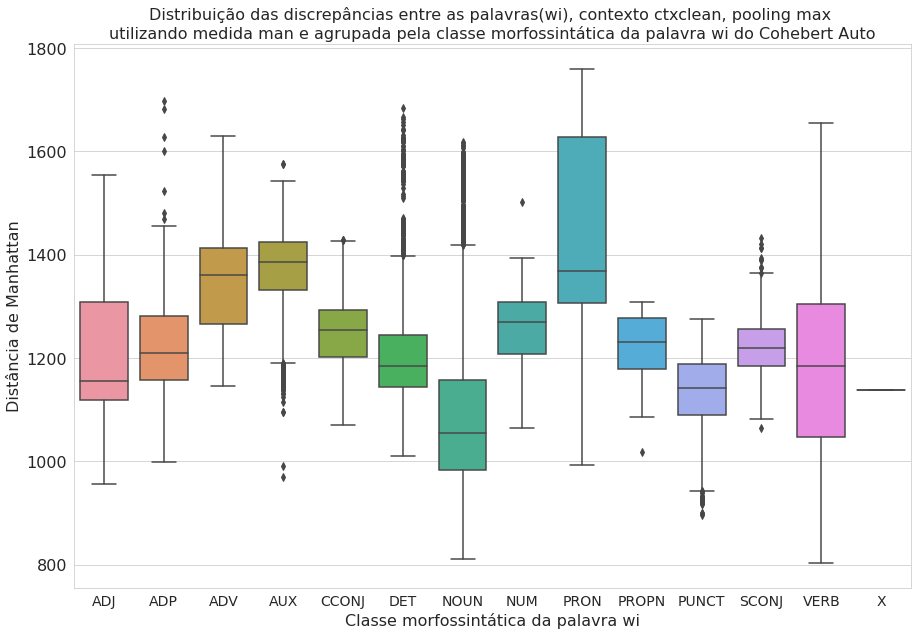

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ      6.000000 0.578178 0.049365 0.518816 0.541632 0.580316 0.600760   
ADP   1598.000000 0.685757 0.058075 0.517417 0.648498 0.688859 0.727216   
ADV   1246.000000 0.712504 0.053831 0.581703 0.661812 0.731898 0.755228   
AUX   1043.000000 0.897032 0.057197 0.807094 0.859582 0.878571 0.911839   
CCONJ 1415.000000 0.642840 0.179991 0.102380 0.675643 0.704753 0.728810   
DET   3348.000000 0.686452 0.064717 0.497452 0.638260 0.699241 0.732799   
NOUN  4898.000000 0.671209 0.065974 0.456666 0.638149 0.682946 0.717935   
NUM      3.000000 0.606666 0.036487 0.571808 0.587704 0.603601 0.624095   
PRON  2061.000000 0.690819 0.049033 0.517152 0.677279 0.700093 0.721319   
PROPN    1.000000 0.657868      NaN 0.657868 0.657868 0.657868 0.657868   
PUNCT 1902.000000 0.669632 0.045164 0.541762 0.641550 0.672780 0.706775   
SCONJ  968.000000 0.704606 0.038868 0.602023 0.675435 0.704128 0.737182   
VERB  2279.000000 0.918918 0.057525 0.785569 0.878470 0.909328 1.000000   
X        0.000000      NaN      NaN      NaN      NaN      NaN      NaN   

           max  
pos_i           
ADJ   0.653310  
ADP   0.834039  
ADV   0.800310  
AUX   1.000000  
CCONJ 0.813493  
DET   0.833035  
NOUN  0.811667  
NUM   0.644589  
PRON  0.777243  
PROPN 0.657868  
PUNCT 0.751780  
SCONJ 0.797153  
VERB  1.000000  
X          NaN

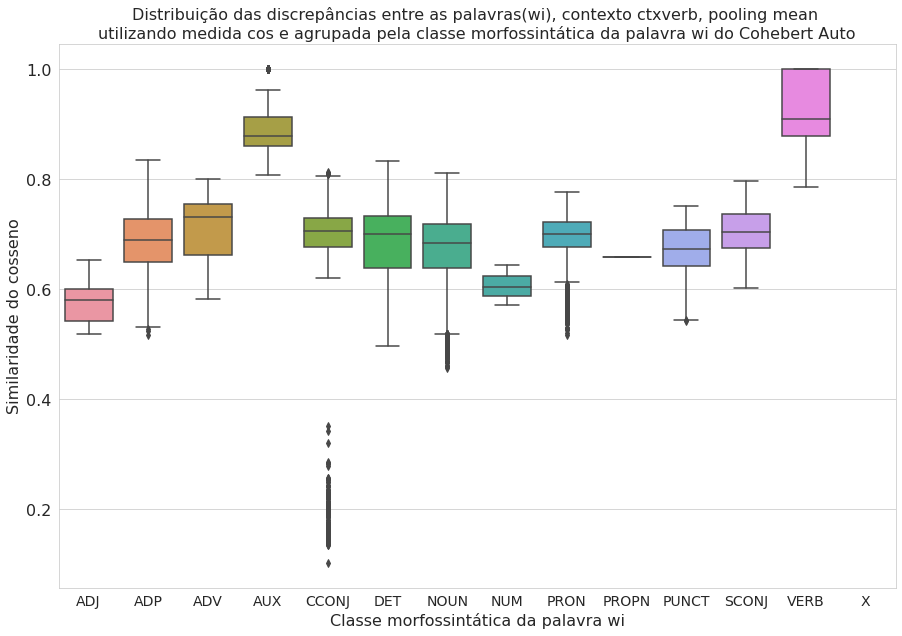

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ      6.000000 0.578178 0.049365 0.518816 0.541632 0.580316 0.600760   
ADP   1598.000000 0.685757 0.058075 0.517417 0.648498 0.688859 0.727216   
ADV   1246.000000 0.691753 0.074500 0.498306 0.641697 0.722800 0.750550   
AUX   1043.000000 0.897032 0.057197 0.807094 0.859582 0.878571 0.911839   
CCONJ 1415.000000 0.642840 0.179991 0.102380 0.675643 0.704753 0.728810   
DET   3348.000000 0.682913 0.064376 0.497452 0.632631 0.695732 0.728980   
NOUN  4898.000000 0.657854 0.070181 0.456666 0.616322 0.669196 0.710641   
NUM      3.000000 0.606666 0.036487 0.571808 0.587704 0.603601 0.624095   
PRON  2061.000000 0.690819 0.049033 0.517152 0.677279 0.700093 0.721319   
PROPN    1.000000 0.657868      NaN 0.657868 0.657868 0.657868 0.657868   
PUNCT 1902.000000 0.669632 0.045164 0.541762 0.641550 0.672780 0.706775   
SCONJ  968.000000 0.704606 0.038868 0.602023 0.675435 0.704128 0.737182   
VERB  2279.000000 0.885543 0.094894 0.655180 0.809635 0.904733 0.953180   
X        0.000000      NaN      NaN      NaN      NaN      NaN      NaN   

           max  
pos_i           
ADJ   0.653310  
ADP   0.834039  
ADV   0.796782  
AUX   1.000000  
CCONJ 0.813493  
DET   0.833035  
NOUN  0.811667  
NUM   0.644589  
PRON  0.777243  
PROPN 0.657868  
PUNCT 0.751780  
SCONJ 0.797153  
VERB  1.000000  
X          NaN

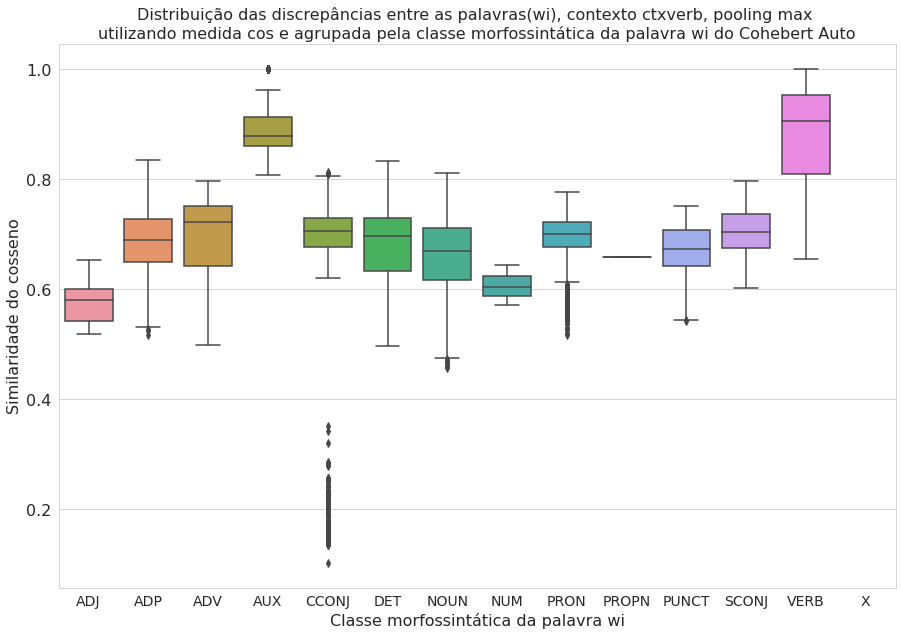

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ      6.000000 39.867541 2.065332 36.211933 39.320407 40.295149 41.050184   
ADP   1598.000000 32.161974 3.691245 23.026712 29.016967 31.804046 35.156046   
ADV   1246.000000 29.070386 3.460069 21.456024 26.114463 28.395533 32.618210   
AUX   1043.000000 15.453425 7.999066  0.000000 16.646729 18.915998 20.354701   
CCONJ 1415.000000 30.091438 4.001603 24.140364 27.560771 28.917572 30.841632   
DET   3348.000000 30.442624 4.268410 21.522627 27.470216 29.353125 33.841835   
NOUN  4898.000000 33.032360 4.787903 22.360905 29.689782 32.128242 35.146356   
NUM      3.000000 35.172054 2.242634 32.973854 34.029768 35.085682 36.271154   
PRON  2061.000000 30.648616 3.015201 25.033331 28.690166 29.928986 31.562456   
PROPN    1.000000 37.546196      NaN 37.546196 37.546196 37.546196 37.546196   
PUNCT 1902.000000 31.464047 3.272219 25.734577 29.007631 30.929295 33.534438   
SCONJ  968.000000 29.852911 3.109331 23.519705 27.582368 29.503879 32.205283   
VERB  2279.000000 14.271108 8.890570  0.000000  0.000000 17.696329 20.023543   
X        0.000000       NaN      NaN       NaN       NaN       NaN       NaN   

            max  
pos_i            
ADJ   42.105659  
ADP   42.234741  
ADV   40.864735  
AUX   24.962814  
CCONJ 43.425198  
DET   43.948719  
NOUN  52.019890  
NUM   37.456627  
PRON  41.939838  
PROPN 37.546196  
PUNCT 41.148167  
SCONJ 39.669128  
VERB  34.275040  
X           NaN

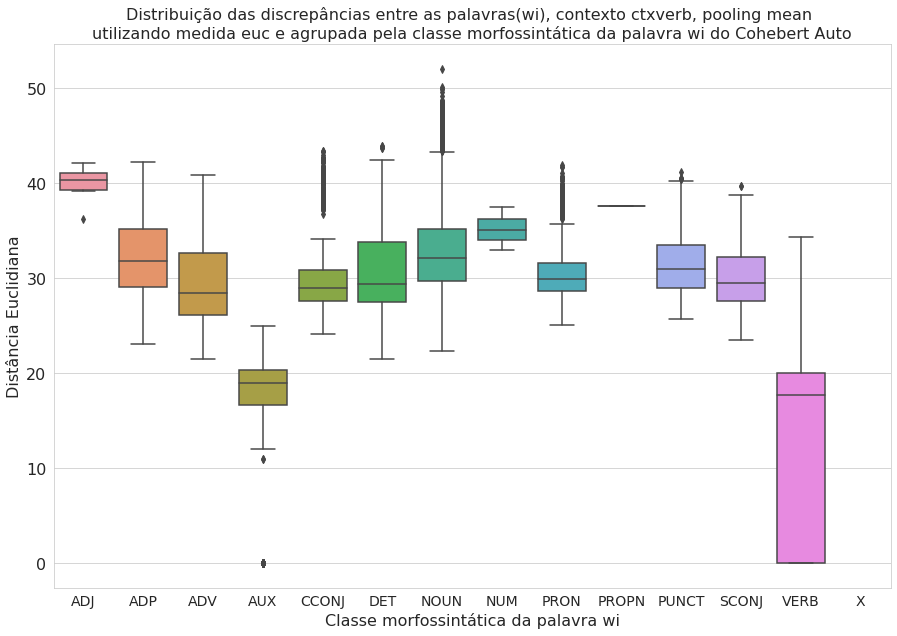

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg       std       min       25%       50%       75%  \
pos_i                                                                           
ADJ      6.000000 39.867541  2.065332 36.211933 39.320407 40.295149 41.050184   
ADP   1598.000000 32.161974  3.691245 23.026712 29.016967 31.804046 35.156046   
ADV   1246.000000 30.475880  4.413338 23.457535 27.186542 29.010230 33.746533   
AUX   1043.000000 15.453425  7.999066  0.000000 16.646729 18.915998 20.354701   
CCONJ 1415.000000 30.091438  4.001603 24.140364 27.560771 28.917572 30.841632   
DET   3348.000000 30.689169  4.194206 21.522627 27.645503 29.544244 34.177117   
NOUN  4898.000000 33.904506  4.592021 24.775270 30.834431 32.869019 36.666553   
NUM      3.000000 35.172054  2.242634 32.973854 34.029768 35.085682 36.271154   
PRON  2061.000000 30.648616  3.015201 25.033331 28.690166 29.928986 31.562456   
PROPN    1.000000 37.546196       NaN 37.546196 37.546196 37.546196 37.546196   
PUNCT 1902.000000 31.464047  3.272219 25.734577 29.007631 30.929295 33.534438   
SCONJ  968.000000 29.852911  3.109331 23.519705 27.582368 29.503879 32.205283   
VERB  2279.000000 16.811641 10.494182  0.000000 12.916603 19.480291 25.321859   
X        0.000000       NaN       NaN       NaN       NaN       NaN       NaN   

            max  
pos_i            
ADJ   42.105659  
ADP   42.234741  
ADV   40.864735  
AUX   24.962814  
CCONJ 43.425198  
DET   43.948719  
NOUN  52.019890  
NUM   37.456627  
PRON  41.939838  
PROPN 37.546196  
PUNCT 41.148167  
SCONJ 39.669128  
VERB  34.807911  
X           NaN

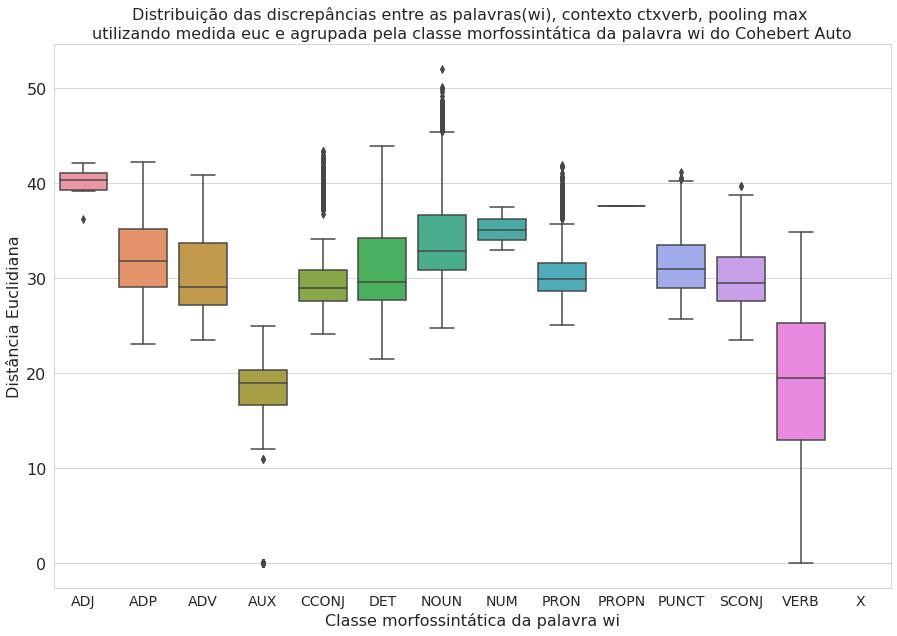

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ      6.000000 1777.830709 103.008012 1626.665649 1719.124146 1785.852112   
ADP   1598.000000 1569.021181 171.165085 1137.969238 1425.564484 1552.828979   
ADV   1246.000000 1425.715278 162.109400 1026.698486 1290.665405 1403.843018   
AUX   1043.000000  714.142975 368.495309    0.000000  783.909973  873.172607   
CCONJ 1415.000000 1404.183713  96.926103 1165.845947 1332.691467 1397.165283   
DET   3348.000000 1470.182784 192.337624 1064.153809 1342.355835 1422.476562   
NOUN  4898.000000 1542.574834 182.551839 1093.340210 1408.256927 1520.441833   
NUM      3.000000 1728.210083  68.170897 1652.895020 1699.469177 1746.043335   
PRON  2061.000000 1478.911156 142.211076 1220.181763 1392.082397 1445.789795   
PROPN    1.000000 1773.412354        NaN 1773.412354 1773.412354 1773.412354   
PUNCT 1902.000000 1535.774961 136.377463 1281.416260 1437.106201 1518.999329   
SCONJ  968.000000 1447.803804 126.438247 1164.205811 1361.274994 1441.132019   
VERB  2279.000000  659.560493 409.554133    0.000000    0.000000  823.600464   
X        0.000000         NaN        NaN         NaN         NaN         NaN   

              75%         max  
pos_i                          
ADJ   1840.805206 1912.609985  
ADP   1704.671936 1961.169434  
ADV   1587.046234 1866.386475  
AUX    939.131653 1082.315552  
CCONJ 1480.741028 1619.710938  
DET   1617.007690 1975.542358  
NOUN  1655.916962 2116.197754  
NUM   1765.867615 1785.691895  
PRON  1518.688965 1961.083008  
PROPN 1773.412354 1773.412354  
PUNCT 1621.016724 1929.380859  
SCONJ 1544.547852 1797.629150  
VERB   914.322571 1362.634277  
X             NaN         NaN

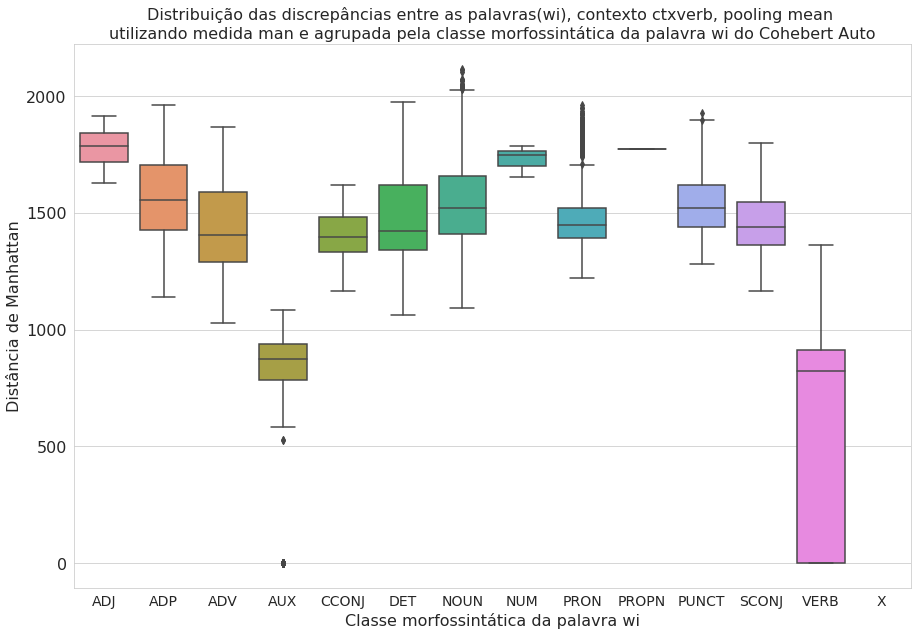

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ      6.000000 1777.830709 103.008012 1626.665649 1719.124146 1785.852112   
ADP   1598.000000 1569.021181 171.165085 1137.969238 1425.564484 1552.828979   
ADV   1246.000000 1498.907935 209.741115 1162.007568 1350.292053 1433.757263   
AUX   1043.000000  714.142975 368.495309    0.000000  783.909973  873.172607   
CCONJ 1415.000000 1404.183713  96.926103 1165.845947 1332.691467 1397.165283   
DET   3348.000000 1482.936894 190.377306 1064.153809 1351.475769 1433.218445   
NOUN  4898.000000 1585.327674 181.628357 1181.119995 1460.656616 1557.950684   
NUM      3.000000 1728.210083  68.170897 1652.895020 1699.469177 1746.043335   
PRON  2061.000000 1478.911156 142.211076 1220.181763 1392.082397 1445.789795   
PROPN    1.000000 1773.412354        NaN 1773.412354 1773.412354 1773.412354   
PUNCT 1902.000000 1535.774961 136.377463 1281.416260 1437.106201 1518.999329   
SCONJ  968.000000 1447.803804 126.438247 1164.205811 1361.274994 1441.132019   
VERB  2279.000000  784.975712 493.146448    0.000000  607.696930  890.547668   
X        0.000000         NaN        NaN         NaN         NaN         NaN   

              75%         max  
pos_i                          
ADJ   1840.805206 1912.609985  
ADP   1704.671936 1961.169434  
ADV   1658.207977 1981.051880  
AUX    939.131653 1082.315552  
CCONJ 1480.741028 1619.710938  
DET   1635.244507 1975.542358  
NOUN  1710.866699 2116.197754  
NUM   1765.867615 1785.691895  
PRON  1518.688965 1961.083008  
PROPN 1773.412354 1773.412354  
PUNCT 1621.016724 1929.380859  
SCONJ 1544.547852 1797.629150  
VERB  1203.997681 1629.228149  
X             NaN         NaN

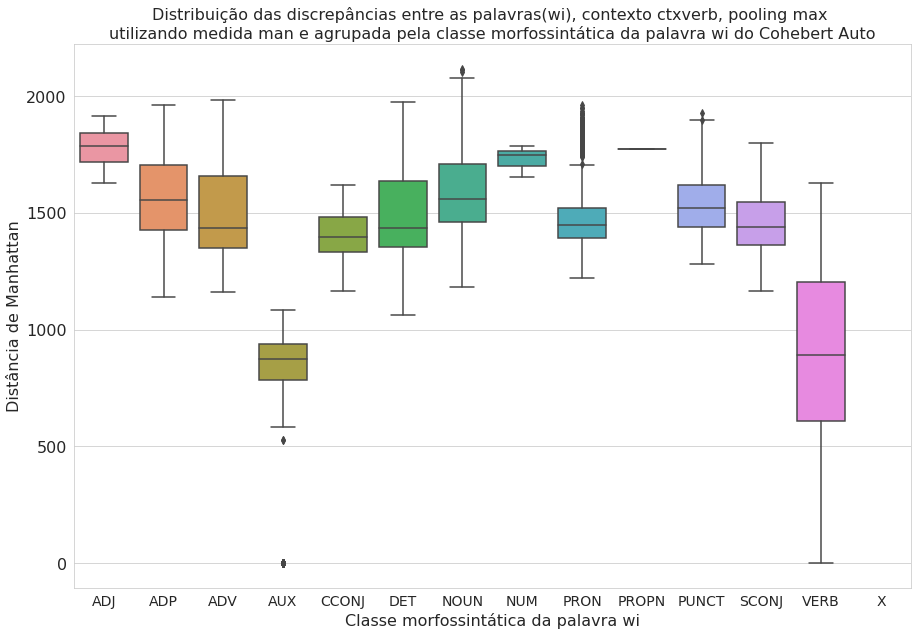

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.766413 0.024836 0.708960 0.757409 0.769697 0.783450   
ADP   1941.000000 0.765178 0.049932 0.637130 0.721834 0.770544 0.809916   
ADV   1252.000000 0.656557 0.055619 0.515823 0.618969 0.646334 0.679481   
AUX   1043.000000 0.609521 0.048193 0.503142 0.575756 0.596734 0.635309   
CCONJ 1415.000000 0.581219 0.149473 0.144498 0.587400 0.623464 0.662528   
DET   3485.000000 0.733282 0.047740 0.613317 0.699584 0.733171 0.772293   
NOUN  5375.000000 0.889423 0.029975 0.775607 0.866306 0.886815 0.916995   
NUM     12.000000 0.764668 0.042971 0.694772 0.740445 0.750646 0.784668   
PRON  2061.000000 0.578783 0.082281 0.428298 0.513403 0.561263 0.609152   
PROPN   28.000000 0.749438 0.029960 0.664614 0.737292 0.750551 0.761635   
PUNCT 2023.000000 0.663047 0.028811 0.592774 0.643752 0.662642 0.681752   
SCONJ  972.000000 0.685809 0.037729 0.587018 0.659097 0.682347 0.700530   
VERB  2279.000000 0.736939 0.035007 0.617038 0.710807 0.740155 0.765765   
X        1.000000 0.796270      NaN 0.796270 0.796270 0.796270 0.796270   

           max  
pos_i           
ADJ   0.801777  
ADP   0.867031  
ADV   0.792798  
AUX   0.810104  
CCONJ 0.765139  
DET   0.862923  
NOUN  0.954686  
NUM   0.852940  
PRON  0.817884  
PROPN 0.811831  
PUNCT 0.812572  
SCONJ 0.801359  
VERB  0.839125  
X     0.796270

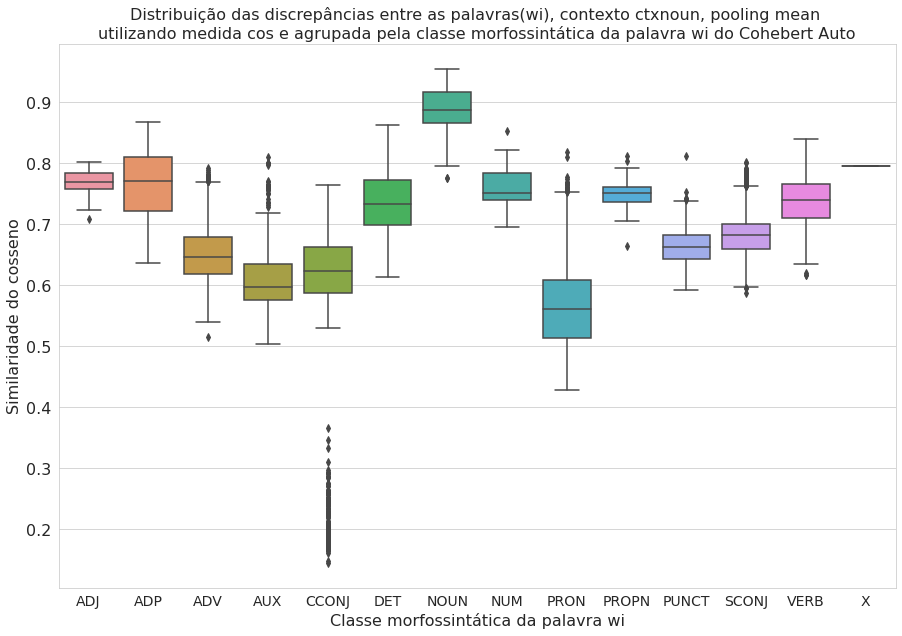

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.766413 0.024836 0.708960 0.757409 0.769697 0.783450   
ADP   1941.000000 0.765178 0.049932 0.637130 0.721834 0.770544 0.809916   
ADV   1252.000000 0.632976 0.032998 0.515823 0.609969 0.632182 0.655519   
AUX   1043.000000 0.609521 0.048193 0.503142 0.575756 0.596734 0.635309   
CCONJ 1415.000000 0.581219 0.149473 0.144498 0.587400 0.623464 0.662528   
DET   3485.000000 0.730132 0.050056 0.583582 0.695034 0.731065 0.769630   
NOUN  5375.000000 0.871116 0.059638 0.654618 0.852706 0.882007 0.916995   
NUM     12.000000 0.764668 0.042971 0.694772 0.740445 0.750646 0.784668   
PRON  2061.000000 0.578783 0.082281 0.428298 0.513403 0.561263 0.609152   
PROPN   28.000000 0.749438 0.029960 0.664614 0.737292 0.750551 0.761635   
PUNCT 2023.000000 0.663047 0.028811 0.592774 0.643752 0.662642 0.681752   
SCONJ  972.000000 0.685809 0.037729 0.587018 0.659097 0.682347 0.700530   
VERB  2279.000000 0.706058 0.055456 0.538330 0.654105 0.717371 0.749917   
X        1.000000 0.796270      NaN 0.796270 0.796270 0.796270 0.796270   

           max  
pos_i           
ADJ   0.801777  
ADP   0.867031  
ADV   0.792798  
AUX   0.810104  
CCONJ 0.765139  
DET   0.862923  
NOUN  0.954686  
NUM   0.852940  
PRON  0.817884  
PROPN 0.811831  
PUNCT 0.812572  
SCONJ 0.801359  
VERB  0.834443  
X     0.796270

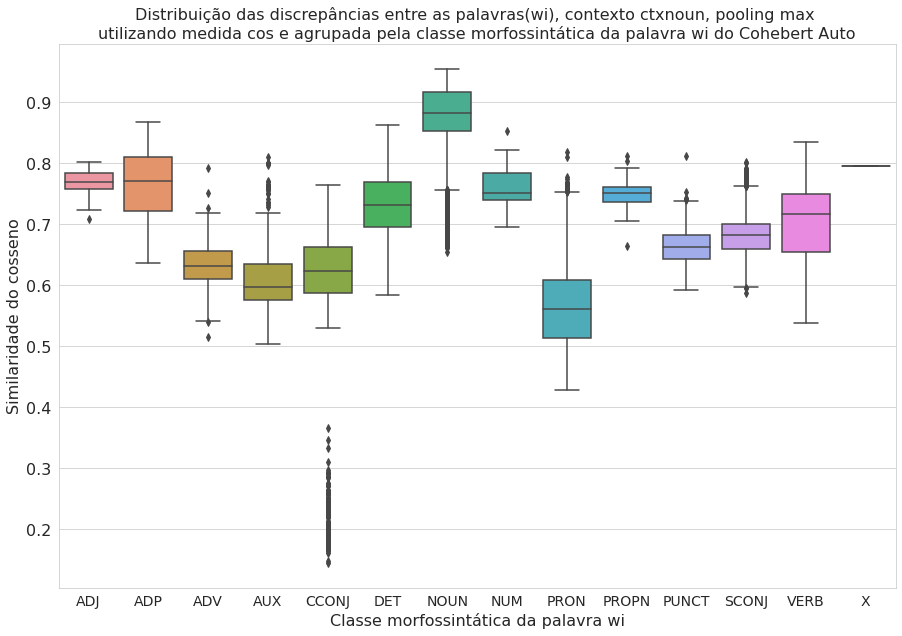

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 30.555732 4.002160 25.738346 28.200130 29.352474 31.932686   
ADP   1941.000000 26.821110 2.692756 20.185192 24.388575 26.811777 29.243032   
ADV   1252.000000 31.523895 3.364688 22.967644 29.770481 31.929402 34.025385   
AUX   1043.000000 33.785614 2.642849 25.340179 31.977725 34.283409 35.787245   
CCONJ 1415.000000 32.986079 3.342490 26.079859 30.656324 32.282375 34.663845   
DET   3485.000000 27.456512 2.574808 20.885464 25.567211 27.206030 29.265095   
NOUN  5375.000000 19.374847 3.521270 12.678500 16.889246 19.162447 20.611534   
NUM     12.000000 28.395225 3.724502 21.842068 26.106944 29.822087 31.157937   
PRON  2061.000000 35.298071 3.580443 26.955940 32.280704 35.655647 38.279682   
PROPN   28.000000 32.436880 2.953135 27.068554 31.236495 32.161182 32.546951   
PUNCT 2023.000000 31.042344 1.506527 26.487026 29.889235 30.916746 32.070692   
SCONJ  972.000000 30.099991 2.083090 23.906891 29.401928 30.372596 31.304335   
VERB  2279.000000 29.324476 3.282151 19.524500 26.772329 29.516155 31.375156   
X        1.000000 28.991760      NaN 28.991760 28.991760 28.991760 28.991760   

            max  
pos_i            
ADJ   42.141659  
ADP   35.633297  
ADV   39.014706  
AUX   39.341629  
CCONJ 44.097248  
DET   34.736099  
NOUN  34.779797  
NUM   32.528843  
PRON  44.229778  
PROPN 40.177643  
PUNCT 35.573391  
SCONJ 35.231834  
VERB  44.138630  
X     28.991760

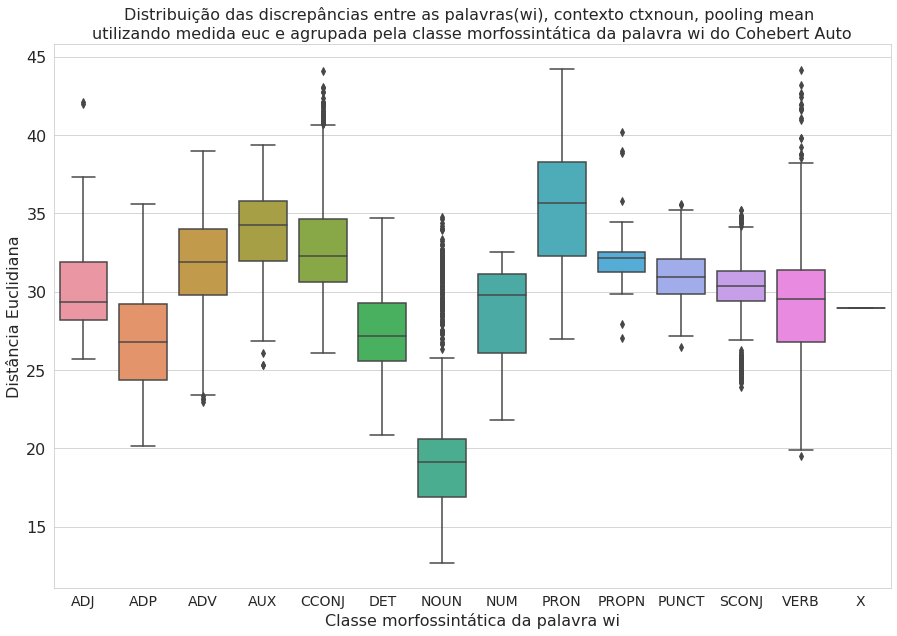

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 30.555732 4.002160 25.738346 28.200130 29.352474 31.932686   
ADP   1941.000000 26.821110 2.692756 20.185192 24.388575 26.811777 29.243032   
ADV   1252.000000 33.101624 2.138325 27.081339 31.281131 33.292322 34.821956   
AUX   1043.000000 33.785614 2.642849 25.340179 31.977725 34.283409 35.787245   
CCONJ 1415.000000 32.986079 3.342490 26.079859 30.656324 32.282375 34.663845   
DET   3485.000000 27.681843 2.712958 20.885464 25.705711 27.314840 29.488462   
NOUN  5375.000000 20.733264 4.471189 12.678500 17.179253 20.107666 22.267673   
NUM     12.000000 28.395225 3.724502 21.842068 26.106944 29.822087 31.157937   
PRON  2061.000000 35.298071 3.580443 26.955940 32.280704 35.655647 38.279682   
PROPN   28.000000 32.436880 2.953135 27.068554 31.236495 32.161182 32.546951   
PUNCT 2023.000000 31.042344 1.506527 26.487026 29.889235 30.916746 32.070692   
SCONJ  972.000000 30.099991 2.083090 23.906891 29.401928 30.372596 31.304335   
VERB  2279.000000 31.263539 2.745049 22.833176 29.330133 31.565228 33.074831   
X        1.000000 28.991760      NaN 28.991760 28.991760 28.991760 28.991760   

            max  
pos_i            
ADJ   42.141659  
ADP   35.633297  
ADV   39.014706  
AUX   39.341629  
CCONJ 44.097248  
DET   36.027664  
NOUN  34.779797  
NUM   32.528843  
PRON  44.229778  
PROPN 40.177643  
PUNCT 35.573391  
SCONJ 35.231834  
VERB  44.138630  
X     28.991760

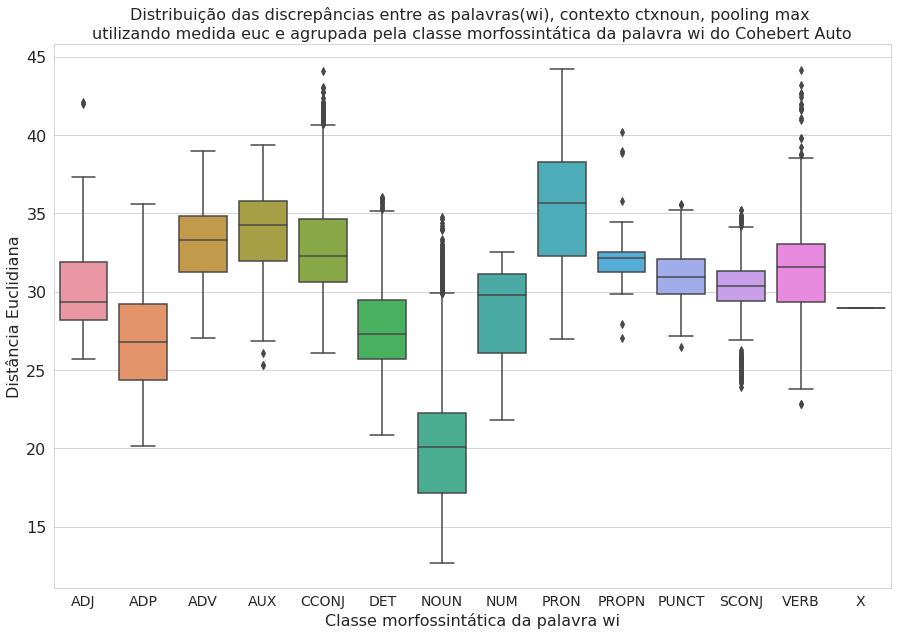

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1411.769117 117.107276 1186.749300 1343.026975 1388.336800   
ADP   1941.000000 1282.540121 123.601931 1004.520750 1165.233800 1272.688200   
ADV   1252.000000 1525.049974 173.300717 1083.605200 1450.117500 1564.136450   
AUX   1043.000000 1564.771950 105.320059 1220.643100 1497.132550 1594.807400   
CCONJ 1415.000000 1498.687687 115.228161 1262.225200 1402.570300 1505.011100   
DET   3485.000000 1292.058890 111.091000 1023.551100 1224.600100 1284.504500   
NOUN  5375.000000  878.594064 115.759959  579.876160  784.762175  882.309300   
NUM     12.000000 1395.342267 195.886307 1060.005100 1268.230900 1476.739500   
PRON  2061.000000 1674.295985 148.976249 1325.966600 1550.969200 1672.527600   
PROPN   28.000000 1502.288318  94.657812 1221.652800 1445.520800 1526.862600   
PUNCT 2023.000000 1498.157177  68.986195 1262.945800 1449.748350 1495.264900   
SCONJ  972.000000 1444.116464 103.654550 1158.540600 1399.275900 1464.871000   
VERB  2279.000000 1383.752296 151.110249  925.295600 1282.095800 1406.449600   
X        1.000000 1351.682900        NaN 1351.682900 1351.682900 1351.682900   

              75%         max  
pos_i                          
ADJ   1496.284675 1723.085400  
ADP   1394.504400 1705.830300  
ADV   1656.527150 1834.112300  
AUX   1635.134600 1787.670900  
CCONJ 1600.169450 1787.579800  
DET   1356.450300 1687.744600  
NOUN   949.294400 1439.157200  
NUM   1534.869725 1623.163600  
PRON  1813.936200 1993.807600  
PROPN 1559.288800 1644.955000  
PUNCT 1550.326600 1717.736300  
SCONJ 1503.804000 1717.485100  
VERB  1488.203050 1787.921500  
X     1351.682900 1351.682900

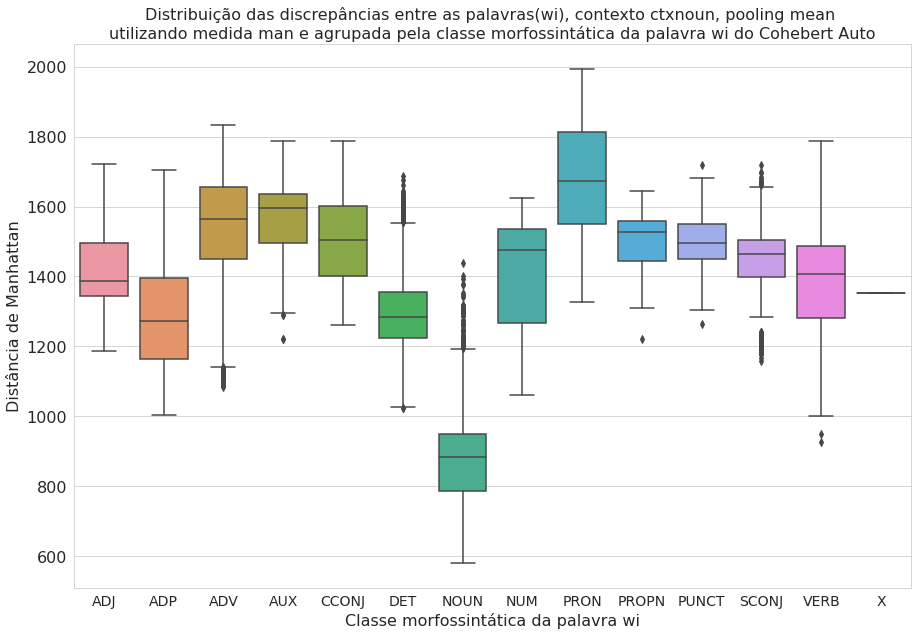

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1411.769117 117.107276 1186.749300 1343.026975 1388.336800   
ADP   1941.000000 1282.540121 123.601931 1004.520750 1165.233800 1272.688200   
ADV   1252.000000 1609.836922 103.898971 1280.820200 1507.572425 1630.573500   
AUX   1043.000000 1564.771950 105.320059 1220.643100 1497.132550 1594.807400   
CCONJ 1415.000000 1498.687687 115.228161 1262.225200 1402.570300 1505.011100   
DET   3485.000000 1303.957326 124.017462 1023.551100 1230.390900 1288.710000   
NOUN  5375.000000  948.266684 190.646567  579.876160  795.389975  913.871900   
NUM     12.000000 1395.342267 195.886307 1060.005100 1268.230900 1476.739500   
PRON  2061.000000 1674.295985 148.976249 1325.966600 1550.969200 1672.527600   
PROPN   28.000000 1502.288318  94.657812 1221.652800 1445.520800 1526.862600   
PUNCT 2023.000000 1498.157177  68.986195 1262.945800 1449.748350 1495.264900   
SCONJ  972.000000 1444.116464 103.654550 1158.540600 1399.275900 1464.871000   
VERB  2279.000000 1474.711508 110.254615 1088.467000 1400.753050 1496.259600   
X        1.000000 1351.682900        NaN 1351.682900 1351.682900 1351.682900   

              75%         max  
pos_i                          
ADJ   1496.284675 1723.085400  
ADP   1394.504400 1705.830300  
ADV   1693.849650 1834.112300  
AUX   1635.134600 1787.670900  
CCONJ 1600.169450 1787.579800  
DET   1363.605300 1804.298800  
NOUN  1039.479450 1632.805500  
NUM   1534.869725 1623.163600  
PRON  1813.936200 1993.807600  
PROPN 1559.288800 1644.955000  
PUNCT 1550.326600 1717.736300  
SCONJ 1503.804000 1717.485100  
VERB  1550.561050 1861.415000  
X     1351.682900 1351.682900

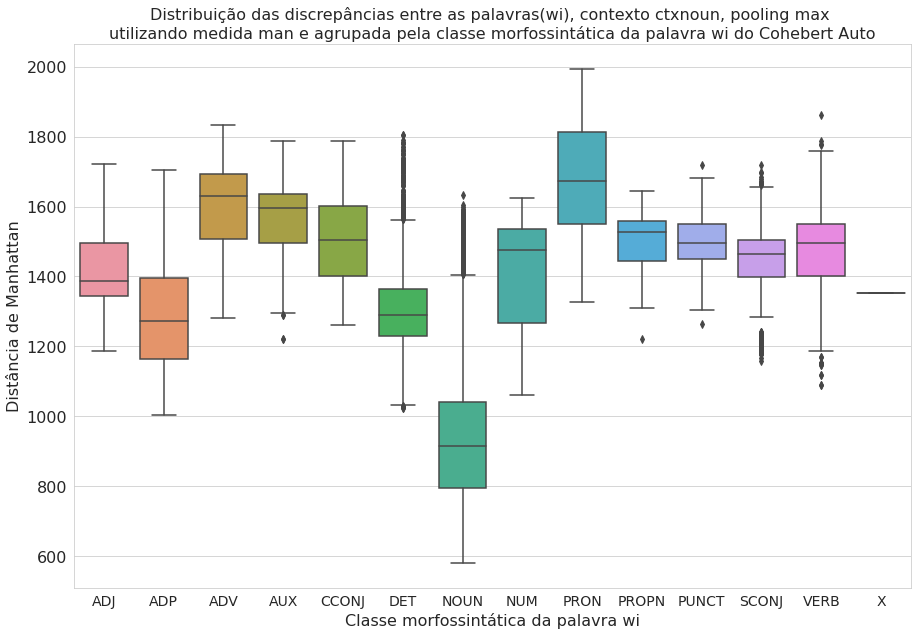

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.765876 0.024367 0.708960 0.757409 0.769697 0.783450   
ADP   1941.000000 0.778340 0.044091 0.662152 0.746979 0.787684 0.811643   
ADV   1252.000000 0.735264 0.037543 0.648762 0.708733 0.731862 0.755942   
AUX   1043.000000 0.787584 0.024524 0.728140 0.773441 0.783216 0.797408   
CCONJ 1415.000000 0.651059 0.173919 0.135959 0.685912 0.709281 0.731328   
DET   3485.000000 0.763568 0.043851 0.628912 0.740102 0.768681 0.796050   
NOUN  5375.000000 0.858321 0.026690 0.772730 0.839626 0.856426 0.875566   
NUM     12.000000 0.767263 0.046160 0.694772 0.740445 0.750646 0.788589   
PRON  2061.000000 0.679537 0.042966 0.563356 0.646532 0.675495 0.702287   
PROPN   28.000000 0.749702 0.030557 0.664614 0.737292 0.750551 0.761635   
PUNCT 2023.000000 0.709990 0.024031 0.618909 0.701019 0.714545 0.724535   
SCONJ  972.000000 0.731656 0.031044 0.668967 0.711349 0.724411 0.744482   
VERB  2279.000000 0.856914 0.033805 0.753798 0.826876 0.862804 0.883641   
X        1.000000 0.796270      NaN 0.796270 0.796270 0.796270 0.796270   

           max  
pos_i           
ADJ   0.801777  
ADP   0.867031  
ADV   0.838890  
AUX   0.925030  
CCONJ 0.809860  
DET   0.870029  
NOUN  0.941285  
NUM   0.852349  
PRON  0.815548  
PROPN 0.819220  
PUNCT 0.812572  
SCONJ 0.837159  
VERB  0.930165  
X     0.796270

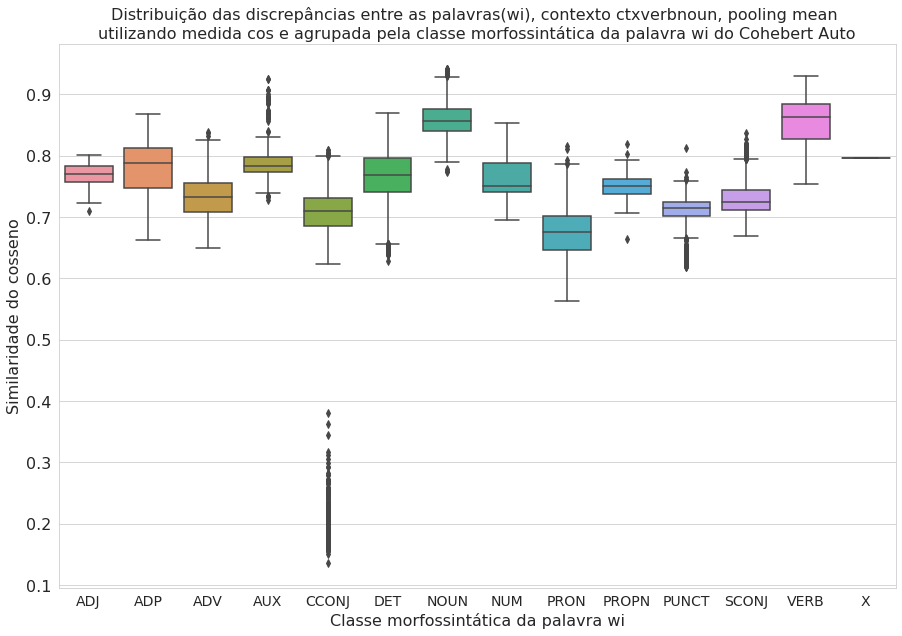

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     30.000000 0.765876 0.024367 0.708960 0.757409 0.769697 0.783450   
ADP   1941.000000 0.778340 0.044091 0.662152 0.746979 0.787684 0.811643   
ADV   1252.000000 0.710726 0.035963 0.605623 0.685957 0.717820 0.738014   
AUX   1043.000000 0.787584 0.024524 0.728140 0.773441 0.783216 0.797408   
CCONJ 1415.000000 0.651059 0.173919 0.135959 0.685912 0.709281 0.731328   
DET   3485.000000 0.760140 0.046574 0.597050 0.736663 0.765521 0.794311   
NOUN  5375.000000 0.840438 0.053649 0.657091 0.827836 0.852461 0.874195   
NUM     12.000000 0.767263 0.046160 0.694772 0.740445 0.750646 0.788589   
PRON  2061.000000 0.679537 0.042966 0.563356 0.646532 0.675495 0.702287   
PROPN   28.000000 0.749702 0.030557 0.664614 0.737292 0.750551 0.761635   
PUNCT 2023.000000 0.709990 0.024031 0.618909 0.701019 0.714545 0.724535   
SCONJ  972.000000 0.731656 0.031044 0.668967 0.711349 0.724411 0.744482   
VERB  2279.000000 0.823356 0.071255 0.641902 0.770351 0.846756 0.881470   
X        1.000000 0.796270      NaN 0.796270 0.796270 0.796270 0.796270   

           max  
pos_i           
ADJ   0.801777  
ADP   0.867031  
ADV   0.794348  
AUX   0.925030  
CCONJ 0.809860  
DET   0.870029  
NOUN  0.941285  
NUM   0.852349  
PRON  0.815548  
PROPN 0.819220  
PUNCT 0.812572  
SCONJ 0.837159  
VERB  0.930165  
X     0.796270

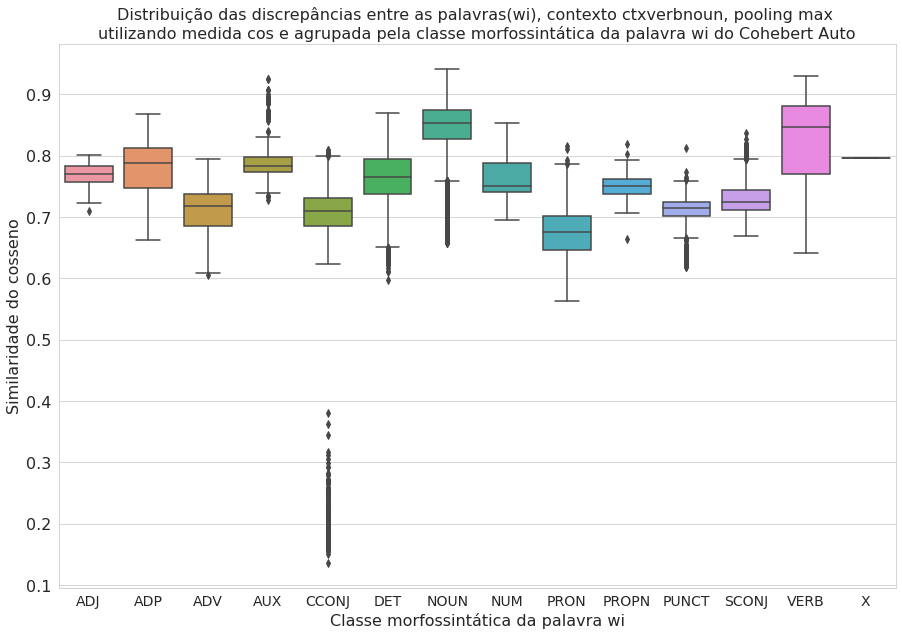

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 30.578706 3.963801 26.416708 28.271119 29.318293 31.927349   
ADP   1941.000000 25.917559 2.317230 20.185192 24.171894 25.600843 27.826664   
ADV   1252.000000 27.018006 2.626328 19.108879 25.702290 27.683544 28.798562   
AUX   1043.000000 24.467416 1.462676 15.920229 23.844907 24.686491 25.422729   
CCONJ 1415.000000 28.848941 3.709545 23.808069 26.659267 27.843868 29.041597   
DET   3485.000000 25.377909 2.512826 19.492069 23.626753 24.899021 26.474817   
NOUN  5375.000000 21.725588 3.369147 15.460507 19.811666 21.223385 22.626747   
NUM     12.000000 28.182731 4.044888 21.083164 25.755333 29.822087 31.157937   
PRON  2061.000000 30.157485 1.980267 26.086241 28.476278 29.748825 31.938873   
PROPN   28.000000 32.420989 2.984127 26.623606 31.236495 32.161182 32.546951   
PUNCT 2023.000000 28.265031 1.313927 25.152847 27.333664 28.080645 28.860540   
SCONJ  972.000000 27.427853 1.861223 22.057302 26.949343 27.833005 28.530423   
VERB  2279.000000 21.867594 3.330731 13.755853 19.219910 21.640041 24.057522   
X        1.000000 28.991760      NaN 28.991760 28.991760 28.991760 28.991760   

            max  
pos_i            
ADJ   42.141659  
ADP   34.746433  
ADV   32.677532  
AUX   28.303293  
CCONJ 40.750748  
DET   34.522652  
NOUN  36.320980  
NUM   32.528843  
PRON  36.959343  
PROPN 40.177643  
PUNCT 33.584991  
SCONJ 33.094662  
VERB  37.377960  
X     28.991760

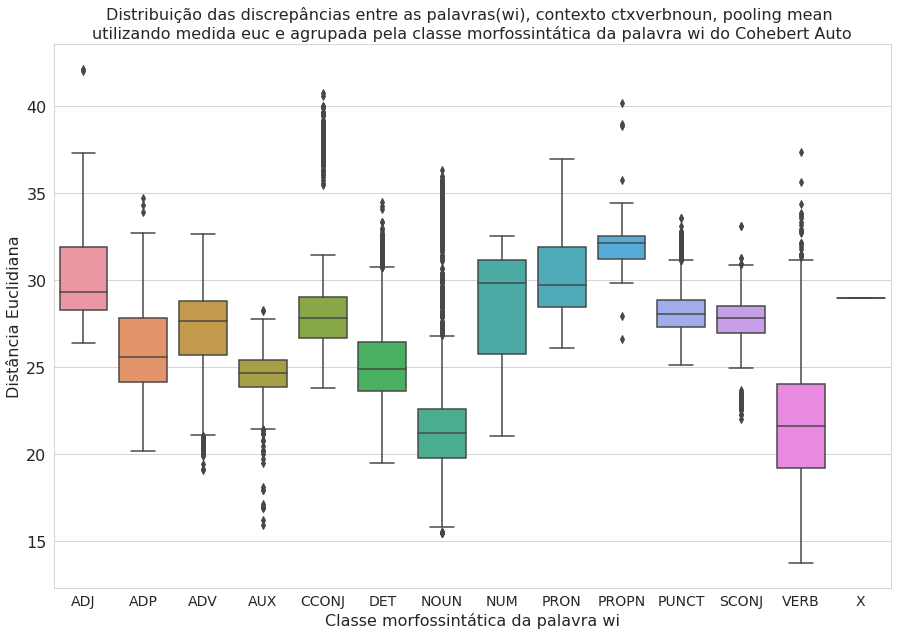

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     30.000000 30.578706 3.963801 26.416708 28.271119 29.318293 31.927349   
ADP   1941.000000 25.917559 2.317230 20.185192 24.171894 25.600843 27.826664   
ADV   1252.000000 28.734668 2.228391 24.490284 27.273481 28.369621 30.041992   
AUX   1043.000000 24.467416 1.462676 15.920229 23.844907 24.686491 25.422729   
CCONJ 1415.000000 28.848941 3.709545 23.808069 26.659267 27.843868 29.041597   
DET   3485.000000 25.625918 2.679641 19.492069 23.707172 25.013794 26.656950   
NOUN  5375.000000 23.018964 3.891432 15.460507 20.534684 21.996237 24.842813   
NUM     12.000000 28.182731 4.044888 21.083164 25.755333 29.822087 31.157937   
PRON  2061.000000 30.157485 1.980267 26.086241 28.476278 29.748825 31.938873   
PROPN   28.000000 32.420989 2.984127 26.623606 31.236495 32.161182 32.546951   
PUNCT 2023.000000 28.265031 1.313927 25.152847 27.333664 28.080645 28.860540   
SCONJ  972.000000 27.427853 1.861223 22.057302 26.949343 27.833005 28.530423   
VERB  2279.000000 24.208384 3.958987 15.222116 20.888187 24.408175 27.254613   
X        1.000000 28.991760      NaN 28.991760 28.991760 28.991760 28.991760   

            max  
pos_i            
ADJ   42.141659  
ADP   34.746433  
ADV   35.061817  
AUX   28.303293  
CCONJ 40.750748  
DET   35.397766  
NOUN  36.320980  
NUM   32.528843  
PRON  36.959343  
PROPN 40.177643  
PUNCT 33.584991  
SCONJ 33.094662  
VERB  37.377960  
X     28.991760

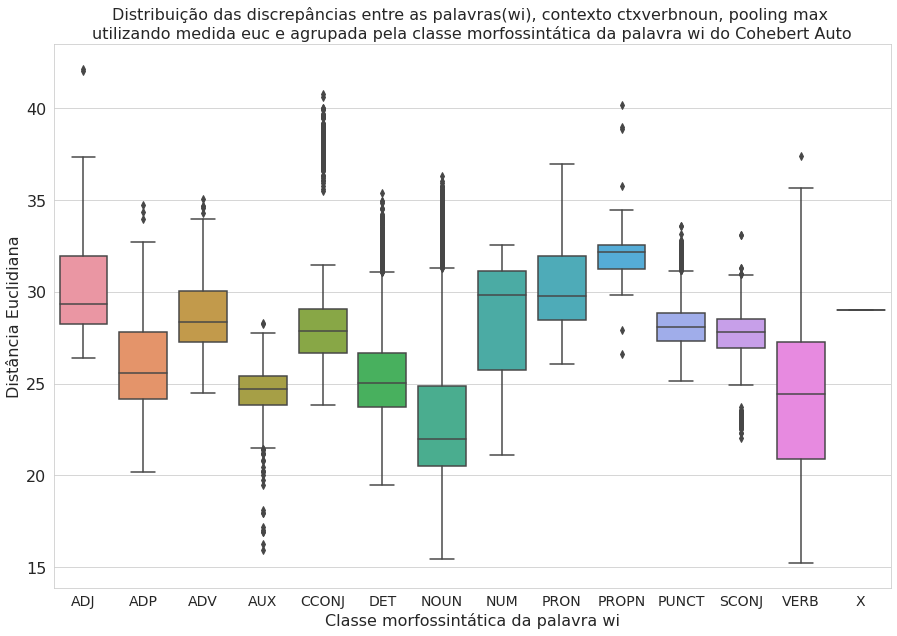

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1408.272760 113.175608 1234.622400 1340.191825 1376.263650   
ADP   1941.000000 1251.760847 105.412334 1004.520750 1168.640400 1237.599000   
ADV   1252.000000 1325.089316 136.904524  915.889100 1256.716575 1367.362550   
AUX   1043.000000 1128.781919  60.248201  770.128540 1099.299550 1133.256100   
CCONJ 1415.000000 1319.728557  76.753730 1143.481000 1261.794850 1323.740200   
DET   3485.000000 1208.240011 101.976507  957.730800 1142.517000 1184.894500   
NOUN  5375.000000  995.098499 103.706683  718.627440  922.735430  984.753970   
NUM     12.000000 1391.093358 202.237448 1053.835700 1259.892800 1476.739500   
PRON  2061.000000 1447.077366  83.753831 1276.280000 1376.938400 1420.824700   
PROPN   28.000000 1501.804896  96.166650 1208.117000 1445.520800 1526.862600   
PUNCT 2023.000000 1378.184058  49.160588 1223.629400 1346.442650 1375.668300   
SCONJ  972.000000 1325.045725  83.197864 1082.574500 1285.021875 1351.191150   
VERB  2279.000000 1026.395377 147.634832  667.484000  901.833250 1023.523560   
X        1.000000 1351.682900        NaN 1351.682900 1351.682900 1351.682900   

              75%         max  
pos_i                          
ADJ   1495.934500 1723.085400  
ADP   1334.230700 1705.830300  
ADV   1415.525675 1576.053700  
AUX   1166.439150 1298.280000  
CCONJ 1380.188800 1515.197400  
DET   1249.806400 1687.744600  
NOUN  1063.349150 1439.157200  
NUM   1534.869725 1623.163600  
PRON  1527.109100 1645.385000  
PROPN 1559.288800 1644.955000  
PUNCT 1405.192150 1549.771500  
SCONJ 1379.341700 1534.176300  
VERB  1134.031500 1442.134400  
X     1351.682900 1351.682900

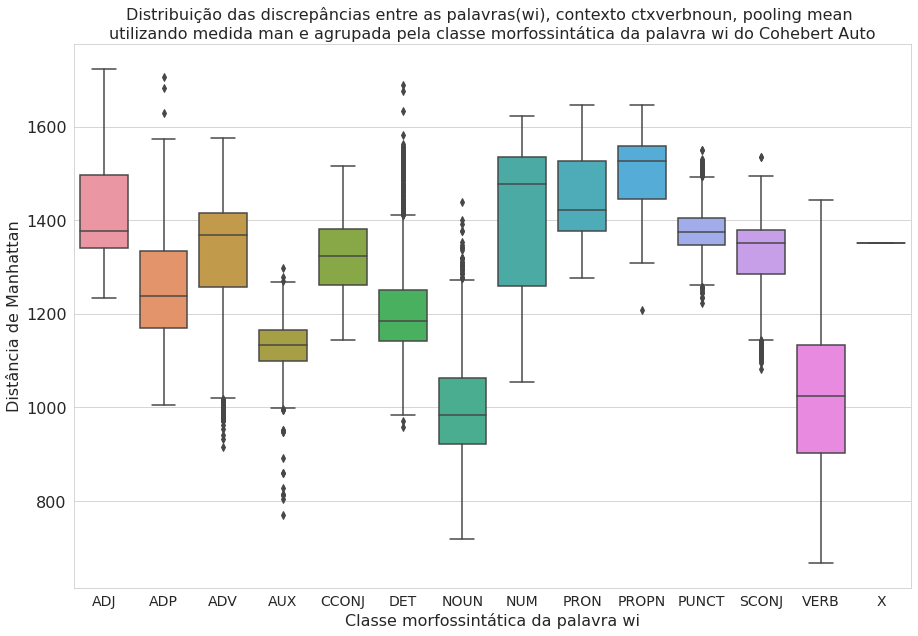

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     30.000000 1408.272760 113.175608 1234.622400 1340.191825 1376.263650   
ADP   1941.000000 1251.760847 105.412334 1004.520750 1168.640400 1237.599000   
ADV   1252.000000 1414.552918 112.282819 1208.789300 1349.084400 1396.871850   
AUX   1043.000000 1128.781919  60.248201  770.128540 1099.299550 1133.256100   
CCONJ 1415.000000 1319.728557  76.753730 1143.481000 1261.794850 1323.740200   
DET   3485.000000 1221.225414 117.598386  984.296630 1146.093500 1188.581000   
NOUN  5375.000000 1060.869195 158.973449  718.627440  951.998900 1028.011000   
NUM     12.000000 1391.093358 202.237448 1053.835700 1259.892800 1476.739500   
PRON  2061.000000 1447.077366  83.753831 1276.280000 1376.938400 1420.824700   
PROPN   28.000000 1501.804896  96.166650 1208.117000 1445.520800 1526.862600   
PUNCT 2023.000000 1378.184058  49.160588 1223.629400 1346.442650 1375.668300   
SCONJ  972.000000 1325.045725  83.197864 1082.574500 1285.021875 1351.191150   
VERB  2279.000000 1138.658951 174.697874  725.644800  990.471220 1151.792500   
X        1.000000 1351.682900        NaN 1351.682900 1351.682900 1351.682900   

              75%         max  
pos_i                          
ADJ   1495.934500 1723.085400  
ADP   1334.230700 1705.830300  
ADV   1475.594725 1739.959100  
AUX   1166.439150 1298.280000  
CCONJ 1380.188800 1515.197400  
DET   1255.867400 1759.901900  
NOUN  1145.975000 1613.480100  
NUM   1534.869725 1623.163600  
PRON  1527.109100 1645.385000  
PROPN 1559.288800 1644.955000  
PUNCT 1405.192150 1549.771500  
SCONJ 1379.341700 1534.176300  
VERB  1282.281150 1659.436400  
X     1351.682900 1351.682900

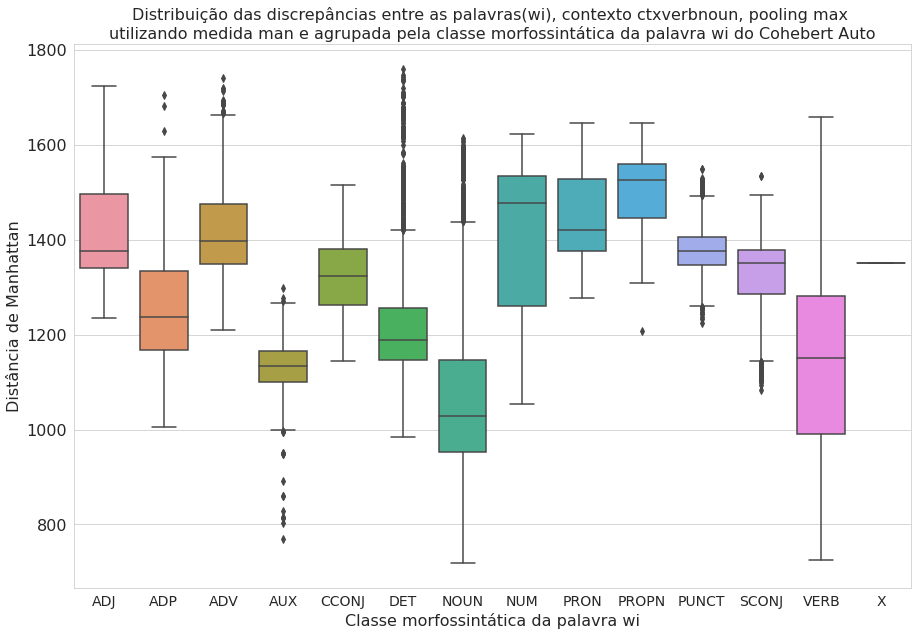

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/21917 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

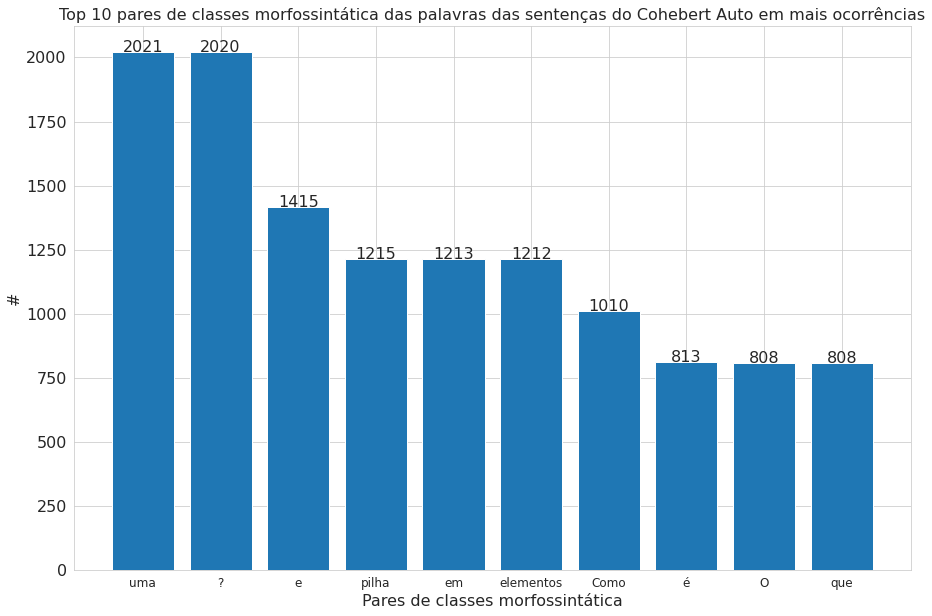

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2279


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count      2279.000000      2279.000000     2279.000000     2279.000000   
mean          0.819974        24.201168     1252.006997        0.786768   
std           0.048651         5.477122      117.898200        0.037135   
min           0.685184        10.615781      902.745000        0.668772   
25%           0.789898        21.897848     1172.787400        0.753431   
50%           0.807066        24.714891     1269.337000        0.791165   
75%           0.844968        27.744214     1320.557350        0.811907   
max           0.957184        42.533066     1618.837900        0.881739   

       euc_ctxall_max  man_ctxall_max  
count     2279.000000     2279.000000  
mean        26.700565     1252.006997  
std          3.118810      117.898200  
min         18.909819      902.745000  
25%         24.608233     1172.787400  
50%         26.719694     1269.337000  
75%         27.972569     1320.557350  
max         42.533066     1618.837900

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2279 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  761
      2        1  682
      3        6  311
      4        3  202
      5        2  202
      6        8  119
      7        9    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05507028102874756
Limite superior             : 0.9275732040405273
Limite inferior             : 0.7072920799255371


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 96 de 2279 ( 0.04212373848179026 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 2279 ( 0.002193944712593243 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  101 de 2279 ( 0.0443176831943835 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9571844339370728 enfileirar
         Como enfileirar elementos em uma fila?

 2 0.9465148448944092 empilhar
         Como empilhar e desempilhar elementos em uma pilha?

 3 0.9451144933700562 desenfileirar
         Como desenfileirar elementos em uma fila?

 4 0.939832329750061 empilhar
         Como empilhar elementos em uma pilha?

 5 0.9376590251922609 empilhar
         Como empilhar e compartilhar elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6851843595504761 fechar
         Como são implementadas as operações de empilhar e fechar elementos em uma pilha ?

 2 0.6974233984947205 remover
         Como são implementadas as operações de empilhar e remover elementos em uma pilha ?

 3 0.699866771697998 pôr
         Como são implementadas as operações de empilhar e pôr elementos em uma pilha ?

 4 0.703540563583374 retirar
         Como empilhar e retirar elementos em uma estrutura de dados pilha ?

 5 0.7037439942359924 colar
         Como são implementadas as operações de empilhar e colar elementos em uma pilha ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e colar elementos em uma pilha ?
       1 0.8736457228660583 empilhar
       2 0.8074343800544739 implementadas
       3 0.7037439942359924 colar

 2 Como empilhar e retirar elementos em uma estrutura de dados pilha ?
       1 0.8900664448738098 empilhar
       2 0.703540563583374 retirar

 3 Como são implementadas as operações de empilhar e pôr elementos em uma pilha ?
       1 0.8815571069717407 empilhar
       2 0.8029669523239136 implementadas
       3 0.699866771697998 pôr

 4 Como são implementadas as operações de empilhar e remover elementos em uma pilha ?
       1 0.8774881362915039 empilhar
       2 0.806788444519043 implementadas
       3 0.6974233984947205 remover

 5 Como são implementadas as operações de empilhar e fechar elementos em uma pilha ?
       1 0.8756972551345825 empilhar
       2 0.8036832809448242 implementadas
       3 0.6851843595504761 fechar


##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05847594141960144
Limite superior             : 0.8996207267045975
Limite inferior             : 0.6657169610261917


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.846365928649902
Limite superior             : 36.51376295089722
Limite inferior             : 13.128299236297607


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 20 de 2279 ( 0.008775778850372971 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 85 de 2279 ( 0.03729706011408512 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  105 de 2279 ( 0.046072838964458095 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.53306579589844 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 2 41.58507537841797 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?

 3 41.16701889038086 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 4 41.04480743408203 ocorrem
         Em uma fila a operação de enfileirar ocorrem em qual extremidade ?

 5 40.99627304077149 foca
         Em uma fila a operação de enfileirar foca em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.6157808303833 enfileirar
         Como enfileirar elementos em uma fila?

 2 11.340407371520996 empilhar
         Como empilhar e desempilhar elementos em uma pilha?

 3 11.720062255859377 desenfileirar
         Como desenfileirar elementos em uma fila?

 4 12.184850692749023 empilhar
         Como empilhar elementos em uma pilha?

 5 12.234696388244627 empilhar
         Como empilhar e dividir elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 42.53306579589844 Ocorre
       2 15.915796279907228 enfileirar

 2 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 41.58507537841797 acontecem
       2 16.141284942626953 enfileirar

 3 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 41.16701889038086 catar
       2 24.552141189575195 implementadas

 4 Em uma fila a operação de enfileirar ocorrem em qual extremidade ?
       1 41.04480743408203 ocorrem
       2 15.964258193969728 enfileirar

 5 Em uma fila a operação de enfileirar foca em qual extremidade ?
       1 40.99627304077149 foca
       2 16.04340934753418 enfileirar


##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.3643360137939453
Limite superior             : 33.019073486328125
Limite inferior             : 19.561729431152344


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 77 de 2279 ( 0.03378674857393594 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 10 de 2279 ( 0.004387889425186486 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  87 de 2279 ( 0.03817463799912242 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.53306579589844 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 2 41.58507537841797 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?

 3 41.16701889038086 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 4 41.04480743408203 ocorrem
         Em uma fila a operação de enfileirar ocorrem em qual extremidade ?

 5 40.99627304077149 foca
         Em uma fila a operação de enfileirar foca em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 18.909818649291992 criar
         Como criar elementos em uma fila ?

 2 18.909818649291992 criar
         Como criar elementos em uma fila ?

 3 19.084943771362305 deixar
         Como deixar elementos em uma fila ?

 4 19.084943771362305 deixar
         Como deixar elementos em uma fila ?

 5 19.36342430114746 fazer
         Como fazer elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 42.53306579589844 Ocorre
       2 26.51949119567871 enfileirar

 2 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 41.58507537841797 acontecem
       2 27.018325805664062 enfileirar

 3 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 41.16701889038086 catar
       2 28.131820678710938 implementadas

 4 Em uma fila a operação de enfileirar ocorrem em qual extremidade ?
       1 41.04480743408203 ocorrem
       2 26.91748046875 enfileirar

 5 Em uma fila a operação de enfileirar foca em qual extremidade ?
       1 40.99627304077149 foca
       2 26.391143798828125 enfileirar


##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 238.87165000000005
Limite superior             : 1647.308925
Limite inferior             : 691.8223249999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 109 de 2279 ( 0.04782799473453269 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  109 de 2279 ( 0.04782799473453269 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 524.86475 enfileirar
         Como enfileirar elementos em uma fila?

 2 549.6356 empilhar
         Como empilhar e desempilhar elementos em uma pilha?

 3 580.03204 desenfileirar
         Como desenfileirar elementos em uma fila?

 4 595.4082 empilhar
         Como empilhar e organizar elementos em uma pilha ?

 5 596.13135 empilhar
         Como empilhar e dividir elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 147.7699500000001
Limite superior             : 1542.2122750000003
Limite inferior             : 951.1324749999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 20 de 2279 ( 0.008775778850372971 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 10 de 2279 ( 0.004387889425186486 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  30 de 2279 ( 0.013163668275559455 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1618.8379 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?

 2 1595.7881 pôr
         Como são implementadas as operações de empilhar e pôr elementos em uma pilha ?

 3 1592.9059 desenfileirar
         Como são implementadas as operações de deixar e desenfileirar elementos em uma fila ?

 4 1589.4563 desenfileirar
         Como são implementadas as operações de concentrar e desenfileirar elementos em uma fila ?

 5 1582.1062 desenfileirar
         Como são implementadas as operações de colocar e desenfileirar elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 902.745 deixar
         Como deixar elementos em uma fila ?

 2 902.745 deixar
         Como deixar elementos em uma fila ?

 3 908.5054 criar
         Como criar elementos em uma fila ?

 4 908.5054 criar
         Como criar elementos em uma fila ?

 5 930.6038 gravar
         Como gravar elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1618.8379 desempilhar
       2 1333.1119 implementadas
       3 1266.0807 empilhar

 2 Como são implementadas as operações de empilhar e pôr elementos em uma pilha ?
       1 1595.7881 pôr
       2 1312.4646 implementadas
       3 1289.8594 empilhar

 3 Como são implementadas as operações de deixar e desenfileirar elementos em uma fila ?
       1 1592.9059 desenfileirar
       2 1487.6356 deixar
       3 1304.3243 implementadas

 4 Como são implementadas as operações de concentrar e desenfileirar elementos em uma fila ?
       1 1589.4563 desenfileirar
       2 1390.5891 concentrar
       3 1303.3794 implementadas

 5 Como são implementadas as operações de colocar e desenfileirar elementos em uma fila ?
       1 1582.1062 desenfileirar
       2 1394.6836 colocar
       3 1275.2861 implementadas


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5375


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count      5375.000000      5375.000000      5375.000000     5375.000000   
mean          0.812701        24.520707      1118.128847        0.794559   
std           0.039115         4.927789       168.868847        0.033865   
min           0.721621        11.953954       583.641850        0.679519   
25%           0.782047        21.451769      1021.496735        0.769793   
50%           0.809626        24.368387      1139.305500        0.792347   
75%           0.837875        26.791040      1239.150650        0.820864   
max           0.942692        40.800144      1732.394800        0.869701   

       euc_ctxall_max  man_ctxall_max  
count     5375.000000     5375.000000  
mean        25.905965     1186.798264  
std          3.871573      130.918150  
min         19.250891      908.613650  
25%         23.275522     1084.764550  
50%         25.496927     1183.171100  
75%         27.279756     1270.942850  
max         40.800144     1732.394800

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5375 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1005
      3        2  808
      4        5  606
      5        7  443
      6       10  303
      7       11  202
      8       12  202
      9        8  196
     10        1  104
     11        6   92


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05582880973815918
Limite superior             : 0.9216186702251434
Limite inferior             : 0.6983034312725067


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 5375 ( 0.00018604651162790697 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 5375 ( 0.00018604651162790697 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9426923394203186 desempilhar
         Como desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05107089877128601
Limite superior             : 0.897470161318779
Limite inferior             : 0.693186566233635


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 24 de 5375 ( 0.004465116279069767 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  24 de 5375 ( 0.004465116279069767 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6795193552970886 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 2 0.6828426122665405 desempilhar
         O que é uma pilha e como proteger e desempilhar seus elementos ?

 3 0.6840636730194092 desempilhar
         O que é uma pilha e como ligar e desempilhar seus elementos ?

 4 0.6843565702438354 desempilhar
         O que é uma pilha e como montar e desempilhar seus elementos ?

 5 0.6850960850715637 desempilhar
         O que é uma pilha e como instalar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como dividir e desempilhar seus elementos ?
       1 0.7728803753852844 elementos
       2 0.7539646625518799 pilha
       3 0.6931641101837158 desempilhar

 2 O que é uma pilha e como remover e desempilhar seus elementos ?
       1 0.7685076594352722 elementos
       2 0.75485759973526 pilha
       3 0.6929011344909668 desempilhar

 3 O que é uma pilha e como produzir e desempilhar seus elementos ?
       1 0.7708187699317932 elementos
       2 0.7552807927131653 pilha
       3 0.6924325823783875 desempilhar

 4 O que é uma pilha e como parar e desempilhar seus elementos ?
       1 0.7723686695098877 elementos
       2 0.7607492208480835 pilha
       3 0.6917374134063721 desempilhar

 5 O que é uma pilha e como organizar e desempilhar seus elementos ?
       1 0.7742305397987366 elementos
       2 0.7600551247596741 pilha
       3 0.6916956305503845 desempilhar


##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.339271545410156
Limite superior             : 34.79994773864746
Limite inferior             : 13.442861557006836


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 293


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 5375 ( 0.00018604651162790697 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  294 de 5375 ( 0.05469767441860465 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.80014419555664 elemento
         O que é uma fila e como acontece seu elemento ?

 2 40.35565185546875 elemento
         O que é uma fila e como fazer seu elemento ?

 3 39.97032928466797 elemento
         O que é uma fila e como ocorre seu elemento ?

 4 39.8787956237793 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 5 39.7569694519043 pilha
         Como empilhar e reunir elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.953953742980955 desempilhar
         Como desempilhar elementos em uma pilha?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como acontece seu elemento ?
       1 40.80014419555664 elemento
       2 22.28662109375 fila

 2 O que é uma fila e como fazer seu elemento ?
       1 40.35565185546875 elemento
       2 21.971080780029297 fila

 3 O que é uma fila e como ocorre seu elemento ?
       1 39.97032928466797 elemento
       2 22.241077423095703 fila

 4 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 39.8787956237793 pilha
       2 23.43613815307617 dados
       3 22.156768798828125 elementos
       4 20.88380241394043 estrutura

 5 Como empilhar e reunir elementos em uma estrutura de dados pilha ?
       1 39.7569694519043 pilha
       2 23.63146209716797 dados
       3 22.52154922485352 elementos
       4 21.2021598815918 estrutura


##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.004233360290527
Limite superior             : 33.28610563278198
Limite inferior             : 17.269172191619873


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 346


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  346 de 5375 ( 0.06437209302325582 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.80014419555664 elemento
         O que é uma fila e como acontece seu elemento ?

 2 40.35565185546875 elemento
         O que é uma fila e como fazer seu elemento ?

 3 39.97032928466797 elemento
         O que é uma fila e como ocorre seu elemento ?

 4 39.8787956237793 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 5 39.7569694519043 pilha
         Como empilhar e reunir elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como acontece seu elemento ?
       1 40.80014419555664 elemento
       2 26.64636993408203 fila

 2 O que é uma fila e como fazer seu elemento ?
       1 40.35565185546875 elemento
       2 26.316545486450195 fila

 3 O que é uma fila e como ocorre seu elemento ?
       1 39.97032928466797 elemento
       2 26.599288940429688 fila

 4 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 39.8787956237793 pilha
       2 23.43613815307617 dados
       3 22.156768798828125 elementos
       4 20.88380241394043 estrutura

 5 Como empilhar e reunir elementos em uma estrutura de dados pilha ?
       1 39.7569694519043 pilha
       2 23.63146209716797 dados
       3 22.52154922485352 elementos
       4 21.2021598815918 estrutura


##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 217.6539150000001
Limite superior             : 1565.6315225000003
Limite inferior             : 695.0158624999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 10


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 5375 ( 0.0009302325581395349 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  15 de 5375 ( 0.0027906976744186047 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1732.3948 pilha
         Como desempilhar elementos em uma estrutura de longa pilha ?

 2 1695.8132 pilha
         Como desempilhar elementos em uma estrutura de contra pilha ?

 3 1689.0984 pilha
         Como desempilhar elementos em uma estrutura de última pilha ?

 4 1634.1776 pilha
         Como desempilhar elementos em uma estrutura de baixo pilha ?

 5 1618.1323 pilha
         Como desempilhar elementos em uma estrutura de sol pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 583.64185 desempilhar
         Como desempilhar elementos em uma pilha?

 2 675.4204 desempilhar
         Como desempilhar elementos em uma estrutura de trabalho pilha ?

 3 689.36707 desempilhar
         Como desempilhar elementos em uma estrutura de garra pilha ?

 4 692.3602 desempilhar
         Como desempilhar elementos em uma estrutura de dados pilha?

 5 692.3602 desempilhar
         Como desempilhar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de longa pilha ?
       1 1732.3948 pilha
       2 1085.9382 elementos
       3 956.2438 estrutura
       4 732.80054 desempilhar

 2 Como desempilhar elementos em uma estrutura de contra pilha ?
       1 1695.8132 pilha
       2 1091.436 elementos
       3 993.65063 estrutura
       4 745.10583 desempilhar

 3 Como desempilhar elementos em uma estrutura de última pilha ?
       1 1689.0984 pilha
       2 1067.8718 elementos
       3 962.4668 estrutura
       4 713.6356 desempilhar

 4 Como desempilhar elementos em uma estrutura de baixo pilha ?
       1 1634.1776 pilha
       2 1053.1139 elementos
       3 979.3666 estrutura
       4 732.0443 desempilhar

 5 Como desempilhar elementos em uma estrutura de sol pilha ?
       1 1618.1323 pilha
       2 1385.5907 sol
       3 1045.1747 elementos
       4 995.2839 estrutura
       5 725.933 desempilhar


##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 186.1782999999998
Limite superior             : 1550.2102999999997
Limite inferior             : 805.4971000000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 24


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  24 de 5375 ( 0.004465116279069767 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1732.3948 pilha
         Como desempilhar elementos em uma estrutura de longa pilha ?

 2 1695.8132 pilha
         Como desempilhar elementos em uma estrutura de contra pilha ?

 3 1689.0984 pilha
         Como desempilhar elementos em uma estrutura de última pilha ?

 4 1634.1776 pilha
         Como desempilhar elementos em uma estrutura de baixo pilha ?

 5 1618.1323 pilha
         Como desempilhar elementos em uma estrutura de sol pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de longa pilha ?
       1 1732.3948 pilha
       2 1294.9998 desempilhar
       3 1085.9382 elementos
       4 956.2438 estrutura

 2 Como desempilhar elementos em uma estrutura de contra pilha ?
       1 1695.8132 pilha
       2 1346.8678 desempilhar
       3 1091.436 elementos
       4 993.65063 estrutura

 3 Como desempilhar elementos em uma estrutura de última pilha ?
       1 1689.0984 pilha
       2 1288.7385 desempilhar
       3 1067.8718 elementos
       4 962.4668 estrutura

 4 Como desempilhar elementos em uma estrutura de baixo pilha ?
       1 1634.1776 pilha
       2 1270.968 desempilhar
       3 1053.1139 elementos
       4 979.3666 estrutura

 5 Como desempilhar elementos em uma estrutura de sol pilha ?
       1 1618.1323 pilha
       2 1385.5907 sol
       3 1260.4814 desempilhar
       4 1045.1747 elementos
       5 995.2839 estrutura


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count    21917.000000    21917.000000    21917.000000     2279.000000   
mean         0.817198       22.910169     1093.198488        0.819974   
std          0.063524        3.930319      148.447413        0.048651   
min          0.182750       10.615781      524.864750        0.685184   
25%          0.796086       20.661455     1011.452300        0.789898   
50%          0.823620       22.179934     1084.444200        0.807066   
75%          0.845695       24.812683     1172.753900        0.844968   
max          0.957184       42.533066     1732.394800        0.957184   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count     2279.000000     2279.000000     5375.000000     5375.000000   
mean        24.201168     1131.283844        0.812701       24.520707   
std          5.477122      226.168059        0.039115        4.927789   
min         10.615781      524.864750        0.721621       11.953954   
25%         21.897848     1050.129800        0.782047       21.451769   
50%         24.714891     1164.963100        0.809626       24.368387   
75%         27.744214     1289.001450        0.837875       26.791040   
max         42.533066     1595.788100        0.942692       40.800144   

                       
      man_ctxall_mean  
count     5375.000000  
mean      1118.128847  
std        168.868847  
min        583.641850  
25%       1021.496735  
50%       1139.305500  
75%       1239.150650  
max       1732.394800

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count    21917.000000     2279.000000     5375.000000
mean         0.817198        0.819974        0.812701
std          0.063524        0.048651        0.039115
min          0.182750        0.685184        0.721621
25%          0.796086        0.789898        0.782047
50%          0.823620        0.807066        0.809626
75%          0.845695        0.844968        0.837875
max          0.957184        0.957184        0.942692

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


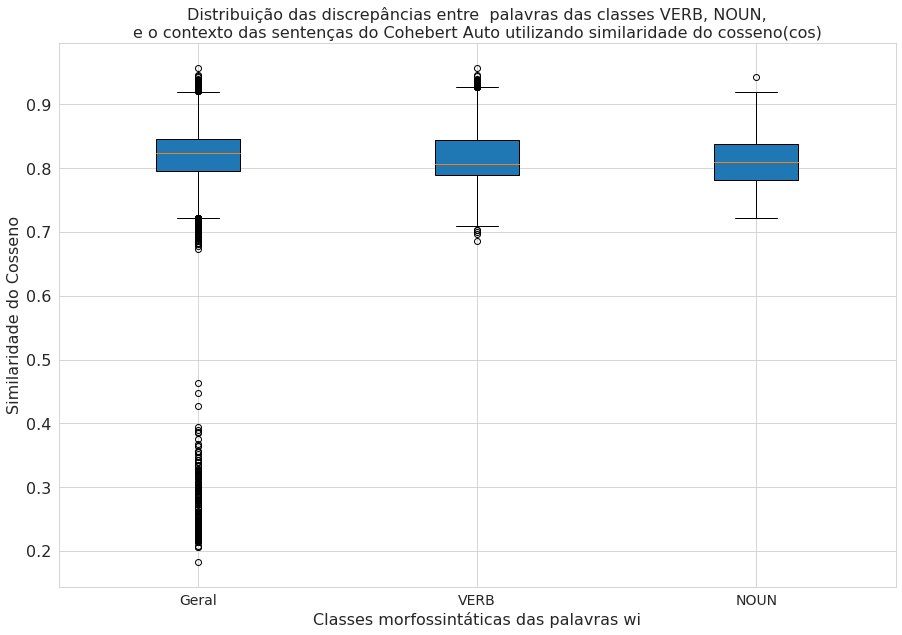

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count    21917.000000     2279.000000     5375.000000
mean        22.910169       24.201168       24.520707
std          3.930319        5.477122        4.927789
min         10.615781       10.615781       11.953954
25%         20.661455       21.897848       21.451769
50%         22.179934       24.714891       24.368387
75%         24.812683       27.744214       26.791040
max         42.533066       42.533066       40.800144

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


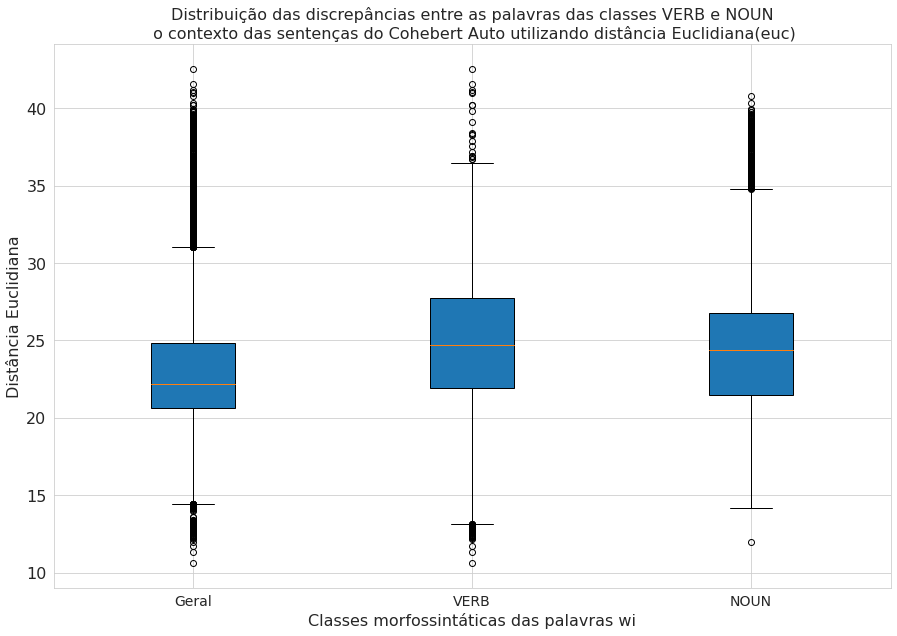

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count    21917.000000     2279.000000     5375.000000
mean      1093.198488     1131.283844     1118.128847
std        148.447413      226.168059      168.868847
min        524.864750      524.864750      583.641850
25%       1011.452300     1050.129800     1021.496735
50%       1084.444200     1164.963100     1139.305500
75%       1172.753900     1289.001450     1239.150650
max       1732.394800     1595.788100     1732.394800

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


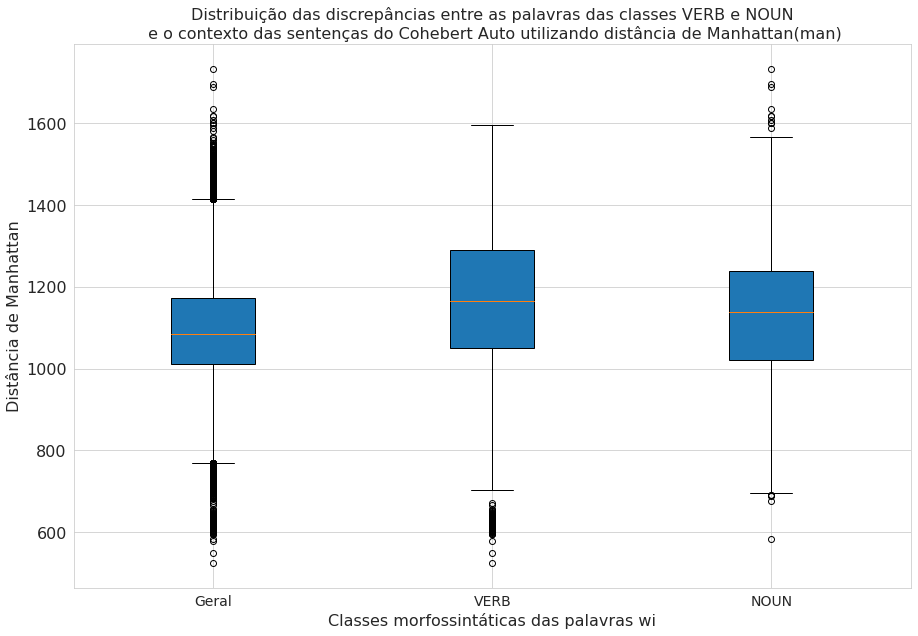

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2279


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        2279.000000        2279.000000       2279.000000   
mean            0.846916          22.558524          0.813722   
std             0.034573           3.520395          0.065870   
min             0.689588          13.929336          0.644451   
25%             0.823173          20.030607          0.753394   
50%             0.855841          22.614470          0.832398   
75%             0.872542          24.764598          0.868258   
max             0.923698          38.542923          0.912413   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       2279.000000       2279.000000        2279.000000  
mean          24.890378       1175.289033        1064.077674  
std            3.528929        155.545696         153.757357  
min           16.645187        803.258200         681.581670  
25%           21.919596       1046.832950         951.481730  
50%           25.010851       1183.867400        1077.826300  
75%           27.666562       1304.400250        1171.523900  
max           38.542923       1654.705700        1620.444600

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2279 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  761
      2        1  682
      3        6  311
      4        3  202
      5        2  202
      6        8  119
      7        9    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04936966300010681
Limite superior             : 0.9465966671705246
Limite inferior             : 0.7491180151700974


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 18 de 2279 ( 0.007898200965335674 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  18 de 2279 ( 0.007898200965335674 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6895875930786133 fazer
         Como são implementadas as operações de fazer e desenfileirar elementos em uma fila ?

 2 0.7058526277542114 partir
         Como são implementadas as operações de partir e desenfileirar elementos em uma fila ?

 3 0.7192346453666687 fazer
         O que é uma pilha e como fazer e desempilhar seus elementos ?

 4 0.7256898283958435 ver
         Como empilhar e ver elementos em uma pilha ?

 5 0.7320061922073364 vem
         O que é uma pilha e como vem seu elemento ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ver elementos em uma pilha ?
       1 0.7482045888900757 ver

 2 Como ver elementos em uma pilha ?
       1 0.7482045888900757 ver

 3 Como empilhar e usar elementos em uma estrutura de dados pilha ?
       1 0.8479259610176086 empilhar
       2 0.747275173664093 usar

 4 O que é uma pilha e como tem um elemento nela ?
       1 0.7471819519996643 tem

 5 O que é uma pilha e como usar e desempilhar seus elementos ?
       1 0.7470457553863525 usar


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.11486396193504333
Limite superior             : 1.0405541509389877
Limite inferior             : 0.5810983031988144


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.733990669250488
Limite superior             : 31.865583896636963
Limite inferior             : 12.92962121963501


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 31 de 2279 ( 0.013602457218078104 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  31 de 2279 ( 0.013602457218078104 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.54292297363281 fará
         Em uma fila a operação de enfileirar fará em qual extremidade ?

 2 37.59236145019531 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 3 37.26066207885742 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 4 37.02384567260742 faz
         Em uma fila a operação de enfileirar faz em qual extremidade ?

 5 36.39128875732422 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar fará em qual extremidade ?
       1 38.54292297363281 fará
       2 18.732425689697266 enfileirar

 2 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 37.59236145019531 Ocorre
       2 20.45061492919922 enfileirar

 3 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 37.26066207885742 catar
       2 25.363319396972656 implementadas

 4 Em uma fila a operação de enfileirar faz em qual extremidade ?
       1 37.02384567260742 faz
       2 18.69098854064941 enfileirar

 5 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 36.39128875732422 acontecem
       2 20.86969566345215 enfileirar


##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.746966361999512
Limite superior             : 36.28701162338257
Limite inferior             : 13.299146175384521


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 5 de 2279 ( 0.002193944712593243 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 2279 ( 0.002193944712593243 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.54292297363281 fará
         Em uma fila a operação de enfileirar fará em qual extremidade ?

 2 37.59236145019531 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 3 37.26066207885742 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 4 37.02384567260742 faz
         Em uma fila a operação de enfileirar faz em qual extremidade ?

 5 36.39128875732422 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar fará em qual extremidade ?
       1 38.54292297363281 fará
       2 29.105098724365234 enfileirar

 2 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 37.59236145019531 Ocorre
       2 29.896848678588867 enfileirar

 3 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 37.26066207885742 catar
       2 28.876245498657227 implementadas

 4 Em uma fila a operação de enfileirar faz em qual extremidade ?
       1 37.02384567260742 faz
       2 29.232789993286133 enfileirar

 5 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 36.39128875732422 acontecem
       2 30.58524513244629 enfileirar


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 220.04217000000017
Limite superior             : 1501.5871550000004
Limite inferior             : 621.4184749999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 11 de 2279 ( 0.004826678367705134 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  11 de 2279 ( 0.004826678367705134 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1620.4446 fazer
         Como são implementadas as operações de fazer e desenfileirar elementos em uma fila ?

 2 1586.948 falta
         O que é uma pilha e como falta um elemento nela ?

 3 1561.719 vem
         O que é uma pilha e como vem seu elemento ?

 4 1559.8933 vem
         O que é uma fila e como vem um elemento nela ?

 5 1558.3999 vem
         O que é uma pilha e como vem um elemento nela ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de fazer e desenfileirar elementos em uma fila ?
       1 1620.4446 fazer
       2 1089.1707 implementadas

 2 O que é uma pilha e como falta um elemento nela ?
       1 1586.948 falta

 3 O que é uma pilha e como vem seu elemento ?
       1 1561.719 vem

 4 O que é uma fila e como vem um elemento nela ?
       1 1559.8933 vem

 5 O que é uma pilha e como vem um elemento nela ?
       1 1558.3999 vem


##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 257.56730000000016
Limite superior             : 1690.7512000000004
Limite inferior             : 660.4819999999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5375


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        5375.000000        5375.000000       5375.000000   
mean            0.852090          22.192333          0.833814   
std             0.021060           3.395575          0.049028   
min             0.741470          16.489443          0.654328   
25%             0.837835          20.243881          0.824102   
50%             0.851413          21.517450          0.846937   
75%             0.867344          22.975286          0.865917   
max             0.909093          37.109863          0.909093   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       5375.000000       5375.000000        5375.000000  
mean          23.514808       1085.301914        1019.545600  
std            3.686522        143.745437          97.789814  
min           17.304411        810.949100         803.217040  
25%           21.100550        983.195425         950.825250  
50%           22.351429       1054.631100        1002.931150  
75%           24.935897       1157.257650        1079.585050  
max           37.109863       1617.785800        1523.703000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5375 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1005
      3        2  808
      4        5  606
      5        7  443
      6       10  303
      7       11  202
      8       12  202
      9        8  196
     10        1  104
     11        6   92


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.029509663581848145
Limite superior             : 0.9116087555885315
Limite inferior             : 0.7935701012611389


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 18 de 5375 ( 0.0033488372093023254 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  18 de 5375 ( 0.0033488372093023254 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7414700388908386 número
         O que é uma pilha e como desempilhar um número nela ?

 2 0.7538753151893616 tipo
         Como desempilhar elementos em uma estrutura de tipo pilha ?

 3 0.765867292881012 operações
         Como são implementadas as operações de empilhar e agrupa elementos em uma pilha ?

 4 0.7668589353561401 valor
         O que é uma pilha e como desempilhar um valor nela ?

 5 0.7670459747314453 forma
         Como desempilhar elementos em uma estrutura de forma pilha ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como ocorre seu elemento ?
       1 0.8791335225105286 elemento
       2 0.7930685877799988 fila

 2 O que é uma fila e como acontece seu elemento ?
       1 0.8804371953010559 elemento
       2 0.7923335433006287 fila

 3 Como são implementadas as operações de empilhar e conduzir elementos em uma pilha ?
       1 0.8467617630958557 elementos
       2 0.8233405351638794 pilha
       3 0.7919166684150696 operações

 4 Como são implementadas as operações de empilhar e trabalhar elementos em uma pilha ?
       1 0.851827085018158 elementos
       2 0.8181824684143066 pilha
       3 0.7915023565292358 operações

 5 O que é uma fila e como surgiu seu elemento ?
       1 0.8825943470001221 elemento
       2 0.7910833954811096 fila


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04181501269340515
Limite superior             : 0.9286390691995621
Limite inferior             : 0.7613790184259415


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 556 de 5375 ( 0.10344186046511628 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  556 de 5375 ( 0.10344186046511628 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6543276309967041 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 2 0.6564804911613464 desempilhar
         O que é uma pilha e como alimentar e desempilhar seus elementos ?

 3 0.6567966938018799 desempilhar
         O que é uma pilha e como ligar e desempilhar seus elementos ?

 4 0.6589523553848267 desempilhar
         O que é uma pilha e como pegar e desempilhar seus elementos ?

 5 0.6596699357032776 desempilhar
         O que é uma pilha e como instalar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como conhecer e desenfileirar seus elementos ?
       1 0.8529220223426819 elementos
       2 0.7610668540000916 fila

 2 Como são implementadas as operações de escolher e desenfileirar elementos em uma fila ?
       1 0.844597339630127 elementos
       2 0.811486005783081 operações
       3 0.7610449194908142 fila

 3 Em uma fila a operação de enfileirar cabe em qual extremidade ?
       1 0.8634278774261475 operação
       2 0.8286563158035278 extremidade
       3 0.7610234022140503 fila

 4 Como são implementadas as operações de gerar e desenfileirar elementos em uma fila ?
       1 0.850963294506073 elementos
       2 0.8273759484291077 operações
       3 0.7610003352165222 fila

 5 Como são implementadas as operações de identificar e desenfileirar elementos em uma fila ?
       1 0.8455926775932312 elementos
       2 0.8324442505836487 operações
       3 0.7609856724739075 fila


##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.7314043045043945
Limite superior             : 27.072391986846924
Limite inferior             : 16.146774768829346


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 359


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  359 de 5375 ( 0.0667906976744186 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.10986328125 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 2 36.6020393371582 pilha
         Como empilhar e converter elementos em uma estrutura de dados pilha ?

 3 36.46067428588867 pilha
         Como empilhar e adicionar elementos em uma estrutura de dados pilha ?

 4 36.36229705810547 pilha
         Como empilhar e reunir elementos em uma estrutura de dados pilha ?

 5 36.31739044189453 pilha
         Como empilhar e analisar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 37.10986328125 pilha
       2 21.858598709106445 dados
       3 20.35839080810547 elementos
       4 20.159500122070312 estrutura

 2 Como empilhar e converter elementos em uma estrutura de dados pilha ?
       1 36.6020393371582 pilha
       2 21.36469078063965 dados
       3 20.966392517089844 estrutura
       4 20.4030704498291 elementos

 3 Como empilhar e adicionar elementos em uma estrutura de dados pilha ?
       1 36.46067428588867 pilha
       2 22.290271759033203 dados
       3 21.60443878173828 elementos
       4 21.477888107299805 estrutura

 4 Como empilhar e reunir elementos em uma estrutura de dados pilha ?
       1 36.36229705810547 pilha
       2 22.268539428710938 dados
       3 21.31305885314941 estrutura
       4 21.094749450683597 elementos

 5 Como empilhar e analisar elementos em uma estrutura de dados pilha ?
       1 36.31739044189453 pilha
       2 21.397239685058597 dados
   

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.8353471755981445
Limite superior             : 30.688917636871338
Limite inferior             : 15.34752893447876


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 375


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  375 de 5375 ( 0.06976744186046512 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.10986328125 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 2 36.6020393371582 pilha
         Como empilhar e converter elementos em uma estrutura de dados pilha ?

 3 36.46067428588867 pilha
         Como empilhar e adicionar elementos em uma estrutura de dados pilha ?

 4 36.36229705810547 pilha
         Como empilhar e reunir elementos em uma estrutura de dados pilha ?

 5 36.31739044189453 pilha
         Como empilhar e analisar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 37.10986328125 pilha
       2 21.858598709106445 dados
       3 20.35839080810547 elementos
       4 20.159500122070312 estrutura

 2 Como empilhar e converter elementos em uma estrutura de dados pilha ?
       1 36.6020393371582 pilha
       2 21.36469078063965 dados
       3 20.966392517089844 estrutura
       4 20.4030704498291 elementos

 3 Como empilhar e adicionar elementos em uma estrutura de dados pilha ?
       1 36.46067428588867 pilha
       2 22.290271759033203 dados
       3 21.60443878173828 elementos
       4 21.477888107299805 estrutura

 4 Como empilhar e reunir elementos em uma estrutura de dados pilha ?
       1 36.36229705810547 pilha
       2 22.268539428710938 dados
       3 21.31305885314941 estrutura
       4 21.094749450683597 elementos

 5 Como empilhar e analisar elementos em uma estrutura de dados pilha ?
       1 36.31739044189453 pilha
       2 21.397239685058597 dados
   

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 128.75980000000015
Limite superior             : 1272.7247500000003
Limite inferior             : 757.6855499999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 69


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  69 de 5375 ( 0.012837209302325582 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1523.703 pilha
         Como desempilhar elementos em uma estrutura de longa pilha ?

 2 1506.689 tipo
         Como desempilhar elementos em uma estrutura de tipo pilha ?

 3 1484.73 pilha
         Como desempilhar elementos em uma estrutura de última pilha ?

 4 1465.283 pilha
         Como desempilhar elementos em uma estrutura de contra pilha ?

 5 1444.8513 pilha
         Como desempilhar elementos em uma estrutura de sol pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de longa pilha ?
       1 1523.703 pilha
       2 1038.4565 elementos
       3 956.7283 desempilhar
       4 918.3511 estrutura

 2 Como desempilhar elementos em uma estrutura de tipo pilha ?
       1 1506.689 tipo
       2 1160.2478 pilha
       3 971.1742 elementos
       4 858.98004 desempilhar
       5 838.10876 estrutura

 3 Como desempilhar elementos em uma estrutura de última pilha ?
       1 1484.73 pilha
       2 1025.7603 elementos
       3 932.61633 desempilhar
       4 921.8744 estrutura

 4 Como desempilhar elementos em uma estrutura de contra pilha ?
       1 1465.283 pilha
       2 1005.88245 elementos
       3 938.5375 desempilhar
       4 927.0895 estrutura

 5 Como desempilhar elementos em uma estrutura de sol pilha ?
       1 1444.8513 pilha
       2 1229.9146 sol
       3 1008.4846 elementos
       4 956.04816 desempilhar
       5 946.55994 estrutura


##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 174.062225
Limite superior             : 1418.3509875
Limite inferior             : 722.1020874999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 228


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  228 de 5375 ( 0.04241860465116279 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1617.7858 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1617.0214 desempilhar
         O que é uma pilha e como medir e desempilhar seus elementos ?

 3 1612.572 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 4 1609.8899 desempilhar
         O que é uma pilha e como iniciar e desempilhar seus elementos ?

 5 1606.8137 desempilhar
         O que é uma pilha e como começar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1617.7858 desempilhar
       2 1086.8846 elementos
       3 985.53467 pilha

 2 O que é uma pilha e como medir e desempilhar seus elementos ?
       1 1617.0214 desempilhar
       2 1078.4106 elementos
       3 953.8202 pilha

 3 O que é uma pilha e como carregar e desempilhar seus elementos ?
       1 1612.572 desempilhar
       2 1086.3467 elementos
       3 930.3086 pilha

 4 O que é uma pilha e como iniciar e desempilhar seus elementos ?
       1 1609.8899 desempilhar
       2 1028.4296 elementos
       3 932.2257 pilha

 5 O que é uma pilha e como começar e desempilhar seus elementos ?
       1 1606.8137 desempilhar
       2 1073.63 elementos
       3 987.94666 pilha


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      21917.000000      21917.000000     21917.000000     21917.000000   
mean           0.784179         24.729612         0.774044        25.460848   
std            0.087865          3.971112         0.086943         3.701754   
min            0.152244         13.929336         0.152244        16.645187   
25%            0.744649         22.087664         0.734708        22.875301   
50%            0.799092         24.305943         0.783076        24.922039   
75%            0.844070         26.731655         0.834921        27.440796   
max            0.923698         40.750175         0.912413        40.750175   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count     21917.000000      21917.000000       2279.000000       2279.000000   
mean       1205.956698       1169.621521          0.846916         22.558524   
std         162.253318        172.507718          0.034573          3.520395   
min         803.258200        681.581670          0.689588         13.929336   
25%        1104.573200       1055.706400          0.823173         20.030607   
50%        1193.133900       1167.359900          0.855841         22.614470   
75%        1296.940900       1264.778300          0.872542         24.764598   
max        1759.430200       1759.430200          0.923698         38.542923   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count      2279.000000      2279.000000      2279.000000       2279.000000   
mean          0.813722        24.890378      1175.289033       1064.077674   
std           0.065870         3.528929       155.545696        153.757357   
min           0.644451        16.645187       803.258200        681.581670   
25%           0.753394        21.919596      1046.832950        951.481730   
50%           0.832398        25.010851      1183.867400       1077.826300   
75%           0.868258        27.666562      1304.400250       1171.523900   
max           0.912413        38.542923      1654.705700       1620.444600   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count       5375.000000       5375.000000      5375.000000      5375.000000   
mean           0.852090         22.192333         0.833814        23.514808   
std            0.021060          3.395575         0.049028         3.686522   
min            0.741470         16.489443         0.654328        17.304411   
25%            0.837835         20.243881         0.824102        21.100550   
50%            0.851413         21.517450         0.846937        22.351429   
75%            0.867344         22.975286         0.865917        24.935897   
max            0.909093         37.109863         0.909093        37.109863   

                                          
      man_ctxclean_max man_ctxclean_mean  
count      5375.000000       5375.000000  
mean       1085.301914       1019.545600  
std         143.745437         97.789814  
min         810.949100        803.217040  
25%         983.195425        950.825250  
50%        1054.631100       1002.931150  
75%        1157.257650       1079.585050  
max        1617.785800       1523.703000

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count      21917.000000       2279.000000       5375.000000
mean           0.784179          0.846916          0.852090
std            0.087865          0.034573          0.021060
min            0.152244          0.689588          0.741470
25%            0.744649          0.823173          0.837835
50%            0.799092          0.855841          0.851413
75%            0.844070          0.872542          0.867344
max            0.923698          0.923698          0.909093

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


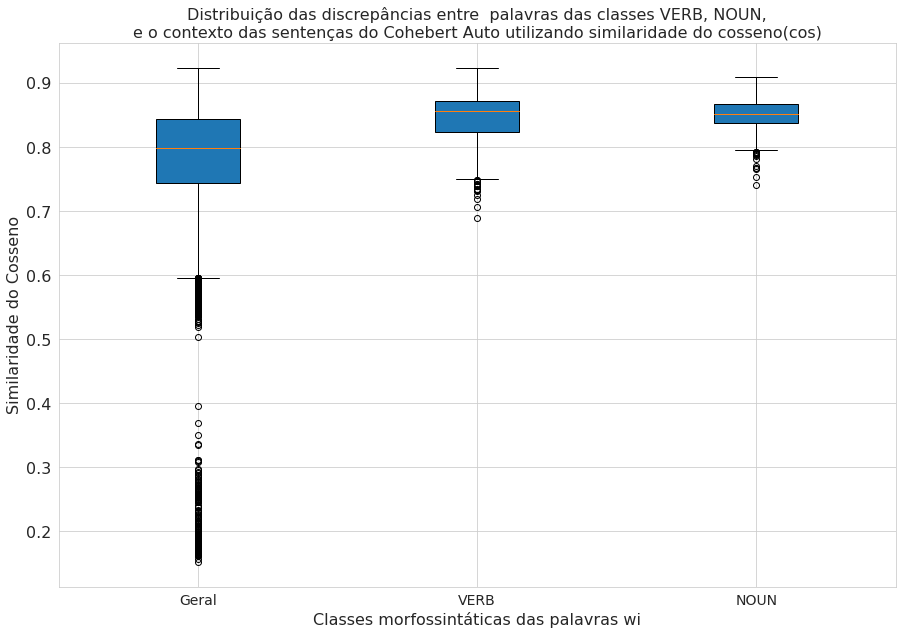

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count      21917.000000       2279.000000       5375.000000
mean          24.729612         22.558524         22.192333
std            3.971112          3.520395          3.395575
min           13.929336         13.929336         16.489443
25%           22.087664         20.030607         20.243881
50%           24.305943         22.614470         21.517450
75%           26.731655         24.764598         22.975286
max           40.750175         38.542923         37.109863

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


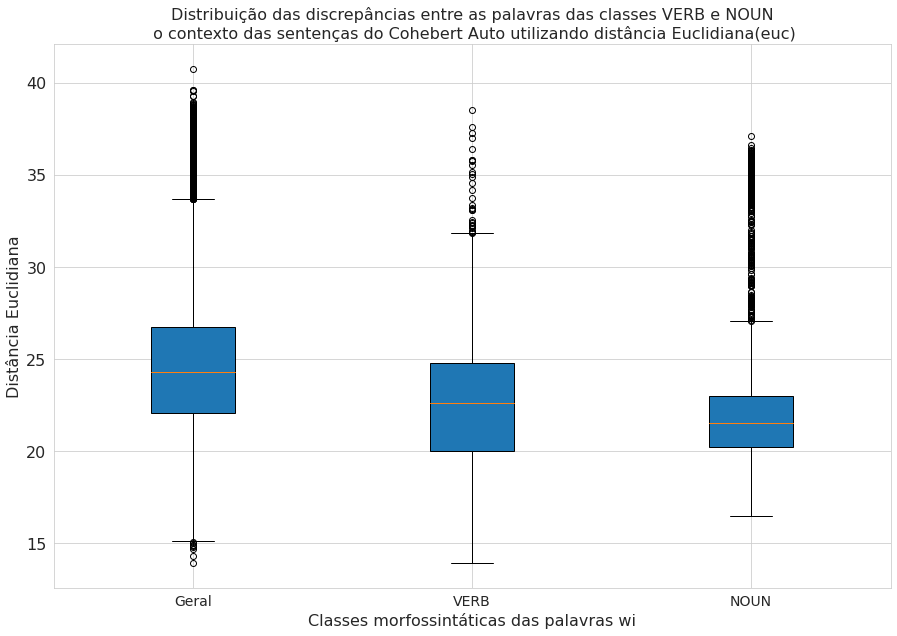

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count      21917.000000       2279.000000       5375.000000
mean        1169.621521       1064.077674       1019.545600
std          172.507718        153.757357         97.789814
min          681.581670        681.581670        803.217040
25%         1055.706400        951.481730        950.825250
50%         1167.359900       1077.826300       1002.931150
75%         1264.778300       1171.523900       1079.585050
max         1759.430200       1620.444600       1523.703000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


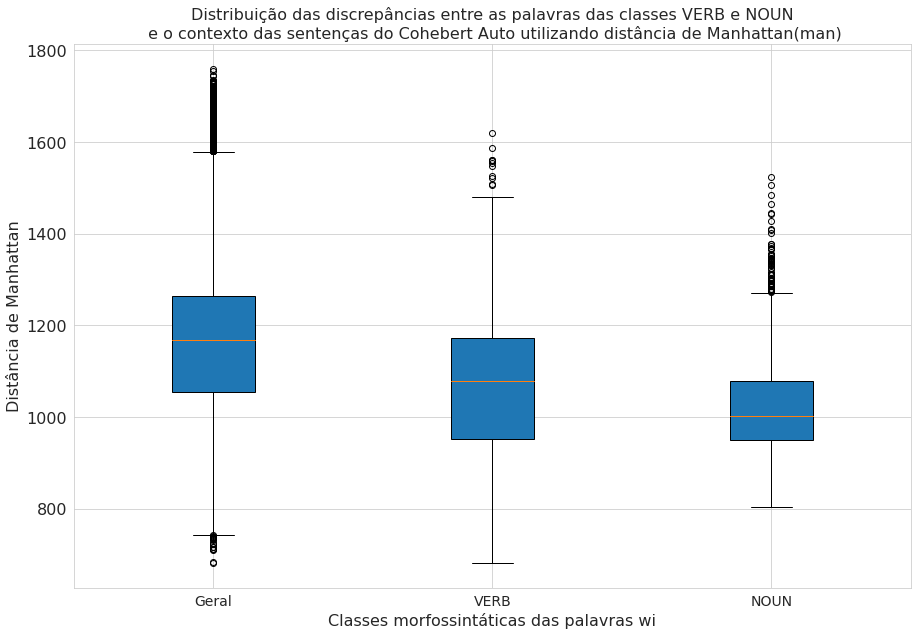

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2279


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       2279.000000       2279.000000       2279.000000      2279.000000   
mean           0.918918         14.271108        659.560493         0.885543   
std            0.057525          8.890570        409.554133         0.094894   
min            0.785569          0.000000          0.000000         0.655180   
25%            0.878470          0.000000          0.000000         0.809635   
50%            0.909328         17.696329        823.600464         0.904733   
75%            1.000000         20.023543        914.322571         0.953180   
max            1.000000         34.275040       1362.634277         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count      2279.000000      2279.000000  
mean         16.811641       784.975712  
std          10.494182       493.146448  
min           0.000000         0.000000  
25%          12.916603       607.696930  
50%          19.480291       890.547668  
75%          25.321859      1203.997681  
max          34.807911      1629.228149

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2279 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  761
      2        1  682
      3        6  311
      4        3  202
      5        2  202
      6        8  119
      7        9    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.12152981758117676
Limite superior             : 1.1822947263717651
Limite inferior             : 0.6961754560470581


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.14354464411735535
Limite superior             : 1.168496921658516
Limite inferior             : 0.5943183451890945


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 20.02354335784912
Limite superior             : 50.0588583946228
Limite inferior             : -30.03531503677368


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 12.405256271362305
Limite superior             : 43.92974376678467
Limite inferior             : -5.691281318664551


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 914.3225708007812
Limite superior             : 2285.806427001953
Limite inferior             : -1371.4838562011719


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 596.3007507324219
Limite superior             : 2098.4488067626953
Limite inferior             : -286.7541961669922


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5375


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       4898.000000       4898.000000       4898.000000      4898.000000   
mean           0.671209         33.032360       1542.574834         0.657854   
std            0.065974          4.787903        182.551839         0.070181   
min            0.456666         22.360905       1093.340210         0.456666   
25%            0.638149         29.689782       1408.256927         0.616322   
50%            0.682946         32.128242       1520.441833         0.669196   
75%            0.717935         35.146356       1655.916962         0.710641   
max            0.811667         52.019890       2116.197754         0.811667   

       euc_ctxverb_max  man_ctxverb_max  
count      4898.000000      4898.000000  
mean         33.904506      1585.327674  
std           4.592021       181.628357  
min          24.775270      1181.119995  
25%          30.834431      1460.656616  
50%          32.869019      1557.950684  
75%          36.666553      1710.866699  
max          52.019890      2116.197754

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5375 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1005
      3        2  808
      4        5  606
      5        7  443
      6       10  303
      7       11  202
      8       12  202
      9        8  196
     10        1  104
     11        6   92


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5375 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     20768.000000     20768.000000     20768.000000    20768.000000   
mean          0.717176        28.642305      1366.743500        0.708548   
std           0.113358         8.014522       375.428506        0.112863   
min           0.102380         0.000000         0.000000        0.102380   
25%           0.662125        26.915849      1306.391541        0.653960   
50%           0.706429        29.589872      1433.452087        0.702358   
75%           0.749493        32.894737      1570.384644        0.743930   
max           1.000000        52.019890      2116.197754        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count    20768.000000    20768.000000      2279.000000      2279.000000   
mean        29.250854     1397.036426         0.918918        14.271108   
std          7.887431      369.723836         0.057525         8.890570   
min          0.000000        0.000000         0.785569         0.000000   
25%         27.314588     1329.244080         0.878470         0.000000   
50%         29.959181     1447.710693         0.909328        17.696329   
75%         33.385244     1595.163208         1.000000        20.023543   
max         52.019890     2116.197754         1.000000        34.275040   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count      2279.000000     2279.000000     2279.000000     2279.000000   
mean        659.560493        0.885543       16.811641      784.975712   
std         409.554133        0.094894       10.494182      493.146448   
min           0.000000        0.655180        0.000000        0.000000   
25%           0.000000        0.809635       12.916603      607.696930   
50%         823.600464        0.904733       19.480291      890.547668   
75%         914.322571        0.953180       25.321859     1203.997681   
max        1362.634277        1.000000       34.807911     1629.228149   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count      4898.000000      4898.000000      4898.000000     4898.000000   
mean          0.671209        33.032360      1542.574834        0.657854   
std           0.065974         4.787903       182.551839        0.070181   
min           0.456666        22.360905      1093.340210        0.456666   
25%           0.638149        29.689782      1408.256927        0.616322   
50%           0.682946        32.128242      1520.441833        0.669196   
75%           0.717935        35.146356      1655.916962        0.710641   
max           0.811667        52.019890      2116.197754        0.811667   

                                       
      euc_ctxverb_max man_ctxverb_max  
count     4898.000000     4898.000000  
mean        33.904506     1585.327674  
std          4.592021      181.628357  
min         24.775270     1181.119995  
25%         30.834431     1460.656616  
50%         32.869019     1557.950684  
75%         36.666553     1710.866699  
max         52.019890     2116.197754

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count     20768.000000      2279.000000      4898.000000
mean          0.717176         0.918918         0.671209
std           0.113358         0.057525         0.065974
min           0.102380         0.785569         0.456666
25%           0.662125         0.878470         0.638149
50%           0.706429         0.909328         0.682946
75%           0.749493         1.000000         0.717935
max           1.000000         1.000000         0.811667

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


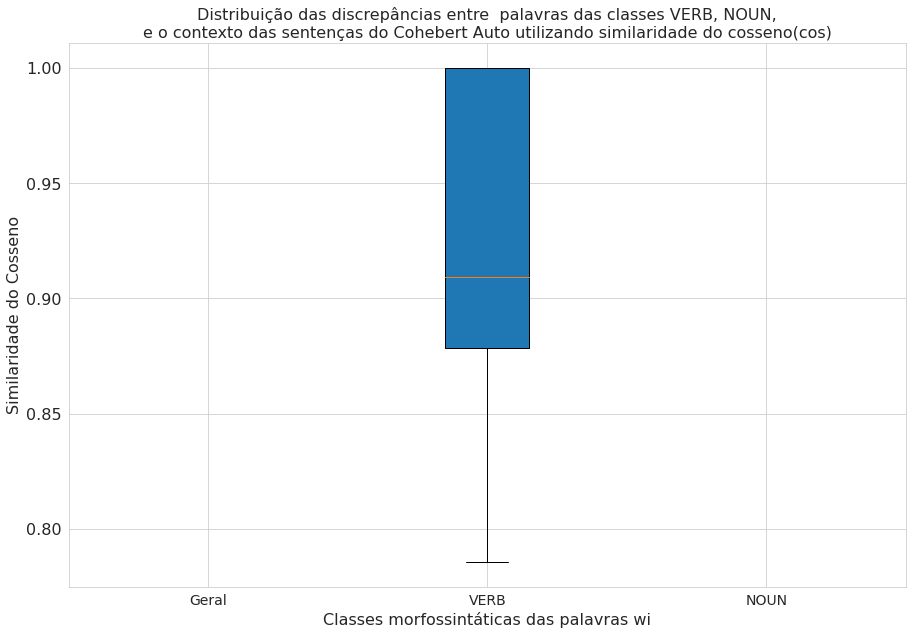

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count     20768.000000      2279.000000      4898.000000
mean         28.642305        14.271108        33.032360
std           8.014522         8.890570         4.787903
min           0.000000         0.000000        22.360905
25%          26.915849         0.000000        29.689782
50%          29.589872        17.696329        32.128242
75%          32.894737        20.023543        35.146356
max          52.019890        34.275040        52.019890

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


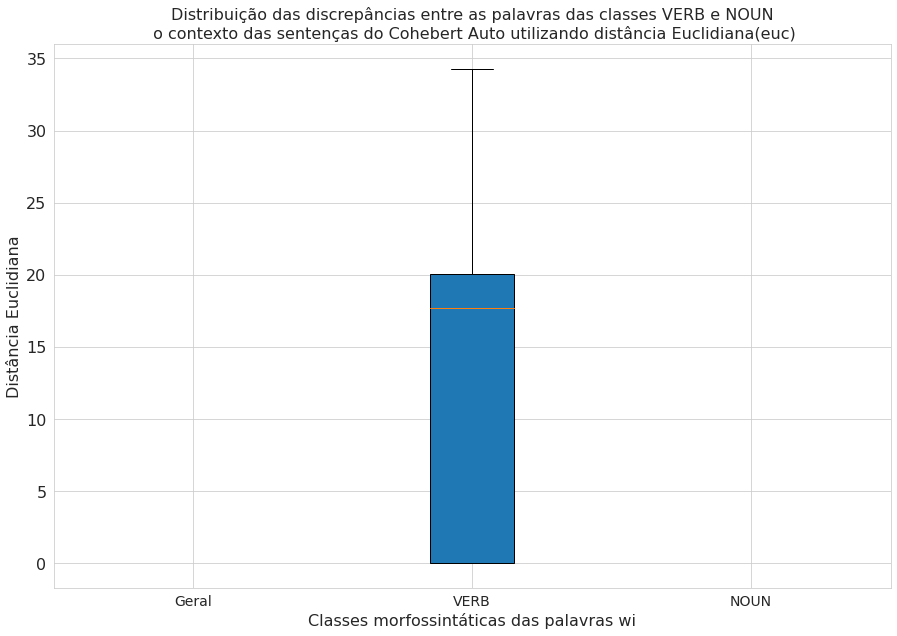

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count     20768.000000      2279.000000      4898.000000
mean       1366.743500       659.560493      1542.574834
std         375.428506       409.554133       182.551839
min           0.000000         0.000000      1093.340210
25%        1306.391541         0.000000      1408.256927
50%        1433.452087       823.600464      1520.441833
75%        1570.384644       914.322571      1655.916962
max        2116.197754      1362.634277      2116.197754

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


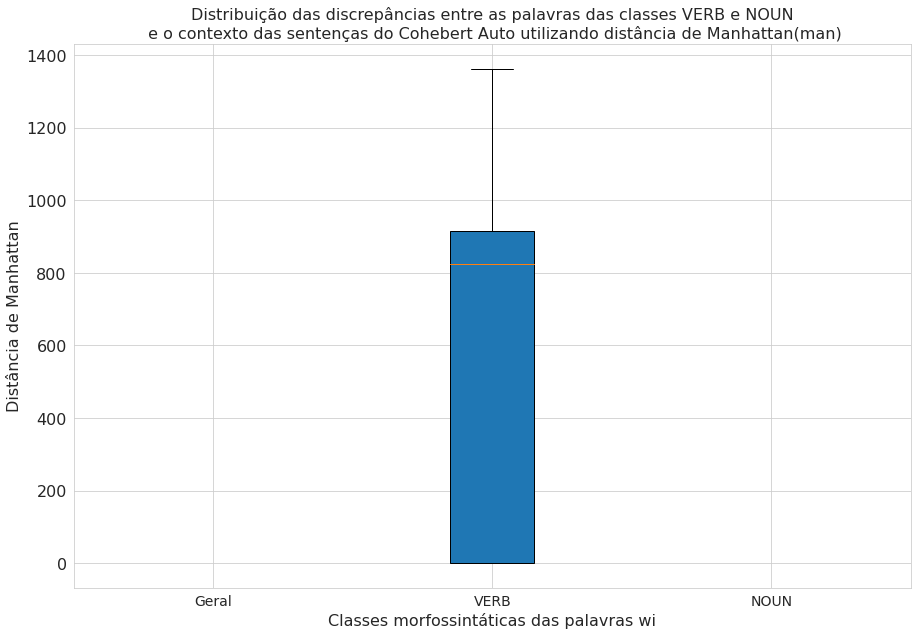

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2279


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       2279.000000       2279.000000       2279.000000      2279.000000   
mean           0.736939         29.324476       1383.752296         0.706058   
std            0.035007          3.282151        151.110249         0.055456   
min            0.617038         19.524500        925.295600         0.538330   
25%            0.710807         26.772329       1282.095800         0.654105   
50%            0.740155         29.516155       1406.449600         0.717371   
75%            0.765765         31.375156       1488.203050         0.749917   
max            0.839125         44.138630       1787.921500         0.834443   

       euc_ctxnoun_max  man_ctxnoun_max  
count      2279.000000      2279.000000  
mean         31.263539      1474.711508  
std           2.745049       110.254615  
min          22.833176      1088.467000  
25%          29.330133      1400.753050  
50%          31.565228      1496.259600  
75%          33.074831      1550.561050  
max          44.138630      1861.415000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2279 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  761
      2        1  682
      3        6  311
      4        3  202
      5        2  202
      6        8  119
      7        9    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05495798587799072
Limite superior             : 0.8482014834880829
Limite inferior             : 0.62836953997612


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 2279 ( 0.0013163668275559457 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3 de 2279 ( 0.0013163668275559457 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6170381307601929 retirar
         Como empilhar e retirar elementos em uma estrutura de dados pilha ?

 2 0.6176058650016785 implementadas
         Como são implementadas as operações de empilhar e de elementos em uma pilha ?

 3 0.619653582572937 localizar
         O que é uma fila e como localizar e desenfileirar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como localizar e desenfileirar seus elementos ?
       1 0.619653582572937 localizar

 2 Como são implementadas as operações de empilhar e de elementos em uma pilha ?
       1 0.7812614440917969 empilhar
       2 0.6176058650016785 implementadas

 3 Como empilhar e retirar elementos em uma estrutura de dados pilha ?
       1 0.7389829754829407 empilhar
       2 0.6170381307601929 retirar


##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.09581205248832703
Limite superior             : 0.8936350792646408
Limite inferior             : 0.5103868693113327


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.602827072143555
Limite superior             : 38.27939701080322
Limite inferior             : 19.868088722229004


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 20 de 2279 ( 0.008775778850372971 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2279 ( 0.00043878894251864854 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  21 de 2279 ( 0.009214567792891619 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.13862991333008 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 2 43.18745040893555 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 3 42.70747375488281 substitui
         O que é uma pilha e como substitui um elemento nela ?

 4 42.629032135009766 descobri
         O que é uma pilha e como descobri seu elemento ?

 5 42.45810317993164 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 19.52449989318848 empilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 44.13862991333008 Ocorre
       2 24.489696502685547 enfileirar

 2 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 43.18745040893555 catar
       2 29.97202682495117 implementadas

 3 O que é uma pilha e como substitui um elemento nela ?
       1 42.70747375488281 substitui

 4 O que é uma pilha e como descobri seu elemento ?
       1 42.629032135009766 descobri

 5 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 42.45810317993164 acontecem
       2 25.168292999267575 enfileirar


##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.7446975708007812
Limite superior             : 38.691877365112305
Limite inferior             : 23.71308708190918


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 19 de 2279 ( 0.008336989907854322 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2279 ( 0.0008775778850372971 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  21 de 2279 ( 0.009214567792891619 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.13862991333008 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 2 43.18745040893555 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 3 42.70747375488281 substitui
         O que é uma pilha e como substitui um elemento nela ?

 4 42.629032135009766 descobri
         O que é uma pilha e como descobri seu elemento ?

 5 42.45810317993164 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 22.833175659179688 carregar
         Como carregar elementos em uma pilha ?

 2 22.833175659179688 carregar
         Como carregar elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 44.13862991333008 Ocorre
       2 32.69255828857422 enfileirar

 2 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 43.18745040893555 catar
       2 32.96154022216797 implementadas

 3 O que é uma pilha e como substitui um elemento nela ?
       1 42.70747375488281 substitui

 4 O que é uma pilha e como descobri seu elemento ?
       1 42.629032135009766 descobri

 5 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 42.45810317993164 acontecem
       2 33.57724380493164 enfileirar


##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 206.10725000000002
Limite superior             : 1797.363925
Limite inferior             : 972.934925


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2279 ( 0.0008775778850372971 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 2279 ( 0.0008775778850372971 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 925.2956 empilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 949.37854 desenfileirar
         Como são implementadas as operações de separação e desenfileirar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 149.80800000000022
Limite superior             : 1775.2730500000002
Limite inferior             : 1176.0410499999994


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 4 de 2279 ( 0.0017551557700745941 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 12 de 2279 ( 0.005265467310223783 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  16 de 2279 ( 0.007020623080298377 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1861.415 desempilhar
         Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?

 2 1787.9215 retirar
         Como empilhar e retirar elementos em uma estrutura de dados pilha ?

 3 1778.7617 chamar
         O que é uma pilha e como chamar seu elemento ?

 4 1777.3707 substitui
         O que é uma pilha e como substitui seu elemento ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1088.467 carregar
         Como carregar elementos em uma pilha ?

 2 1088.467 carregar
         Como carregar elementos em uma pilha ?

 3 1118.6195 gravar
         Como gravar elementos em uma pilha ?

 4 1118.6195 gravar
         Como gravar elementos em uma pilha ?

 5 1146.7719 deixar
         Como deixar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha?
       1 1861.415 desempilhar
       2 1574.1866 implementadas
       3 1540.3955 empilhar

 2 Como empilhar e retirar elementos em uma estrutura de dados pilha ?
       1 1787.9215 retirar
       2 1604.6068 empilhar

 3 O que é uma pilha e como chamar seu elemento ?
       1 1778.7617 chamar

 4 O que é uma pilha e como substitui seu elemento ?
       1 1777.3707 substitui


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5375


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       5375.000000       5375.000000       5375.000000      5375.000000   
mean           0.889423         19.374847        878.594064         0.871116   
std            0.029975          3.521270        115.759959         0.059638   
min            0.775607         12.678500        579.876160         0.654618   
25%            0.866306         16.889246        784.762175         0.852706   
50%            0.886815         19.162447        882.309300         0.882007   
75%            0.916995         20.611534        949.294400         0.916995   
max            0.954686         34.779797       1439.157200         0.954686   

       euc_ctxnoun_max  man_ctxnoun_max  
count      5375.000000      5375.000000  
mean         20.733264       948.266684  
std           4.471189       190.646567  
min          12.678500       579.876160  
25%          17.179253       795.389975  
50%          20.107666       913.871900  
75%          22.267673      1039.479450  
max          34.779797      1632.805500

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5375 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1005
      3        2  808
      4        5  606
      5        7  443
      6       10  303
      7       11  202
      8       12  202
      9        8  196
     10        1  104
     11        6   92


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.050689786672592274
Limite superior             : 0.9930299967527392
Limite inferior             : 0.7902708500623701


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 5375 ( 0.00037209302325581393 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 5375 ( 0.00037209302325581393 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7756071090698242 fila
         Como inser elementos em uma fila ?

 2 0.7756071090698242 fila
         Como inser elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila

 2 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila


##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.050689786672592274
Limite superior             : 0.9930299967527392
Limite inferior             : 0.7902708500623701


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 5375 ( 0.00037209302325581393 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 5375 ( 0.00037209302325581393 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7756071090698242 fila
         Como inser elementos em uma fila ?

 2 0.7756071090698242 fila
         Como inser elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila

 2 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila


##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.722288131713867
Limite superior             : 26.194966316223145
Limite inferior             : 11.305813789367676


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 286


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  286 de 5375 ( 0.053209302325581395 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 34.7797966003418 pilha
         Como esses elementos em uma estrutura de dados pilha ?

 2 34.62910079956055 pilha
         Como tais elementos em uma estrutura de dados pilha ?

 3 34.36362075805664 pilha
         Como desempilhar elementos em uma estrutura de forma pilha ?

 4 34.21431350708008 pilha
         Como os elementos em uma estrutura de dados pilha ?

 5 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como esses elementos em uma estrutura de dados pilha ?
       1 34.7797966003418 pilha
       2 21.915287017822266 dados
       3 21.331085205078125 estrutura
       4 19.15822029113769 elementos

 2 Como tais elementos em uma estrutura de dados pilha ?
       1 34.62910079956055 pilha
       2 22.007713317871094 dados
       3 21.42709732055664 estrutura
       4 18.83693504333496 elementos

 3 Como desempilhar elementos em uma estrutura de forma pilha ?
       1 34.36362075805664 pilha
       2 22.3015251159668 forma
       3 21.11818122863769 elementos
       4 20.57501602172852 estrutura
       5 19.34542465209961 desempilhar

 4 Como os elementos em uma estrutura de dados pilha ?
       1 34.21431350708008 pilha
       2 21.98303604125977 estrutura
       3 21.89358901977539 dados
       4 19.900413513183597 elementos

 5 Como desempilhar elementos em uma estrutura de dados pilha ?
       1 34.02392578125 pilha
       2 20.68986701965332 dados
       3 19.93473052978516 estrut

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.0884199142456055
Limite superior             : 29.900302410125732
Limite inferior             : 9.54662275314331


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 403


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  403 de 5375 ( 0.07497674418604651 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 34.7797966003418 pilha
         Como esses elementos em uma estrutura de dados pilha ?

 2 34.62910079956055 pilha
         Como tais elementos em uma estrutura de dados pilha ?

 3 34.36362075805664 pilha
         Como desempilhar elementos em uma estrutura de forma pilha ?

 4 34.21431350708008 pilha
         Como os elementos em uma estrutura de dados pilha ?

 5 34.02392578125 pilha
         Como desempilhar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como esses elementos em uma estrutura de dados pilha ?
       1 34.7797966003418 pilha
       2 21.915287017822266 dados
       3 21.331085205078125 estrutura
       4 19.15822029113769 elementos

 2 Como tais elementos em uma estrutura de dados pilha ?
       1 34.62910079956055 pilha
       2 22.007713317871094 dados
       3 21.42709732055664 estrutura
       4 18.83693504333496 elementos

 3 Como desempilhar elementos em uma estrutura de forma pilha ?
       1 34.36362075805664 pilha
       2 27.2257080078125 desempilhar
       3 22.3015251159668 forma
       4 21.11818122863769 elementos
       5 20.57501602172852 estrutura

 4 Como os elementos em uma estrutura de dados pilha ?
       1 34.21431350708008 pilha
       2 21.98303604125977 estrutura
       3 21.89358901977539 dados
       4 19.900413513183597 elementos

 5 Como desempilhar elementos em uma estrutura de dados pilha ?
       1 34.02392578125 pilha
       2 29.330642700195312 desempilhar
       3 20.68986701965332 

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 164.53222499999993
Limite superior             : 1196.0927374999999
Limite inferior             : 537.9638375000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 63


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  63 de 5375 ( 0.01172093023255814 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1439.1572 pilha
         Como desempilhar elementos em uma estrutura de longa pilha ?

 2 1401.2903 pilha
         Como desempilhar elementos em uma estrutura de tamanho pilha ?

 3 1392.4546 pilha
         Como desempilhar elementos em uma estrutura de sol pilha ?

 4 1377.0392 pilha
         Como desempilhar elementos em uma estrutura de última pilha ?

 5 1376.3943 pilha
         Como desempilhar elementos em uma estrutura de contra pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de longa pilha ?
       1 1439.1572 pilha
       2 961.99207 elementos
       3 959.0171 desempilhar
       4 882.9069 estrutura

 2 Como desempilhar elementos em uma estrutura de tamanho pilha ?
       1 1401.2903 pilha
       2 1020.07336 tamanho
       3 987.32074 elementos
       4 960.07605 desempilhar
       5 904.9305 estrutura

 3 Como desempilhar elementos em uma estrutura de sol pilha ?
       1 1392.4546 pilha
       2 1182.4897 sol
       3 994.56976 desempilhar
       4 988.2551 elementos
       5 930.65027 estrutura

 4 Como desempilhar elementos em uma estrutura de última pilha ?
       1 1377.0392 pilha
       2 939.2213 desempilhar
       3 931.56165 elementos
       4 873.8061 estrutura

 5 Como desempilhar elementos em uma estrutura de contra pilha ?
       1 1376.3943 pilha
       2 976.2876 desempilhar
       3 963.52875 elementos
       4 896.4706 estrutura


##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 244.08947499999977
Limite superior             : 1405.6136624999995
Limite inferior             : 429.2557625000004


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 254


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  254 de 5375 ( 0.04725581395348837 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1632.8055 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 2 1604.1248 desempilhar
         O que é uma pilha e como medir e desempilhar seus elementos ?

 3 1598.1245 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 4 1592.1936 desempilhar
         O que é uma pilha e como iniciar e desempilhar seus elementos ?

 5 1591.3362 desempilhar
         O que é uma pilha e como começar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1632.8055 desempilhar
       2 922.1848 elementos
       3 890.49243 pilha

 2 O que é uma pilha e como medir e desempilhar seus elementos ?
       1 1604.1248 desempilhar
       2 914.2086 elementos
       3 880.68066 pilha

 3 O que é uma pilha e como carregar e desempilhar seus elementos ?
       1 1598.1245 desempilhar
       2 929.38086 elementos
       3 890.3778 pilha

 4 O que é uma pilha e como iniciar e desempilhar seus elementos ?
       1 1592.1936 desempilhar
       2 916.1824 elementos
       3 882.3093 pilha

 5 O que é uma pilha e como começar e desempilhar seus elementos ?
       1 1591.3362 desempilhar
       2 908.7317 elementos
       3 882.26044 pilha


#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     21917.000000     21917.000000     21917.000000    21917.000000   
mean          0.731659        27.699842      1301.181873        0.722110   
std           0.121930         6.140749       293.280209        0.120442   
min           0.144498        12.678500       579.876160        0.144498   
25%           0.655242        23.651262      1113.246800        0.644733   
50%           0.724338        29.104258      1365.209200        0.711906   
75%           0.828671        31.762957      1514.002900        0.806360   
max           0.954686        44.229778      1993.807600        0.954686   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count    21917.000000    21917.000000      2279.000000      2279.000000   
mean        28.360572     1334.462234         0.736939        29.324476   
std          5.941560      283.805378         0.035007         3.282151   
min         12.678500      579.876160         0.617038        19.524500   
25%         24.527964     1147.627100         0.710807        26.772329   
50%         29.614866     1398.672000         0.740155        29.516155   
75%         32.278828     1538.509300         0.765765        31.375156   
max         44.229778     1993.807600         0.839125        44.138630   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count      2279.000000     2279.000000     2279.000000     2279.000000   
mean       1383.752296        0.706058       31.263539     1474.711508   
std         151.110249        0.055456        2.745049      110.254615   
min         925.295600        0.538330       22.833176     1088.467000   
25%        1282.095800        0.654105       29.330133     1400.753050   
50%        1406.449600        0.717371       31.565228     1496.259600   
75%        1488.203050        0.749917       33.074831     1550.561050   
max        1787.921500        0.834443       44.138630     1861.415000   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count      5375.000000      5375.000000      5375.000000     5375.000000   
mean          0.889423        19.374847       878.594064        0.871116   
std           0.029975         3.521270       115.759959        0.059638   
min           0.775607        12.678500       579.876160        0.654618   
25%           0.866306        16.889246       784.762175        0.852706   
50%           0.886815        19.162447       882.309300        0.882007   
75%           0.916995        20.611534       949.294400        0.916995   
max           0.954686        34.779797      1439.157200        0.954686   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count     5375.000000     5375.000000  
mean        20.733264      948.266684  
std          4.471189      190.646567  
min         12.678500      579.876160  
25%         17.179253      795.389975  
50%         20.107666      913.871900  
75%         22.267673     1039.479450  
max         34.779797     1632.805500

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count     21917.000000      2279.000000      5375.000000
mean          0.731659         0.736939         0.889423
std           0.121930         0.035007         0.029975
min           0.144498         0.617038         0.775607
25%           0.655242         0.710807         0.866306
50%           0.724338         0.740155         0.886815
75%           0.828671         0.765765         0.916995
max           0.954686         0.839125         0.954686

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


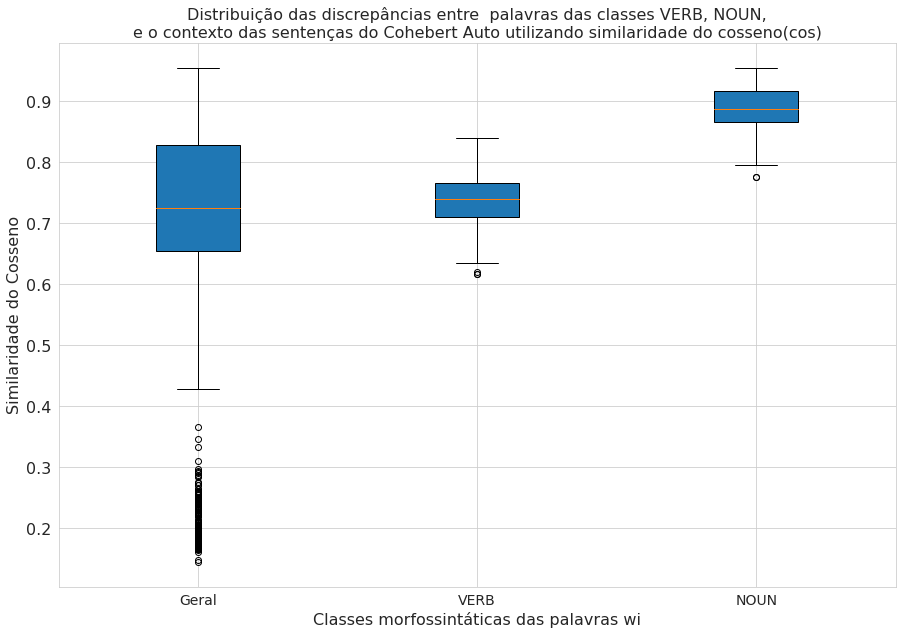

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count     21917.000000      2279.000000      5375.000000
mean         27.699842        29.324476        19.374847
std           6.140749         3.282151         3.521270
min          12.678500        19.524500        12.678500
25%          23.651262        26.772329        16.889246
50%          29.104258        29.516155        19.162447
75%          31.762957        31.375156        20.611534
max          44.229778        44.138630        34.779797

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


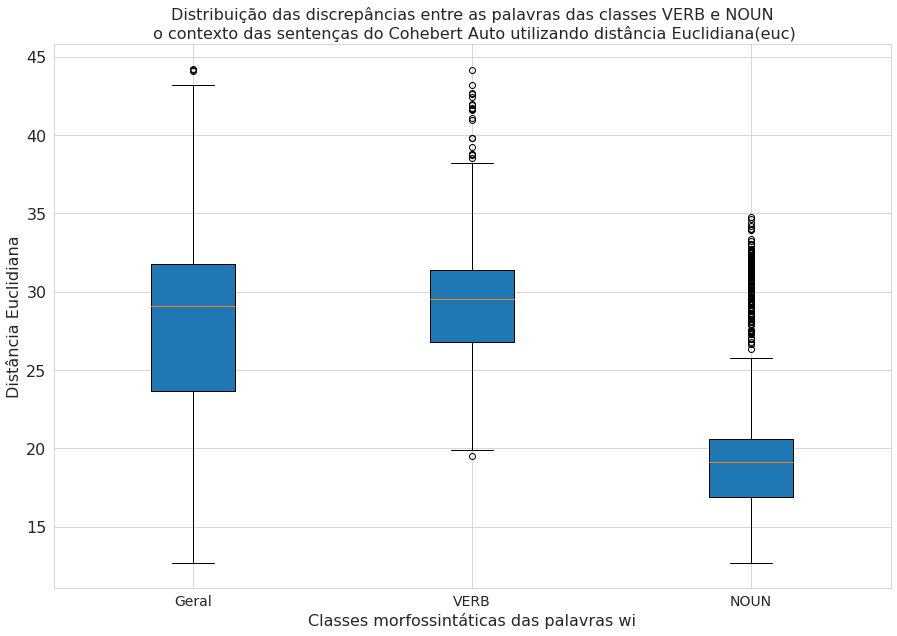

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count     21917.000000      2279.000000      5375.000000
mean       1301.181873      1383.752296       878.594064
std         293.280209       151.110249       115.759959
min         579.876160       925.295600       579.876160
25%        1113.246800      1282.095800       784.762175
50%        1365.209200      1406.449600       882.309300
75%        1514.002900      1488.203050       949.294400
max        1993.807600      1787.921500      1439.157200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


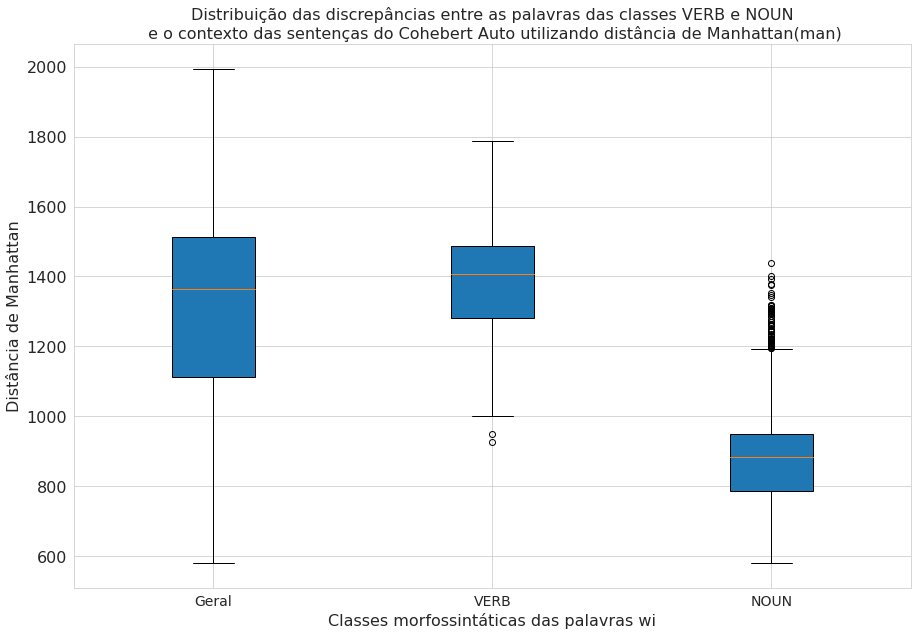

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2279


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           2279.000000           2279.000000           2279.000000   
mean               0.856914             21.867594           1026.395377   
std                0.033805              3.330731            147.634832   
min                0.753798             13.755853            667.484000   
25%                0.826876             19.219910            901.833250   
50%                0.862804             21.640041           1023.523560   
75%                0.883641             24.057522           1134.031500   
max                0.930165             37.377960           1442.134400   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          2279.000000          2279.000000          2279.000000  
mean              0.823356            24.208384          1138.658951  
std               0.071255             3.958987           174.697874  
min               0.641902            15.222116           725.644800  
25%               0.770351            20.888187           990.471220  
50%               0.846756            24.408175          1151.792500  
75%               0.881470            27.254613          1282.281150  
max               0.930165            37.377960          1659.436400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2279 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  761
      2        1  682
      3        6  311
      4        3  202
      5        2  202
      6        8  119
      7        9    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05676454305648804
Limite superior             : 0.968787670135498
Limite inferior             : 0.7417294979095459


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.1111183762550354
Limite superior             : 1.0481470823287964
Limite inferior             : 0.6036735773086548


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.837612152099613
Limite superior             : 31.31394004821778
Limite inferior             : 11.96349143981933


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 23 de 2279 ( 0.010092145677928916 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  23 de 2279 ( 0.010092145677928916 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.377960205078125 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?

 2 35.6634407043457 Ocorre
         Em uma fila a operação de enfileirar Ocorre em qual extremidade ?

 3 34.40611267089844 acontecem
         Em uma fila a operação de enfileirar acontecem em qual extremidade ?

 4 33.888084411621094 foca
         Em uma fila a operação de enfileirar foca em qual extremidade ?

 5 33.81631088256836 ocorrem
         Em uma fila a operação de enfileirar ocorrem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 37.377960205078125 catar
       2 23.84163475036621 implementadas

 2 Em uma fila a operação de enfileirar Ocorre em qual extremidade ?
       1 35.6634407043457 Ocorre
       2 21.51271629333496 enfileirar

 3 Em uma fila a operação de enfileirar acontecem em qual extremidade ?
       1 34.40611267089844 acontecem
       2 21.959779739379883 enfileirar

 4 Em uma fila a operação de enfileirar foca em qual extremidade ?
       1 33.888084411621094 foca
       2 21.8784122467041 enfileirar

 5 Em uma fila a operação de enfileirar ocorrem em qual extremidade ?
       1 33.81631088256836 ocorrem
       2 21.79146385192871 enfileirar


##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.366425514221191
Limite superior             : 36.804251194000244
Limite inferior             : 11.338549137115479


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 2279 ( 0.00043878894251864854 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 2279 ( 0.00043878894251864854 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.377960205078125 catar
         Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de catar e desenfileirar elementos em uma fila ?
       1 37.377960205078125 catar
       2 27.456825256347656 implementadas


##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 232.19825000000003
Limite superior             : 1482.3288750000002
Limite inferior             : 553.535875


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 291.8099299999998
Limite superior             : 1719.9960449999994
Limite inferior             : 552.7563250000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2279 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2279 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2279 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5375


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           5375.000000           5375.000000           5375.000000   
mean               0.858321             21.725588            995.098499   
std                0.026690              3.369147            103.706683   
min                0.772730             15.460507            718.627440   
25%                0.839626             19.811666            922.735430   
50%                0.856426             21.223385            984.753970   
75%                0.875566             22.626747           1063.349150   
max                0.941285             36.320980           1439.157200   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          5375.000000          5375.000000          5375.000000  
mean              0.840438            23.018964          1060.869195  
std               0.053649             3.891432           158.973449  
min               0.657091            15.460507           718.627440  
25%               0.827836            20.534684           951.998900  
50%               0.852461            21.996237          1028.011000  
75%               0.874195            24.842813          1145.975000  
max               0.941285            36.320980          1613.480100

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5375 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1005
      3        2  808
      4        5  606
      5        7  443
      6       10  303
      7       11  202
      8       12  202
      9        8  196
     10        1  104
     11        6   92


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.035939544439315796
Limite superior             : 0.9294752925634384
Limite inferior             : 0.7857171148061752


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 16 de 5375 ( 0.0029767441860465114 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 5375 ( 0.0007441860465116279 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  20 de 5375 ( 0.0037209302325581397 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9412853717803956 elementos
         Como posicion elementos em uma fila ?

 2 0.9412853717803956 elementos
         Como posicion elementos em uma fila ?

 3 0.9407013654708862 elementos
         Como encaix elementos em uma fila ?

 4 0.9407013654708862 elementos
         Como encaix elementos em uma fila ?

 5 0.939037263393402 elementos
         Como por elementos em uma fila ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7727302312850952 operações
         Como são implementadas as operações de empilhar e agrupa elementos em uma pilha ?

 2 0.7756071090698242 fila
         Como inser elementos em uma fila ?

 3 0.7756071090698242 fila
         Como inser elementos em uma fila ?

 4 0.7789428234100342 operações
         Como são implementadas as operações de empilhar e expor elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e expor elementos em uma pilha ?
       1 0.8386175632476807 elementos
       2 0.8177052736282349 pilha
       3 0.7789428234100342 operações

 2 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila

 3 Como inser elementos em uma fila ?
       1 0.9284539818763732 elementos
       2 0.9154465198516846 inser
       3 0.7756071090698242 fila

 4 Como são implementadas as operações de empilhar e agrupa elementos em uma pilha ?
       1 0.8298978209495544 elementos
       2 0.7934690117835999 pilha
       3 0.7727302312850952 operações


##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.046359360218048096
Limite superior             : 0.9437342584133148
Limite inferior             : 0.7582968175411224


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5375 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 597 de 5375 ( 0.11106976744186046 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  597 de 5375 ( 0.11106976744186046 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.657090961933136 desempilhar
         O que é uma pilha e como alimentar e desempilhar seus elementos ?

 2 0.6573323011398315 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 3 0.6582559943199158 desempilhar
         O que é uma pilha e como ligar e desempilhar seus elementos ?

 4 0.6602262854576111 desempilhar
         O que é uma pilha e como instalar e desempilhar seus elementos ?

 5 0.6615619659423828 desempilhar
         O que é uma pilha e como fixar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como achar seu elemento ?
       1 0.8504961729049683 elemento
       2 0.7582865357398987 fila

 2 O que é uma fila e como detectar seu elemento ?
       1 0.8601337671279907 elemento
       2 0.7582291960716248 fila

 3 Como são implementadas as operações de deixar e desenfileirar elementos em uma fila ?
       1 0.8354269862174988 elementos
       2 0.8262117505073547 operações
       3 0.7581549286842346 fila

 4 Como são implementadas as operações de cobrir e desenfileirar elementos em uma fila ?
       1 0.8476523160934448 elementos
       2 0.8443851470947266 operações
       3 0.7581498622894287 fila

 5 Como são implementadas as operações de fechar e desenfileirar elementos em uma fila ?
       1 0.8440549373626709 operações
       2 0.8312572836875916 elementos
       3 0.7581385970115662 fila


##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.8150806427001953
Limite superior             : 26.84936809539795
Limite inferior             : 15.589045524597168


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 346


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 5375 ( 0.0014883720930232557 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  354 de 5375 ( 0.06586046511627908 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.32098007202149 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 2 36.01121520996094 pilha
         Como empilhar e adicionar elementos em uma estrutura de dados pilha ?

 3 35.93612289428711 pilha
         Como empilhar e converter elementos em uma estrutura de dados pilha ?

 4 35.78323745727539 pilha
         Como empilhar e analisar elementos em uma estrutura de dados pilha ?

 5 35.74762344360352 pilha
         Como empilhar e organizar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.4605073928833 elementos
         Como os elementos em uma pilha ?

 2 15.4605073928833 pilha
         Como os elementos em uma pilha ?

 3 15.4605073928833 elementos
         Como os elementos em uma pilha ?

 4 15.4605073928833 pilha
         Como os elementos em uma pilha ?

 5 15.525591850280762 elementos
         Como por elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 36.32098007202149 pilha
       2 21.546550750732425 dados
       3 20.02737617492676 elementos
       4 19.695436477661133 estrutura

 2 Como empilhar e adicionar elementos em uma estrutura de dados pilha ?
       1 36.01121520996094 pilha
       2 21.94520568847656 dados
       3 20.98634910583496 estrutura
       4 20.834482192993164 elementos

 3 Como empilhar e converter elementos em uma estrutura de dados pilha ?
       1 35.93612289428711 pilha
       2 21.01860809326172 dados
       3 20.631038665771484 estrutura
       4 19.99704933166504 elementos

 4 Como empilhar e analisar elementos em uma estrutura de dados pilha ?
       1 35.78323745727539 pilha
       2 20.86922645568848 dados
       3 20.253297805786133 estrutura
       4 19.83630752563477 elementos

 5 Como empilhar e organizar elementos em uma estrutura de dados pilha ?
       1 35.74762344360352 pilha
       2 21.614233016967773 dad

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.30812931060791
Limite superior             : 31.305007457733154
Limite inferior             : 14.072490215301514


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 286


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  286 de 5375 ( 0.053209302325581395 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.32098007202149 pilha
         Como empilhar e transformar elementos em uma estrutura de dados pilha ?

 2 36.01121520996094 pilha
         Como empilhar e adicionar elementos em uma estrutura de dados pilha ?

 3 35.93612289428711 pilha
         Como empilhar e converter elementos em uma estrutura de dados pilha ?

 4 35.78323745727539 pilha
         Como empilhar e analisar elementos em uma estrutura de dados pilha ?

 5 35.74762344360352 pilha
         Como empilhar e organizar elementos em uma estrutura de dados pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como empilhar e transformar elementos em uma estrutura de dados pilha ?
       1 36.32098007202149 pilha
       2 21.546550750732425 dados
       3 20.02737617492676 elementos
       4 19.695436477661133 estrutura

 2 Como empilhar e adicionar elementos em uma estrutura de dados pilha ?
       1 36.01121520996094 pilha
       2 21.94520568847656 dados
       3 20.98634910583496 estrutura
       4 20.834482192993164 elementos

 3 Como empilhar e converter elementos em uma estrutura de dados pilha ?
       1 35.93612289428711 pilha
       2 21.01860809326172 dados
       3 20.631038665771484 estrutura
       4 19.99704933166504 elementos

 4 Como empilhar e analisar elementos em uma estrutura de dados pilha ?
       1 35.78323745727539 pilha
       2 20.86922645568848 dados
       3 20.253297805786133 estrutura
       4 19.83630752563477 elementos

 5 Como empilhar e organizar elementos em uma estrutura de dados pilha ?
       1 35.74762344360352 pilha
       2 21.614233016967773 dad

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 140.61372000000006
Limite superior             : 1274.26973
Limite inferior             : 711.8148499999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 33


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  33 de 5375 ( 0.00613953488372093 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1439.1572 pilha
         Como desempilhar elementos em uma estrutura de longa pilha ?

 2 1401.2903 pilha
         Como desempilhar elementos em uma estrutura de tamanho pilha ?

 3 1392.4546 pilha
         Como desempilhar elementos em uma estrutura de sol pilha ?

 4 1377.0392 pilha
         Como desempilhar elementos em uma estrutura de última pilha ?

 5 1376.3943 pilha
         Como desempilhar elementos em uma estrutura de contra pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como desempilhar elementos em uma estrutura de longa pilha ?
       1 1439.1572 pilha
       2 961.99207 elementos
       3 959.0171 desempilhar
       4 882.9069 estrutura

 2 Como desempilhar elementos em uma estrutura de tamanho pilha ?
       1 1401.2903 pilha
       2 1020.07336 tamanho
       3 987.32074 elementos
       4 960.07605 desempilhar
       5 904.9305 estrutura

 3 Como desempilhar elementos em uma estrutura de sol pilha ?
       1 1392.4546 pilha
       2 1182.4897 sol
       3 994.56976 desempilhar
       4 988.2551 elementos
       5 930.65027 estrutura

 4 Como desempilhar elementos em uma estrutura de última pilha ?
       1 1377.0392 pilha
       2 939.2213 desempilhar
       3 931.56165 elementos
       4 873.8061 estrutura

 5 Como desempilhar elementos em uma estrutura de contra pilha ?
       1 1376.3943 pilha
       2 976.2876 desempilhar
       3 963.52875 elementos
       4 896.4706 estrutura


##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 193.97609999999986
Limite superior             : 1436.9391499999997
Limite inferior             : 661.0347500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 204


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5375 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  204 de 5375 ( 0.037953488372093024 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1613.4801 desempilhar
         O que é uma pilha e como medir e desempilhar seus elementos ?

 2 1609.8331 desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos?

 3 1606.6406 desempilhar
         O que é uma pilha e como carregar e desempilhar seus elementos ?

 4 1600.2947 desempilhar
         O que é uma pilha e como começar e desempilhar seus elementos ?

 5 1598.4446 desempilhar
         O que é uma pilha e como transportar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma pilha e como medir e desempilhar seus elementos ?
       1 1613.4801 desempilhar
       2 1077.7653 elementos
       3 992.2926 pilha

 2 O que é uma pilha e como empilhar e desempilhar seus elementos?
       1 1609.8331 desempilhar
       2 1088.1521 elementos
       3 1015.64404 pilha

 3 O que é uma pilha e como carregar e desempilhar seus elementos ?
       1 1606.6406 desempilhar
       2 1087.0646 elementos
       3 960.5466 pilha

 4 O que é uma pilha e como começar e desempilhar seus elementos ?
       1 1600.2947 desempilhar
       2 1081.375 elementos
       3 1018.583 pilha

 5 O que é uma pilha e como transportar e desempilhar seus elementos ?
       1 1598.4446 desempilhar
       2 1057.4646 elementos
       3 1020.31946 pilha


#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         21917.000000         21917.000000         21917.000000   
mean              0.775809            25.264111          1195.087000   
std               0.089145             4.033163           188.885173   
min               0.135959            13.755853           667.484000   
25%               0.720056            22.248472          1052.323500   
50%               0.782109            25.317371          1191.444300   
75%               0.841891            28.154671          1358.913300   
max               0.941285            42.141659          1723.085400   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        21917.000000        21917.000000        21917.000000   
mean             0.765987           25.962206         1230.065726   
std              0.088836            3.850339          181.559510   
min              0.135959           15.222116          718.627440   
25%              0.713941           23.318903         1114.351000   
50%              0.762880           26.117750         1237.628900   
75%              0.830977           28.459871         1371.239000   
max              0.941285           42.141659         1759.901900   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          2279.000000          2279.000000          2279.000000   
mean              0.856914            21.867594          1026.395377   
std               0.033805             3.330731           147.634832   
min               0.753798            13.755853           667.484000   
25%               0.826876            19.219910           901.833250   
50%               0.862804            21.640041          1023.523560   
75%               0.883641            24.057522          1134.031500   
max               0.930165            37.377960          1442.134400   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count         2279.000000         2279.000000         2279.000000   
mean             0.823356           24.208384         1138.658951   
std              0.071255            3.958987          174.697874   
min              0.641902           15.222116          725.644800   
25%              0.770351           20.888187          990.471220   
50%              0.846756           24.408175         1151.792500   
75%              0.881470           27.254613         1282.281150   
max              0.930165           37.377960         1659.436400   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          5375.000000          5375.000000          5375.000000   
mean              0.858321            21.725588           995.098499   
std               0.026690             3.369147           103.706683   
min               0.772730            15.460507           718.627440   
25%               0.839626            19.811666           922.735430   
50%               0.856426            21.223385           984.753970   
75%               0.875566            22.626747          1063.349150   
max               0.941285            36.320980          1439.157200   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count         5375.000000         5375.000000         5375.000000  
mean             0.840438           23.018964         1060.869195  
std              0.053649            3.891432          158.973449  
min              0.657091           15.460507          718.627440  
25%              0.827836           20.534684          951.998900  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count         21917.000000          2279.000000          5375.000000
mean              0.775809             0.856914             0.858321
std               0.089145             0.033805             0.026690
min               0.135959             0.753798             0.772730
25%               0.720056             0.826876             0.839626
50%               0.782109             0.862804             0.856426
75%               0.841891             0.883641             0.875566
max               0.941285             0.930165             0.941285

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


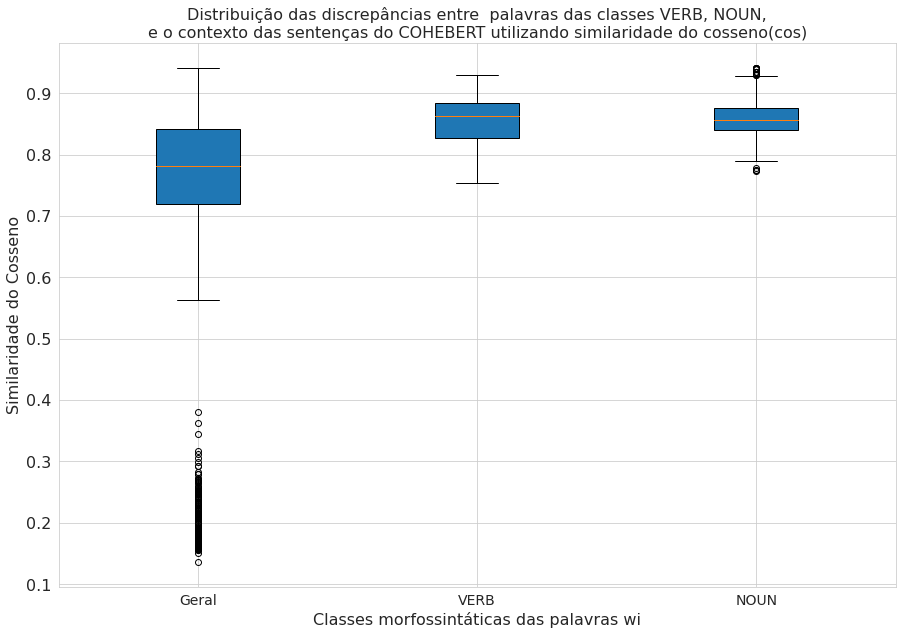

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count         21917.000000          2279.000000          5375.000000
mean             25.264111            21.867594            21.725588
std               4.033163             3.330731             3.369147
min              13.755853            13.755853            15.460507
25%              22.248472            19.219910            19.811666
50%              25.317371            21.640041            21.223385
75%              28.154671            24.057522            22.626747
max              42.141659            37.377960            36.320980

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


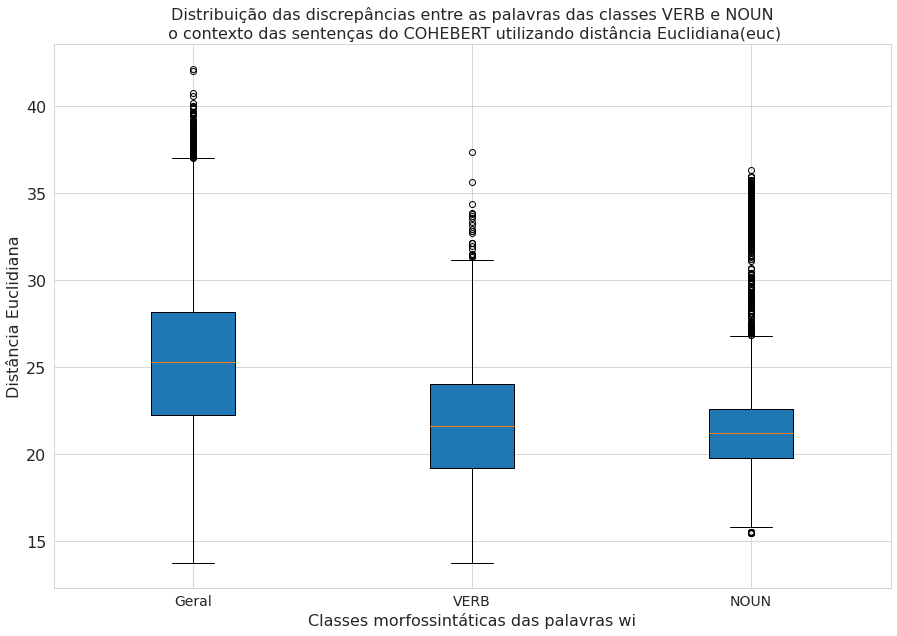

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count         21917.000000          2279.000000          5375.000000
mean           1195.087000          1026.395377           995.098499
std             188.885173           147.634832           103.706683
min             667.484000           667.484000           718.627440
25%            1052.323500           901.833250           922.735430
50%            1191.444300          1023.523560           984.753970
75%            1358.913300          1134.031500          1063.349150
max            1723.085400          1442.134400          1439.157200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


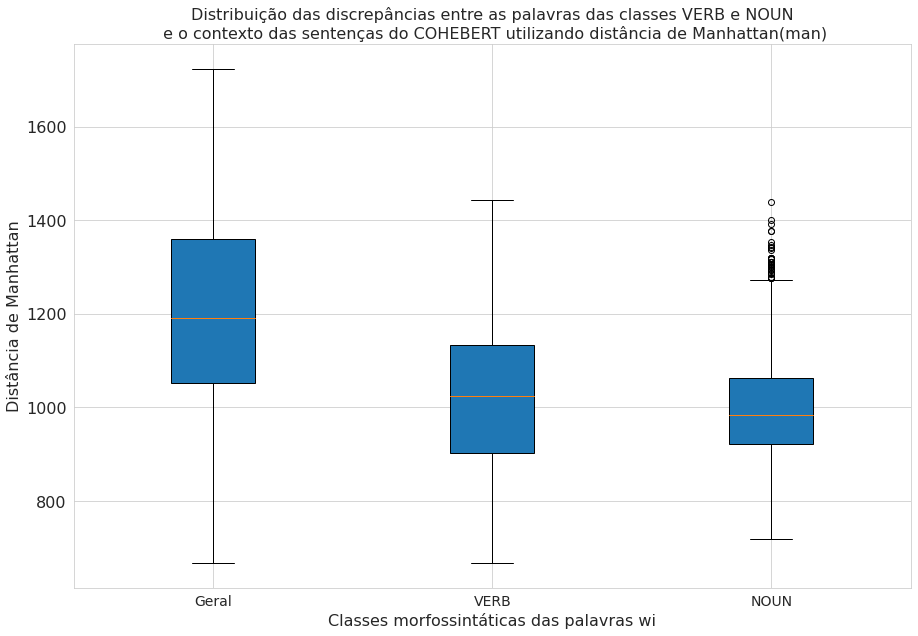

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:30:10 (h:mm:ss)
